In [3]:
from DenoiseST import DenoiseST
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import dropout

file = '/home/cuiyaxuan/spatialLIBD/151672' # Input the data path for the nonlinear model.
count='151672_filtered_feature_bc_matrix.h5' # Input the file name for the nonlinear model.
adata = sc.read_visium(file, count_file=count, load_images=True)

dropout.setup_seed(41)
dropout_rate=dropout.dropout(adata)
print(dropout_rate) # Data quality assessment.

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # cpu or gpu
n_clusters = 5  # Users can input either the default number of clusters or the estimated number of clusters.


import rpy2.robjects as robjects

data_path = '/home/cuiyaxuan/spatialLIBD/151672/151672_filtered_feature_bc_matrix.h5' # Input the data path and file name for the nonlinear model.
position_path = '/home/cuiyaxuan/spatialLIBD/151672/spatial/tissue_positions_list.csv' # Input the data path and position file name for the nonlinear model.
ARI_compare='/home/cuiyaxuan/spatialLIBD/151672/cluster_labels_151672.csv' #  Input the ground truth data path and file name for comparing with the clustering results

robjects.globalenv['data_path'] = robjects.vectors.StrVector([data_path])
robjects.globalenv['position_path'] = robjects.vectors.StrVector([position_path])
robjects.globalenv['ARI_compare'] = robjects.vectors.StrVector([ARI_compare])
robjects.globalenv['n_clusters'] = robjects.IntVector([n_clusters])



#The ARI accuracy and clustering labels have been generated and saved as CSV files.
if dropout_rate>0.85:
   for i in [4000, 4500, 5000]:
      file_fold = file
      adata = sc.read_visium(file_fold, count_file = count, load_images=True)
      adata.var_names_make_unique()
      model = DenoiseST(adata,device=device,n_top_genes=i)
      adata = model.train()
      radius = 50
      tool = 'mclust' # mclust, leiden, and louvain
      from utils import clustering

      if tool == 'mclust':
         clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
      elif tool in ['leiden', 'louvain']:
         clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

      adata.obs['domain']
      adata.obs['domain'].to_csv(f"label_{i}.csv")


   robjects.r('''
   library(SingleCellExperiment)
   library(SC3)
   library("Seurat")
   library("dplyr")
   library("hdf5r")
   library(foreach)
   library(doParallel)


   print(data_path)
   print(position_path)
   print(ARI_compare)
   print(n_clusters)

   source('Cri4.R')
   hc1= Read10X_h5(data_path) #### to your path and project name
   feature<-select_feature(hc1,4000,500)
   detectCores()
   cl <- makeCluster(3) # call 3 cpu cores
   k=n_clusters # k represent the number of spatial domains.
   parLapply(cl,1:3,feature=feature,k=k,pearson_metric) 
   stopCluster(cl)

   tissue_local=read.csv(position_path,row.names = 1,header = FALSE)
   adj_matrix=construct_adj_matrix(feature[[1]],tissue_local)
   write.table(adj_matrix,file="adj_matrix.txt",sep=" ",quote=TRUE)
   detectCores()
   cl <- makeCluster(3) # call 3 cpu cores
   parLapply(cl,1:3,K=k,spectral_nei)
   stopCluster(cl)



   source('GNN_Tradition_6.R')

   source('label_ARI.R')
   true_label=read.csv(ARI_compare,row.names = 1)
   conlabel(hc1,k,true_label,compare=T)        ####   compare=T is compare ARI with the ground truth, compare=F is no compare ARI with the ground truth.
            ''')
else:

   file_fold = file
   adata = sc.read_visium(file_fold, count_file= count, load_images=True)
   adata.var_names_make_unique()
   model = DenoiseST(adata,device=device,n_top_genes=5000)
   adata = model.train()
   radius = 50
   tool = 'mclust' # mclust, leiden, and louvain
   from utils import clustering

   if tool == 'mclust':
      clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
   elif tool in ['leiden', 'louvain']:
      clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

   adata.obs['domain']
   adata.obs['domain'].to_csv(f"label.csv")

0.8968134495641344
0.8968134495641344
Begin to train ST data...


  0%|                                                   | 0/500 [00:00<?, ?it/s]

0


  0%|                                           | 1/500 [00:02<24:55,  3.00s/it]

0


  0%|▏                                          | 2/500 [00:05<23:31,  2.83s/it]

0


  1%|▎                                          | 3/500 [00:08<22:00,  2.66s/it]

0


  1%|▎                                          | 4/500 [00:11<23:22,  2.83s/it]

0


  1%|▍                                          | 5/500 [00:14<23:54,  2.90s/it]

0


  1%|▌                                          | 6/500 [00:17<24:44,  3.00s/it]

0


  1%|▌                                          | 7/500 [00:20<25:19,  3.08s/it]

0


  2%|▋                                          | 8/500 [00:23<24:59,  3.05s/it]

0


  2%|▊                                          | 9/500 [00:26<25:14,  3.08s/it]

0


  2%|▊                                         | 10/500 [00:29<25:01,  3.06s/it]

0


  2%|▉                                         | 11/500 [00:32<24:55,  3.06s/it]

0


  2%|█                                         | 12/500 [00:35<24:35,  3.02s/it]

0


  3%|█                                         | 13/500 [00:38<24:23,  3.01s/it]

0


  3%|█▏                                        | 14/500 [00:41<22:59,  2.84s/it]

0


  3%|█▎                                        | 15/500 [00:43<22:27,  2.78s/it]

0


  3%|█▎                                        | 16/500 [00:47<23:20,  2.89s/it]

0


  3%|█▍                                        | 17/500 [00:50<23:43,  2.95s/it]

0


  4%|█▌                                        | 18/500 [00:53<23:58,  2.98s/it]

0


  4%|█▌                                        | 19/500 [00:56<24:25,  3.05s/it]

0


  4%|█▋                                        | 20/500 [00:59<24:13,  3.03s/it]

0


  4%|█▊                                        | 21/500 [01:02<23:27,  2.94s/it]

0


  4%|█▊                                        | 22/500 [01:04<22:53,  2.87s/it]

0


  5%|█▉                                        | 23/500 [01:07<22:08,  2.79s/it]

0


  5%|██                                        | 24/500 [01:10<22:44,  2.87s/it]

0


  5%|██                                        | 25/500 [01:12<21:45,  2.75s/it]

0


  5%|██▏                                       | 26/500 [01:16<22:37,  2.86s/it]

0


  5%|██▎                                       | 27/500 [01:19<23:05,  2.93s/it]

0


  6%|██▎                                       | 28/500 [01:22<22:54,  2.91s/it]

0


  6%|██▍                                       | 29/500 [01:25<23:29,  2.99s/it]

0


  6%|██▌                                       | 30/500 [01:28<23:28,  3.00s/it]

0


  6%|██▌                                       | 31/500 [01:30<22:35,  2.89s/it]

0


  6%|██▋                                       | 32/500 [01:33<23:02,  2.95s/it]

0


  7%|██▊                                       | 33/500 [01:37<23:23,  3.00s/it]

0


  7%|██▊                                       | 34/500 [01:39<22:21,  2.88s/it]

0


  7%|██▉                                       | 35/500 [01:42<22:42,  2.93s/it]

0


  7%|███                                       | 36/500 [01:45<21:26,  2.77s/it]

0


  7%|███                                       | 37/500 [01:47<21:26,  2.78s/it]

0


  8%|███▏                                      | 38/500 [01:51<22:18,  2.90s/it]

0


  8%|███▎                                      | 39/500 [01:54<22:41,  2.95s/it]

0


  8%|███▎                                      | 40/500 [01:57<22:27,  2.93s/it]

0


  8%|███▍                                      | 41/500 [02:00<23:01,  3.01s/it]

0


  8%|███▌                                      | 42/500 [02:03<23:07,  3.03s/it]

0


  9%|███▌                                      | 43/500 [02:06<23:18,  3.06s/it]

0


  9%|███▋                                      | 44/500 [02:09<23:29,  3.09s/it]

0


  9%|███▊                                      | 45/500 [02:12<23:11,  3.06s/it]

0


  9%|███▊                                      | 46/500 [02:15<23:07,  3.06s/it]

0


  9%|███▉                                      | 47/500 [02:18<22:44,  3.01s/it]

0


 10%|████                                      | 48/500 [02:21<22:59,  3.05s/it]

0


 10%|████                                      | 49/500 [02:24<23:07,  3.08s/it]

0


 10%|████▏                                     | 50/500 [02:28<23:17,  3.11s/it]

0


 10%|████▎                                     | 51/500 [02:30<22:50,  3.05s/it]

0


 10%|████▎                                     | 52/500 [02:33<22:22,  3.00s/it]

0


 11%|████▍                                     | 53/500 [02:36<21:46,  2.92s/it]

0


 11%|████▌                                     | 54/500 [02:39<21:17,  2.86s/it]

0


 11%|████▌                                     | 55/500 [02:42<21:28,  2.89s/it]

0


 11%|████▋                                     | 56/500 [02:45<21:43,  2.94s/it]

0


 11%|████▊                                     | 57/500 [02:48<22:08,  3.00s/it]

0


 12%|████▊                                     | 58/500 [02:51<22:39,  3.08s/it]

0


 12%|████▉                                     | 59/500 [02:54<22:29,  3.06s/it]

0


 12%|█████                                     | 60/500 [02:57<22:40,  3.09s/it]

0


 12%|█████                                     | 61/500 [03:00<22:30,  3.08s/it]

0


 12%|█████▏                                    | 62/500 [03:03<21:38,  2.96s/it]

0


 13%|█████▎                                    | 63/500 [03:06<21:51,  3.00s/it]

0


 13%|█████▍                                    | 64/500 [03:09<20:39,  2.84s/it]

0


 13%|█████▍                                    | 65/500 [03:11<19:45,  2.73s/it]

0


 13%|█████▌                                    | 66/500 [03:14<20:15,  2.80s/it]

0


 13%|█████▋                                    | 67/500 [03:17<20:40,  2.86s/it]

0


 14%|█████▋                                    | 68/500 [03:20<20:57,  2.91s/it]

0


 14%|█████▊                                    | 69/500 [03:23<20:54,  2.91s/it]

0


 14%|█████▉                                    | 70/500 [03:26<21:08,  2.95s/it]

0


 14%|█████▉                                    | 71/500 [03:29<21:17,  2.98s/it]

0


 14%|██████                                    | 72/500 [03:32<20:06,  2.82s/it]

0


 15%|██████▏                                   | 73/500 [03:34<20:06,  2.83s/it]

0


 15%|██████▏                                   | 74/500 [03:37<20:19,  2.86s/it]

0


 15%|██████▎                                   | 75/500 [03:40<20:42,  2.92s/it]

0


 15%|██████▍                                   | 76/500 [03:44<20:57,  2.97s/it]

0


 15%|██████▍                                   | 77/500 [03:47<21:24,  3.04s/it]

0


 16%|██████▌                                   | 78/500 [03:50<21:12,  3.02s/it]

0


 16%|██████▋                                   | 79/500 [03:52<20:37,  2.94s/it]

0


 16%|██████▋                                   | 80/500 [03:56<21:01,  3.00s/it]

0


 16%|██████▊                                   | 81/500 [03:58<20:37,  2.95s/it]

0


 16%|██████▉                                   | 82/500 [04:02<20:51,  2.99s/it]

0


 17%|██████▉                                   | 83/500 [04:05<20:53,  3.01s/it]

0


 17%|███████                                   | 84/500 [04:07<20:28,  2.95s/it]

0


 17%|███████▏                                  | 85/500 [04:10<20:19,  2.94s/it]

0


 17%|███████▏                                  | 86/500 [04:13<20:23,  2.96s/it]

0


 17%|███████▎                                  | 87/500 [04:16<20:44,  3.01s/it]

0


 18%|███████▍                                  | 88/500 [04:20<20:49,  3.03s/it]

0


 18%|███████▍                                  | 89/500 [04:22<20:00,  2.92s/it]

0


 18%|███████▌                                  | 90/500 [04:25<20:18,  2.97s/it]

0


 18%|███████▋                                  | 91/500 [04:28<20:35,  3.02s/it]

0


 18%|███████▋                                  | 92/500 [04:32<20:50,  3.07s/it]

0


 19%|███████▊                                  | 93/500 [04:35<20:37,  3.04s/it]

0


 19%|███████▉                                  | 94/500 [04:37<19:22,  2.86s/it]

0


 19%|███████▉                                  | 95/500 [04:40<19:58,  2.96s/it]

0


 19%|████████                                  | 96/500 [04:43<20:14,  3.01s/it]

0


 19%|████████▏                                 | 97/500 [04:46<20:03,  2.99s/it]

0


 20%|████████▏                                 | 98/500 [04:49<19:11,  2.86s/it]

0


 20%|████████▎                                 | 99/500 [04:52<19:06,  2.86s/it]

0


 20%|████████▏                                | 100/500 [04:55<19:02,  2.86s/it]

0


 20%|████████▎                                | 101/500 [04:58<19:19,  2.90s/it]

0


 20%|████████▎                                | 102/500 [05:00<18:40,  2.81s/it]

0


 21%|████████▍                                | 103/500 [05:03<19:22,  2.93s/it]

0


 21%|████████▌                                | 104/500 [05:06<19:44,  2.99s/it]

0


 21%|████████▌                                | 105/500 [05:10<19:46,  3.00s/it]

0


 21%|████████▋                                | 106/500 [05:12<19:22,  2.95s/it]

0


 21%|████████▊                                | 107/500 [05:16<19:55,  3.04s/it]

0


 22%|████████▊                                | 108/500 [05:19<19:56,  3.05s/it]

0


 22%|████████▉                                | 109/500 [05:21<19:00,  2.92s/it]

0


 22%|█████████                                | 110/500 [05:24<18:56,  2.91s/it]

0


 22%|█████████                                | 111/500 [05:27<18:51,  2.91s/it]

0


 22%|█████████▏                               | 112/500 [05:30<18:50,  2.91s/it]

0


 23%|█████████▎                               | 113/500 [05:33<18:56,  2.94s/it]

0


 23%|█████████▎                               | 114/500 [05:36<18:50,  2.93s/it]

0


 23%|█████████▍                               | 115/500 [05:38<17:52,  2.79s/it]

0


 23%|█████████▌                               | 116/500 [05:41<17:29,  2.73s/it]

0


 23%|█████████▌                               | 117/500 [05:44<18:02,  2.83s/it]

0


 24%|█████████▋                               | 118/500 [05:47<18:20,  2.88s/it]

0


 24%|█████████▊                               | 119/500 [05:50<18:26,  2.90s/it]

0


 24%|█████████▊                               | 120/500 [05:53<18:48,  2.97s/it]

0


 24%|█████████▉                               | 121/500 [05:56<19:06,  3.03s/it]

0


 24%|██████████                               | 122/500 [05:59<19:03,  3.02s/it]

0


 25%|██████████                               | 123/500 [06:02<19:20,  3.08s/it]

0


 25%|██████████▏                              | 124/500 [06:06<19:20,  3.09s/it]

0


 25%|██████████▎                              | 125/500 [06:09<19:18,  3.09s/it]

0


 25%|██████████▎                              | 126/500 [06:12<19:02,  3.05s/it]

0


 25%|██████████▍                              | 127/500 [06:15<18:48,  3.02s/it]

0


 26%|██████████▍                              | 128/500 [06:18<18:37,  3.00s/it]

0


 26%|██████████▌                              | 129/500 [06:21<18:56,  3.06s/it]

0


 26%|██████████▋                              | 130/500 [06:24<19:11,  3.11s/it]

0


 26%|██████████▋                              | 131/500 [06:27<19:07,  3.11s/it]

0


 26%|██████████▊                              | 132/500 [06:30<18:59,  3.10s/it]

0


 27%|██████████▉                              | 133/500 [06:33<18:45,  3.07s/it]

0


 27%|██████████▉                              | 134/500 [06:36<18:29,  3.03s/it]

0


 27%|███████████                              | 135/500 [06:39<18:25,  3.03s/it]

0


 27%|███████████▏                             | 136/500 [06:42<18:45,  3.09s/it]

0


 27%|███████████▏                             | 137/500 [06:45<18:41,  3.09s/it]

0


 28%|███████████▎                             | 138/500 [06:48<18:16,  3.03s/it]

0


 28%|███████████▍                             | 139/500 [06:51<18:02,  3.00s/it]

0


 28%|███████████▍                             | 140/500 [06:54<17:00,  2.83s/it]

0


 28%|███████████▌                             | 141/500 [06:57<17:19,  2.90s/it]

0


 28%|███████████▋                             | 142/500 [07:00<17:47,  2.98s/it]

0


 29%|███████████▋                             | 143/500 [07:03<17:26,  2.93s/it]

0


 29%|███████████▊                             | 144/500 [07:06<17:30,  2.95s/it]

0


 29%|███████████▉                             | 145/500 [07:09<17:39,  2.99s/it]

0


 29%|███████████▉                             | 146/500 [07:12<17:44,  3.01s/it]

0


 29%|████████████                             | 147/500 [07:14<16:46,  2.85s/it]

0


 30%|████████████▏                            | 148/500 [07:17<16:12,  2.76s/it]

0


 30%|████████████▏                            | 149/500 [07:20<16:35,  2.84s/it]

0


 30%|████████████▎                            | 150/500 [07:23<16:50,  2.89s/it]

0


 30%|████████████▍                            | 151/500 [07:25<15:49,  2.72s/it]

0


 30%|████████████▍                            | 152/500 [07:28<15:20,  2.64s/it]

0


 31%|████████████▌                            | 153/500 [07:31<16:05,  2.78s/it]

0


 31%|████████████▋                            | 154/500 [07:34<16:17,  2.83s/it]

0


 31%|████████████▋                            | 155/500 [07:36<15:56,  2.77s/it]

0


 31%|████████████▊                            | 156/500 [07:39<15:52,  2.77s/it]

0


 31%|████████████▊                            | 157/500 [07:42<15:31,  2.72s/it]

0


 32%|████████████▉                            | 158/500 [07:44<15:08,  2.66s/it]

0


 32%|█████████████                            | 159/500 [07:48<16:06,  2.83s/it]

0


 32%|█████████████                            | 160/500 [07:51<16:28,  2.91s/it]

0


 32%|█████████████▏                           | 161/500 [07:54<16:25,  2.91s/it]

0


 32%|█████████████▎                           | 162/500 [07:56<16:24,  2.91s/it]

0


 33%|█████████████▎                           | 163/500 [08:00<16:36,  2.96s/it]

0


 33%|█████████████▍                           | 164/500 [08:03<17:07,  3.06s/it]

0


 33%|█████████████▌                           | 165/500 [08:06<16:52,  3.02s/it]

0


 33%|█████████████▌                           | 166/500 [08:09<16:32,  2.97s/it]

0


 33%|█████████████▋                           | 167/500 [08:12<16:27,  2.97s/it]

0


 34%|█████████████▊                           | 168/500 [08:14<15:36,  2.82s/it]

0


 34%|█████████████▊                           | 169/500 [08:17<15:47,  2.86s/it]

0


 34%|█████████████▉                           | 170/500 [08:20<16:04,  2.92s/it]

0


 34%|██████████████                           | 171/500 [08:23<16:30,  3.01s/it]

0


 34%|██████████████                           | 172/500 [08:26<16:20,  2.99s/it]

0


 35%|██████████████▏                          | 173/500 [08:29<15:41,  2.88s/it]

0


 35%|██████████████▎                          | 174/500 [08:32<15:35,  2.87s/it]

0


 35%|██████████████▎                          | 175/500 [08:34<14:52,  2.75s/it]

0


 35%|██████████████▍                          | 176/500 [08:37<14:20,  2.66s/it]

0


 35%|██████████████▌                          | 177/500 [08:39<13:48,  2.56s/it]

0


 36%|██████████████▌                          | 178/500 [08:42<14:32,  2.71s/it]

0


 36%|██████████████▋                          | 179/500 [08:45<15:11,  2.84s/it]

0


 36%|██████████████▊                          | 180/500 [08:48<15:26,  2.90s/it]

0


 36%|██████████████▊                          | 181/500 [08:51<15:50,  2.98s/it]

0


 36%|██████████████▉                          | 182/500 [08:54<15:34,  2.94s/it]

0


 37%|███████████████                          | 183/500 [08:57<15:37,  2.96s/it]

0


 37%|███████████████                          | 184/500 [09:00<15:06,  2.87s/it]

0


 37%|███████████████▏                         | 185/500 [09:03<15:19,  2.92s/it]

0


 37%|███████████████▎                         | 186/500 [09:06<15:13,  2.91s/it]

0


 37%|███████████████▎                         | 187/500 [09:09<15:36,  2.99s/it]

0


 38%|███████████████▍                         | 188/500 [09:12<15:47,  3.04s/it]

0


 38%|███████████████▍                         | 189/500 [09:15<15:42,  3.03s/it]

0


 38%|███████████████▌                         | 190/500 [09:18<14:44,  2.85s/it]

0


 38%|███████████████▋                         | 191/500 [09:20<14:09,  2.75s/it]

0


 38%|███████████████▋                         | 192/500 [09:23<13:55,  2.71s/it]

0


 39%|███████████████▊                         | 193/500 [09:26<14:21,  2.81s/it]

0


 39%|███████████████▉                         | 194/500 [09:29<14:44,  2.89s/it]

0


 39%|███████████████▉                         | 195/500 [09:32<14:45,  2.90s/it]

0


 39%|████████████████                         | 196/500 [09:35<14:43,  2.91s/it]

0


 39%|████████████████▏                        | 197/500 [09:37<14:00,  2.78s/it]

0


 40%|████████████████▏                        | 198/500 [09:40<14:35,  2.90s/it]

0


 40%|████████████████▎                        | 199/500 [09:43<14:45,  2.94s/it]

0


 40%|████████████████▍                        | 200/500 [09:46<13:48,  2.76s/it]

0


 40%|████████████████▍                        | 201/500 [09:49<14:26,  2.90s/it]

0


 40%|████████████████▌                        | 202/500 [09:52<14:23,  2.90s/it]

0


 41%|████████████████▋                        | 203/500 [09:55<14:45,  2.98s/it]

0


 41%|████████████████▋                        | 204/500 [09:58<14:59,  3.04s/it]

0


 41%|████████████████▊                        | 205/500 [10:01<15:02,  3.06s/it]

0


 41%|████████████████▉                        | 206/500 [10:04<14:53,  3.04s/it]

0


 41%|████████████████▉                        | 207/500 [10:07<14:56,  3.06s/it]

0


 42%|█████████████████                        | 208/500 [10:10<14:59,  3.08s/it]

0


 42%|█████████████████▏                       | 209/500 [10:14<15:14,  3.14s/it]

0


 42%|█████████████████▏                       | 210/500 [10:17<15:02,  3.11s/it]

0


 42%|█████████████████▎                       | 211/500 [10:19<13:50,  2.88s/it]

0


 42%|█████████████████▍                       | 212/500 [10:22<13:22,  2.79s/it]

0


 43%|█████████████████▍                       | 213/500 [10:25<13:44,  2.87s/it]

0


 43%|█████████████████▌                       | 214/500 [10:28<14:02,  2.95s/it]

0


 43%|█████████████████▋                       | 215/500 [10:31<13:51,  2.92s/it]

0


 43%|█████████████████▋                       | 216/500 [10:34<14:01,  2.96s/it]

0


 43%|█████████████████▊                       | 217/500 [10:37<14:25,  3.06s/it]

0


 44%|█████████████████▉                       | 218/500 [10:40<14:26,  3.07s/it]

0


 44%|█████████████████▉                       | 219/500 [10:43<14:27,  3.09s/it]

0


 44%|██████████████████                       | 220/500 [10:46<14:25,  3.09s/it]

0


 44%|██████████████████                       | 221/500 [10:49<14:14,  3.06s/it]

0


 44%|██████████████████▏                      | 222/500 [10:52<13:41,  2.96s/it]

0


 45%|██████████████████▎                      | 223/500 [10:55<13:44,  2.98s/it]

0


 45%|██████████████████▎                      | 224/500 [10:58<13:50,  3.01s/it]

0


 45%|██████████████████▍                      | 225/500 [11:01<13:47,  3.01s/it]

0


 45%|██████████████████▌                      | 226/500 [11:05<14:04,  3.08s/it]

0


 45%|██████████████████▌                      | 227/500 [11:08<14:01,  3.08s/it]

0


 46%|██████████████████▋                      | 228/500 [11:10<13:22,  2.95s/it]

0


 46%|██████████████████▊                      | 229/500 [11:13<13:20,  2.95s/it]

0


 46%|██████████████████▊                      | 230/500 [11:16<13:25,  2.98s/it]

0


 46%|██████████████████▉                      | 231/500 [11:19<12:59,  2.90s/it]

0


 46%|███████████████████                      | 232/500 [11:22<13:04,  2.93s/it]

0


 47%|███████████████████                      | 233/500 [11:25<13:06,  2.95s/it]

0


 47%|███████████████████▏                     | 234/500 [11:28<13:24,  3.02s/it]

0


 47%|███████████████████▎                     | 235/500 [11:31<12:55,  2.93s/it]

0


 47%|███████████████████▎                     | 236/500 [11:34<13:01,  2.96s/it]

0


 47%|███████████████████▍                     | 237/500 [11:37<13:03,  2.98s/it]

0


 48%|███████████████████▌                     | 238/500 [11:40<13:04,  2.99s/it]

0


 48%|███████████████████▌                     | 239/500 [11:43<12:46,  2.94s/it]

0


 48%|███████████████████▋                     | 240/500 [11:46<12:49,  2.96s/it]

0


 48%|███████████████████▊                     | 241/500 [11:49<12:55,  2.99s/it]

0


 48%|███████████████████▊                     | 242/500 [11:52<13:03,  3.04s/it]

0


 49%|███████████████████▉                     | 243/500 [11:55<13:00,  3.04s/it]

0


 49%|████████████████████                     | 244/500 [11:58<12:50,  3.01s/it]

0


 49%|████████████████████                     | 245/500 [12:01<12:46,  3.00s/it]

0


 49%|████████████████████▏                    | 246/500 [12:04<12:44,  3.01s/it]

0


 49%|████████████████████▎                    | 247/500 [12:06<12:02,  2.86s/it]

0


 50%|████████████████████▎                    | 248/500 [12:10<12:19,  2.93s/it]

0


 50%|████████████████████▍                    | 249/500 [12:13<12:37,  3.02s/it]

0


 50%|████████████████████▌                    | 250/500 [12:16<12:22,  2.97s/it]

0


 50%|████████████████████▌                    | 251/500 [12:19<12:13,  2.95s/it]

0


 50%|████████████████████▋                    | 252/500 [12:21<12:07,  2.93s/it]

0


 51%|████████████████████▋                    | 253/500 [12:24<11:38,  2.83s/it]

0


 51%|████████████████████▊                    | 254/500 [12:27<11:53,  2.90s/it]

0


 51%|████████████████████▉                    | 255/500 [12:30<12:10,  2.98s/it]

0


 51%|████████████████████▉                    | 256/500 [12:33<12:21,  3.04s/it]

0


 51%|█████████████████████                    | 257/500 [12:36<12:12,  3.02s/it]

0


 52%|█████████████████████▏                   | 258/500 [12:39<11:52,  2.94s/it]

0


 52%|█████████████████████▏                   | 259/500 [12:42<11:55,  2.97s/it]

0


 52%|█████████████████████▎                   | 260/500 [12:45<11:51,  2.96s/it]

0


 52%|█████████████████████▍                   | 261/500 [12:48<11:52,  2.98s/it]

0


 52%|█████████████████████▍                   | 262/500 [12:51<11:10,  2.82s/it]

0


 53%|█████████████████████▌                   | 263/500 [12:54<11:33,  2.92s/it]

0


 53%|█████████████████████▋                   | 264/500 [12:57<11:40,  2.97s/it]

0


 53%|█████████████████████▋                   | 265/500 [13:00<11:29,  2.93s/it]

0


 53%|█████████████████████▊                   | 266/500 [13:03<11:40,  2.99s/it]

0


 53%|█████████████████████▉                   | 267/500 [13:06<11:39,  3.00s/it]

0


 54%|█████████████████████▉                   | 268/500 [13:09<11:51,  3.07s/it]

0


 54%|██████████████████████                   | 269/500 [13:12<11:57,  3.11s/it]

0


 54%|██████████████████████▏                  | 270/500 [13:15<11:57,  3.12s/it]

0


 54%|██████████████████████▏                  | 271/500 [13:18<11:50,  3.10s/it]

0


 54%|██████████████████████▎                  | 272/500 [13:21<11:36,  3.05s/it]

0


 55%|██████████████████████▍                  | 273/500 [13:24<11:32,  3.05s/it]

0


 55%|██████████████████████▍                  | 274/500 [13:27<11:02,  2.93s/it]

0


 55%|██████████████████████▌                  | 275/500 [13:30<11:04,  2.95s/it]

0


 55%|██████████████████████▋                  | 276/500 [13:33<11:06,  2.97s/it]

0


 55%|██████████████████████▋                  | 277/500 [13:36<11:17,  3.04s/it]

0


 56%|██████████████████████▊                  | 278/500 [13:39<11:15,  3.04s/it]

0


 56%|██████████████████████▉                  | 279/500 [13:42<10:43,  2.91s/it]

0


 56%|██████████████████████▉                  | 280/500 [13:45<10:34,  2.88s/it]

0


 56%|███████████████████████                  | 281/500 [13:48<10:32,  2.89s/it]

0


 56%|███████████████████████                  | 282/500 [13:51<10:29,  2.89s/it]

0


 57%|███████████████████████▏                 | 283/500 [13:53<09:51,  2.72s/it]

0


 57%|███████████████████████▎                 | 284/500 [13:56<10:10,  2.83s/it]

0


 57%|███████████████████████▎                 | 285/500 [13:59<10:14,  2.86s/it]

0


 57%|███████████████████████▍                 | 286/500 [14:01<09:39,  2.71s/it]

0


 57%|███████████████████████▌                 | 287/500 [14:04<09:49,  2.77s/it]

0


 58%|███████████████████████▌                 | 288/500 [14:07<09:54,  2.80s/it]

0


 58%|███████████████████████▋                 | 289/500 [14:10<09:31,  2.71s/it]

0


 58%|███████████████████████▊                 | 290/500 [14:13<09:55,  2.83s/it]

0


 58%|███████████████████████▊                 | 291/500 [14:16<10:11,  2.92s/it]

0


 58%|███████████████████████▉                 | 292/500 [14:19<09:52,  2.85s/it]

0


 59%|████████████████████████                 | 293/500 [14:22<10:05,  2.92s/it]

0


 59%|████████████████████████                 | 294/500 [14:25<10:16,  2.99s/it]

0


 59%|████████████████████████▏                | 295/500 [14:28<10:17,  3.01s/it]

0


 59%|████████████████████████▎                | 296/500 [14:31<10:05,  2.97s/it]

0


 59%|████████████████████████▎                | 297/500 [14:34<10:11,  3.01s/it]

0


 60%|████████████████████████▍                | 298/500 [14:37<10:06,  3.00s/it]

0


 60%|████████████████████████▌                | 299/500 [14:39<09:42,  2.90s/it]

0


 60%|████████████████████████▌                | 300/500 [14:42<09:07,  2.74s/it]

0


 60%|████████████████████████▋                | 301/500 [14:45<09:33,  2.88s/it]

0


 60%|████████████████████████▊                | 302/500 [14:48<09:47,  2.96s/it]

0


 61%|████████████████████████▊                | 303/500 [14:51<09:51,  3.00s/it]

0


 61%|████████████████████████▉                | 304/500 [14:54<09:46,  2.99s/it]

0


 61%|█████████████████████████                | 305/500 [14:57<09:36,  2.96s/it]

0


 61%|█████████████████████████                | 306/500 [15:00<09:25,  2.91s/it]

0


 61%|█████████████████████████▏               | 307/500 [15:03<09:38,  3.00s/it]

0


 62%|█████████████████████████▎               | 308/500 [15:06<09:35,  3.00s/it]

0


 62%|█████████████████████████▎               | 309/500 [15:09<09:40,  3.04s/it]

0


 62%|█████████████████████████▍               | 310/500 [15:12<09:28,  2.99s/it]

0


 62%|█████████████████████████▌               | 311/500 [15:15<09:37,  3.06s/it]

0


 62%|█████████████████████████▌               | 312/500 [15:19<09:41,  3.09s/it]

0


 63%|█████████████████████████▋               | 313/500 [15:21<09:20,  3.00s/it]

0


 63%|█████████████████████████▋               | 314/500 [15:25<09:29,  3.06s/it]

0


 63%|█████████████████████████▊               | 315/500 [15:27<09:17,  3.01s/it]

0


 63%|█████████████████████████▉               | 316/500 [15:30<08:50,  2.88s/it]

0


 63%|█████████████████████████▉               | 317/500 [15:33<09:00,  2.96s/it]

0


 64%|██████████████████████████               | 318/500 [15:36<09:01,  2.97s/it]

0


 64%|██████████████████████████▏              | 319/500 [15:39<09:04,  3.01s/it]

0


 64%|██████████████████████████▏              | 320/500 [15:42<08:31,  2.84s/it]

0


 64%|██████████████████████████▎              | 321/500 [15:45<08:30,  2.85s/it]

0


 64%|██████████████████████████▍              | 322/500 [15:47<08:16,  2.79s/it]

0


 65%|██████████████████████████▍              | 323/500 [15:50<08:28,  2.87s/it]

0


 65%|██████████████████████████▌              | 324/500 [15:53<08:17,  2.83s/it]

0


 65%|██████████████████████████▋              | 325/500 [15:56<08:22,  2.87s/it]

0


 65%|██████████████████████████▋              | 326/500 [15:59<08:32,  2.95s/it]

0


 65%|██████████████████████████▊              | 327/500 [16:02<08:44,  3.03s/it]

0


 66%|██████████████████████████▉              | 328/500 [16:05<08:35,  3.00s/it]

0


 66%|██████████████████████████▉              | 329/500 [16:09<08:46,  3.08s/it]

0


 66%|███████████████████████████              | 330/500 [16:11<08:39,  3.06s/it]

0


 66%|███████████████████████████▏             | 331/500 [16:15<08:40,  3.08s/it]

0


 66%|███████████████████████████▏             | 332/500 [16:18<08:34,  3.06s/it]

0


 67%|███████████████████████████▎             | 333/500 [16:21<08:32,  3.07s/it]

0


 67%|███████████████████████████▍             | 334/500 [16:24<08:27,  3.06s/it]

0


 67%|███████████████████████████▍             | 335/500 [16:27<08:18,  3.02s/it]

0


 67%|███████████████████████████▌             | 336/500 [16:30<08:18,  3.04s/it]

0


 67%|███████████████████████████▋             | 337/500 [16:33<08:17,  3.05s/it]

0


 68%|███████████████████████████▋             | 338/500 [16:36<08:20,  3.09s/it]

0


 68%|███████████████████████████▊             | 339/500 [16:39<08:14,  3.07s/it]

0


 68%|███████████████████████████▉             | 340/500 [16:42<07:41,  2.88s/it]

0


 68%|███████████████████████████▉             | 341/500 [16:44<07:37,  2.87s/it]

0


 68%|████████████████████████████             | 342/500 [16:47<07:14,  2.75s/it]

0


 69%|████████████████████████████▏            | 343/500 [16:50<07:15,  2.77s/it]

0


 69%|████████████████████████████▏            | 344/500 [16:52<06:59,  2.69s/it]

0


 69%|████████████████████████████▎            | 345/500 [16:55<07:18,  2.83s/it]

0


 69%|████████████████████████████▎            | 346/500 [16:58<07:24,  2.89s/it]

0


 69%|████████████████████████████▍            | 347/500 [17:01<07:27,  2.92s/it]

0


 70%|████████████████████████████▌            | 348/500 [17:04<07:28,  2.95s/it]

0


 70%|████████████████████████████▌            | 349/500 [17:07<07:25,  2.95s/it]

0


 70%|████████████████████████████▋            | 350/500 [17:10<07:29,  3.00s/it]

0


 70%|████████████████████████████▊            | 351/500 [17:14<07:31,  3.03s/it]

0


 70%|████████████████████████████▊            | 352/500 [17:17<07:38,  3.10s/it]

0


 71%|████████████████████████████▉            | 353/500 [17:20<07:28,  3.05s/it]

0


 71%|█████████████████████████████            | 354/500 [17:23<07:21,  3.03s/it]

0


 71%|█████████████████████████████            | 355/500 [17:26<07:15,  3.00s/it]

0


 71%|█████████████████████████████▏           | 356/500 [17:29<07:17,  3.04s/it]

0


 71%|█████████████████████████████▎           | 357/500 [17:32<07:08,  3.00s/it]

0


 72%|█████████████████████████████▎           | 358/500 [17:35<07:13,  3.06s/it]

0


 72%|█████████████████████████████▍           | 359/500 [17:38<07:21,  3.13s/it]

0


 72%|█████████████████████████████▌           | 360/500 [17:41<07:08,  3.06s/it]

0


 72%|█████████████████████████████▌           | 361/500 [17:44<06:46,  2.92s/it]

0


 72%|█████████████████████████████▋           | 362/500 [17:47<06:53,  3.00s/it]

0


 73%|█████████████████████████████▊           | 363/500 [17:50<06:39,  2.92s/it]

0


 73%|█████████████████████████████▊           | 364/500 [17:52<06:33,  2.89s/it]

0


 73%|█████████████████████████████▉           | 365/500 [17:55<06:07,  2.72s/it]

0


 73%|██████████████████████████████           | 366/500 [17:58<06:09,  2.76s/it]

0


 73%|██████████████████████████████           | 367/500 [18:01<06:17,  2.84s/it]

0


 74%|██████████████████████████████▏          | 368/500 [18:04<06:24,  2.92s/it]

0


 74%|██████████████████████████████▎          | 369/500 [18:07<06:30,  2.98s/it]

0


 74%|██████████████████████████████▎          | 370/500 [18:10<06:32,  3.02s/it]

0


 74%|██████████████████████████████▍          | 371/500 [18:13<06:35,  3.07s/it]

0


 74%|██████████████████████████████▌          | 372/500 [18:16<06:27,  3.02s/it]

0


 75%|██████████████████████████████▌          | 373/500 [18:19<06:20,  3.00s/it]

0


 75%|██████████████████████████████▋          | 374/500 [18:22<06:05,  2.90s/it]

0


 75%|██████████████████████████████▊          | 375/500 [18:25<06:10,  2.96s/it]

0


 75%|██████████████████████████████▊          | 376/500 [18:28<06:11,  3.00s/it]

0


 75%|██████████████████████████████▉          | 377/500 [18:30<05:48,  2.84s/it]

0


 76%|██████████████████████████████▉          | 378/500 [18:33<05:51,  2.88s/it]

0


 76%|███████████████████████████████          | 379/500 [18:36<05:58,  2.96s/it]

0


 76%|███████████████████████████████▏         | 380/500 [18:39<05:33,  2.78s/it]

0


 76%|███████████████████████████████▏         | 381/500 [18:42<05:41,  2.87s/it]

0


 76%|███████████████████████████████▎         | 382/500 [18:45<05:52,  2.99s/it]

0


 77%|███████████████████████████████▍         | 383/500 [18:48<05:54,  3.03s/it]

0


 77%|███████████████████████████████▍         | 384/500 [18:51<05:50,  3.02s/it]

0


 77%|███████████████████████████████▌         | 385/500 [18:54<05:46,  3.01s/it]

0


 77%|███████████████████████████████▋         | 386/500 [18:57<05:45,  3.03s/it]

0


 77%|███████████████████████████████▋         | 387/500 [19:00<05:34,  2.96s/it]

0


 78%|███████████████████████████████▊         | 388/500 [19:03<05:38,  3.02s/it]

0


 78%|███████████████████████████████▉         | 389/500 [19:07<05:45,  3.12s/it]

0


 78%|███████████████████████████████▉         | 390/500 [19:10<05:41,  3.11s/it]

0


 78%|████████████████████████████████         | 391/500 [19:13<05:36,  3.08s/it]

0


 78%|████████████████████████████████▏        | 392/500 [19:16<05:32,  3.08s/it]

0


 79%|████████████████████████████████▏        | 393/500 [19:18<05:15,  2.95s/it]

0


 79%|████████████████████████████████▎        | 394/500 [19:21<05:16,  2.99s/it]

0


 79%|████████████████████████████████▍        | 395/500 [19:24<05:12,  2.98s/it]

0


 79%|████████████████████████████████▍        | 396/500 [19:27<05:10,  2.99s/it]

0


 79%|████████████████████████████████▌        | 397/500 [19:30<05:07,  2.98s/it]

0


 80%|████████████████████████████████▋        | 398/500 [19:33<05:04,  2.99s/it]

0


 80%|████████████████████████████████▋        | 399/500 [19:36<04:45,  2.83s/it]

0


 80%|████████████████████████████████▊        | 400/500 [19:39<04:48,  2.88s/it]

0


 80%|████████████████████████████████▉        | 401/500 [19:42<04:46,  2.89s/it]

0


 80%|████████████████████████████████▉        | 402/500 [19:45<04:46,  2.93s/it]

0


 81%|█████████████████████████████████        | 403/500 [19:48<04:39,  2.88s/it]

0


 81%|█████████████████████████████████▏       | 404/500 [19:50<04:36,  2.88s/it]

0


 81%|█████████████████████████████████▏       | 405/500 [19:53<04:21,  2.75s/it]

0


 81%|█████████████████████████████████▎       | 406/500 [19:56<04:22,  2.79s/it]

0


 81%|█████████████████████████████████▎       | 407/500 [19:59<04:16,  2.76s/it]

0


 82%|█████████████████████████████████▍       | 408/500 [20:02<04:22,  2.85s/it]

0


 82%|█████████████████████████████████▌       | 409/500 [20:04<04:19,  2.85s/it]

0


 82%|█████████████████████████████████▌       | 410/500 [20:07<04:08,  2.76s/it]

0


 82%|█████████████████████████████████▋       | 411/500 [20:10<04:09,  2.81s/it]

0


 82%|█████████████████████████████████▊       | 412/500 [20:13<04:09,  2.83s/it]

0


 83%|█████████████████████████████████▊       | 413/500 [20:15<03:59,  2.76s/it]

0


 83%|█████████████████████████████████▉       | 414/500 [20:18<03:58,  2.77s/it]

0


 83%|██████████████████████████████████       | 415/500 [20:21<04:05,  2.89s/it]

0


 83%|██████████████████████████████████       | 416/500 [20:24<04:09,  2.97s/it]

0


 83%|██████████████████████████████████▏      | 417/500 [20:27<04:00,  2.90s/it]

0


 84%|██████████████████████████████████▎      | 418/500 [20:30<04:06,  3.00s/it]

0


 84%|██████████████████████████████████▎      | 419/500 [20:34<04:06,  3.04s/it]

0


 84%|██████████████████████████████████▍      | 420/500 [20:36<03:49,  2.87s/it]

0


 84%|██████████████████████████████████▌      | 421/500 [20:39<03:42,  2.82s/it]

0


 84%|██████████████████████████████████▌      | 422/500 [20:42<03:44,  2.88s/it]

0


 85%|██████████████████████████████████▋      | 423/500 [20:45<03:43,  2.91s/it]

0


 85%|██████████████████████████████████▊      | 424/500 [20:48<03:38,  2.87s/it]

0


 85%|██████████████████████████████████▊      | 425/500 [20:50<03:23,  2.71s/it]

0


 85%|██████████████████████████████████▉      | 426/500 [20:53<03:27,  2.81s/it]

0


 85%|███████████████████████████████████      | 427/500 [20:55<03:19,  2.74s/it]

0


 86%|███████████████████████████████████      | 428/500 [20:58<03:22,  2.81s/it]

0


 86%|███████████████████████████████████▏     | 429/500 [21:01<03:21,  2.84s/it]

0


 86%|███████████████████████████████████▎     | 430/500 [21:04<03:21,  2.87s/it]

0


 86%|███████████████████████████████████▎     | 431/500 [21:07<03:21,  2.92s/it]

0


 86%|███████████████████████████████████▍     | 432/500 [21:10<03:21,  2.96s/it]

0


 87%|███████████████████████████████████▌     | 433/500 [21:13<03:12,  2.88s/it]

0


 87%|███████████████████████████████████▌     | 434/500 [21:16<03:13,  2.94s/it]

0


 87%|███████████████████████████████████▋     | 435/500 [21:19<03:12,  2.96s/it]

0


 87%|███████████████████████████████████▊     | 436/500 [21:22<03:12,  3.00s/it]

0


 87%|███████████████████████████████████▊     | 437/500 [21:25<03:03,  2.92s/it]

0


 88%|███████████████████████████████████▉     | 438/500 [21:27<02:52,  2.79s/it]

0


 88%|███████████████████████████████████▉     | 439/500 [21:30<02:47,  2.75s/it]

0


 88%|████████████████████████████████████     | 440/500 [21:33<02:49,  2.83s/it]

0


 88%|████████████████████████████████████▏    | 441/500 [21:36<02:43,  2.78s/it]

0


 88%|████████████████████████████████████▏    | 442/500 [21:38<02:38,  2.73s/it]

0


 89%|████████████████████████████████████▎    | 443/500 [21:41<02:39,  2.80s/it]

0


 89%|████████████████████████████████████▍    | 444/500 [21:44<02:39,  2.84s/it]

0


 89%|████████████████████████████████████▍    | 445/500 [21:47<02:39,  2.91s/it]

0


 89%|████████████████████████████████████▌    | 446/500 [21:50<02:29,  2.78s/it]

0


 89%|████████████████████████████████████▋    | 447/500 [21:53<02:28,  2.80s/it]

0


 90%|████████████████████████████████████▋    | 448/500 [21:56<02:27,  2.83s/it]

0


 90%|████████████████████████████████████▊    | 449/500 [21:58<02:24,  2.83s/it]

0


 90%|████████████████████████████████████▉    | 450/500 [22:01<02:15,  2.71s/it]

0


 90%|████████████████████████████████████▉    | 451/500 [22:04<02:20,  2.86s/it]

0


 90%|█████████████████████████████████████    | 452/500 [22:07<02:19,  2.91s/it]

0


 91%|█████████████████████████████████████▏   | 453/500 [22:10<02:17,  2.93s/it]

0


 91%|█████████████████████████████████████▏   | 454/500 [22:13<02:15,  2.94s/it]

0


 91%|█████████████████████████████████████▎   | 455/500 [22:16<02:06,  2.81s/it]

0


 91%|█████████████████████████████████████▍   | 456/500 [22:19<02:09,  2.95s/it]

0


 91%|█████████████████████████████████████▍   | 457/500 [22:22<02:09,  3.00s/it]

0


 92%|█████████████████████████████████████▌   | 458/500 [22:25<02:05,  3.00s/it]

0


 92%|█████████████████████████████████████▋   | 459/500 [22:28<02:02,  2.98s/it]

0


 92%|█████████████████████████████████████▋   | 460/500 [22:31<02:01,  3.04s/it]

0


 92%|█████████████████████████████████████▊   | 461/500 [22:34<01:55,  2.96s/it]

0


 92%|█████████████████████████████████████▉   | 462/500 [22:37<01:52,  2.95s/it]

0


 93%|█████████████████████████████████████▉   | 463/500 [22:39<01:43,  2.80s/it]

0


 93%|██████████████████████████████████████   | 464/500 [22:42<01:42,  2.84s/it]

0


 93%|██████████████████████████████████████▏  | 465/500 [22:45<01:34,  2.69s/it]

0


 93%|██████████████████████████████████████▏  | 466/500 [22:48<01:35,  2.80s/it]

0


 93%|██████████████████████████████████████▎  | 467/500 [22:51<01:34,  2.87s/it]

0


 94%|██████████████████████████████████████▍  | 468/500 [22:53<01:30,  2.84s/it]

0


 94%|██████████████████████████████████████▍  | 469/500 [22:56<01:28,  2.85s/it]

0


 94%|██████████████████████████████████████▌  | 470/500 [22:59<01:26,  2.88s/it]

0


 94%|██████████████████████████████████████▌  | 471/500 [23:02<01:21,  2.81s/it]

0


 94%|██████████████████████████████████████▋  | 472/500 [23:04<01:17,  2.76s/it]

0


 95%|██████████████████████████████████████▊  | 473/500 [23:08<01:17,  2.87s/it]

0


 95%|██████████████████████████████████████▊  | 474/500 [23:11<01:15,  2.89s/it]

0


 95%|██████████████████████████████████████▉  | 475/500 [23:13<01:10,  2.82s/it]

0


 95%|███████████████████████████████████████  | 476/500 [23:16<01:09,  2.89s/it]

0


 95%|███████████████████████████████████████  | 477/500 [23:19<01:06,  2.91s/it]

0


 96%|███████████████████████████████████████▏ | 478/500 [23:22<01:03,  2.87s/it]

0


 96%|███████████████████████████████████████▎ | 479/500 [23:25<01:00,  2.87s/it]

0


 96%|███████████████████████████████████████▎ | 480/500 [23:28<00:58,  2.92s/it]

0


 96%|███████████████████████████████████████▍ | 481/500 [23:31<00:57,  3.02s/it]

0


 96%|███████████████████████████████████████▌ | 482/500 [23:34<00:53,  2.98s/it]

0


 97%|███████████████████████████████████████▌ | 483/500 [23:37<00:48,  2.85s/it]

0


 97%|███████████████████████████████████████▋ | 484/500 [23:39<00:44,  2.77s/it]

0


 97%|███████████████████████████████████████▊ | 485/500 [23:42<00:41,  2.78s/it]

0


 97%|███████████████████████████████████████▊ | 486/500 [23:45<00:38,  2.72s/it]

0


 97%|███████████████████████████████████████▉ | 487/500 [23:48<00:36,  2.84s/it]

0


 98%|████████████████████████████████████████ | 488/500 [23:50<00:33,  2.79s/it]

0


 98%|████████████████████████████████████████ | 489/500 [23:54<00:32,  2.91s/it]

0


 98%|████████████████████████████████████████▏| 490/500 [23:57<00:29,  3.00s/it]

0


 98%|████████████████████████████████████████▎| 491/500 [24:00<00:26,  2.95s/it]

0


 98%|████████████████████████████████████████▎| 492/500 [24:03<00:24,  3.01s/it]

0


 99%|████████████████████████████████████████▍| 493/500 [24:06<00:21,  3.00s/it]

0


 99%|████████████████████████████████████████▌| 494/500 [24:09<00:17,  2.97s/it]

0


 99%|████████████████████████████████████████▌| 495/500 [24:12<00:14,  2.99s/it]

0


 99%|████████████████████████████████████████▋| 496/500 [24:15<00:11,  2.96s/it]

0


 99%|████████████████████████████████████████▊| 497/500 [24:18<00:09,  3.03s/it]

0


100%|████████████████████████████████████████▊| 498/500 [24:21<00:06,  3.01s/it]

0


100%|████████████████████████████████████████▉| 499/500 [24:24<00:03,  3.06s/it]

0


100%|█████████████████████████████████████████| 500/500 [24:27<00:00,  2.93s/it]


Optimization finished for ST data!
fitting ...
  |======================================================================| 100%
Begin to train ST data...


  0%|                                                   | 0/500 [00:00<?, ?it/s]

0


  0%|                                           | 1/500 [00:03<28:19,  3.41s/it]

0


  0%|▏                                          | 2/500 [00:06<27:36,  3.33s/it]

0


  1%|▎                                          | 3/500 [00:10<27:52,  3.36s/it]

0


  1%|▎                                          | 4/500 [00:13<27:49,  3.37s/it]

0


  1%|▍                                          | 5/500 [00:16<27:58,  3.39s/it]

0


  1%|▌                                          | 6/500 [00:20<28:09,  3.42s/it]

0


  1%|▌                                          | 7/500 [00:23<27:47,  3.38s/it]

0


  2%|▋                                          | 8/500 [00:27<27:43,  3.38s/it]

0


  2%|▊                                          | 9/500 [00:30<26:39,  3.26s/it]

0


  2%|▊                                         | 10/500 [00:32<25:46,  3.16s/it]

0


  2%|▉                                         | 11/500 [00:36<25:58,  3.19s/it]

0


  2%|█                                         | 12/500 [00:39<26:39,  3.28s/it]

0


  3%|█                                         | 13/500 [00:43<26:57,  3.32s/it]

0


  3%|█▏                                        | 14/500 [00:46<26:48,  3.31s/it]

0


  3%|█▎                                        | 15/500 [00:49<26:51,  3.32s/it]

0


  3%|█▎                                        | 16/500 [00:52<26:07,  3.24s/it]

0


  3%|█▍                                        | 17/500 [00:55<25:03,  3.11s/it]

0


  4%|█▌                                        | 18/500 [00:59<25:50,  3.22s/it]

0


  4%|█▌                                        | 19/500 [01:02<26:05,  3.26s/it]

0


  4%|█▋                                        | 20/500 [01:05<26:04,  3.26s/it]

0


  4%|█▊                                        | 21/500 [01:08<26:02,  3.26s/it]

0


  4%|█▊                                        | 22/500 [01:12<26:29,  3.33s/it]

0


  5%|█▉                                        | 23/500 [01:15<25:30,  3.21s/it]

0


  5%|██                                        | 24/500 [01:18<25:46,  3.25s/it]

0


  5%|██                                        | 25/500 [01:22<25:57,  3.28s/it]

0


  5%|██▏                                       | 26/500 [01:25<26:11,  3.32s/it]

0


  5%|██▎                                       | 27/500 [01:28<26:19,  3.34s/it]

0


  6%|██▎                                       | 28/500 [01:32<26:10,  3.33s/it]

0


  6%|██▍                                       | 29/500 [01:35<26:20,  3.36s/it]

0


  6%|██▌                                       | 30/500 [01:39<26:34,  3.39s/it]

0


  6%|██▌                                       | 31/500 [01:41<25:02,  3.20s/it]

0


  6%|██▋                                       | 32/500 [01:45<25:25,  3.26s/it]

0


  7%|██▊                                       | 33/500 [01:48<25:13,  3.24s/it]

0


  7%|██▊                                       | 34/500 [01:51<25:24,  3.27s/it]

0


  7%|██▉                                       | 35/500 [01:54<24:55,  3.22s/it]

0


  7%|███                                       | 36/500 [01:58<25:17,  3.27s/it]

0


  7%|███                                       | 37/500 [02:01<25:29,  3.30s/it]

0


  8%|███▏                                      | 38/500 [02:04<25:34,  3.32s/it]

0


  8%|███▎                                      | 39/500 [02:08<25:27,  3.31s/it]

0


  8%|███▎                                      | 40/500 [02:11<25:15,  3.30s/it]

0


  8%|███▍                                      | 41/500 [02:14<25:32,  3.34s/it]

0


  8%|███▌                                      | 42/500 [02:18<25:18,  3.32s/it]

0


  9%|███▌                                      | 43/500 [02:21<25:23,  3.33s/it]

0


  9%|███▋                                      | 44/500 [02:24<25:21,  3.34s/it]

0


  9%|███▊                                      | 45/500 [02:27<24:23,  3.22s/it]

0


  9%|███▊                                      | 46/500 [02:31<24:53,  3.29s/it]

0


  9%|███▉                                      | 47/500 [02:34<24:59,  3.31s/it]

0


 10%|████                                      | 48/500 [02:38<24:55,  3.31s/it]

0


 10%|████                                      | 49/500 [02:41<25:07,  3.34s/it]

0


 10%|████▏                                     | 50/500 [02:44<23:49,  3.18s/it]

0


 10%|████▎                                     | 51/500 [02:47<23:43,  3.17s/it]

0


 10%|████▎                                     | 52/500 [02:50<23:10,  3.10s/it]

0


 11%|████▍                                     | 53/500 [02:53<23:00,  3.09s/it]

0


 11%|████▌                                     | 54/500 [02:56<22:31,  3.03s/it]

0


 11%|████▌                                     | 55/500 [02:59<23:08,  3.12s/it]

0


 11%|████▋                                     | 56/500 [03:02<23:41,  3.20s/it]

0


 11%|████▊                                     | 57/500 [03:06<23:51,  3.23s/it]

0


 12%|████▊                                     | 58/500 [03:09<23:01,  3.13s/it]

0


 12%|████▉                                     | 59/500 [03:12<23:27,  3.19s/it]

0


 12%|█████                                     | 60/500 [03:15<23:57,  3.27s/it]

0


 12%|█████                                     | 61/500 [03:19<24:11,  3.31s/it]

0


 12%|█████▏                                    | 62/500 [03:22<24:24,  3.34s/it]

0


 13%|█████▎                                    | 63/500 [03:25<23:51,  3.28s/it]

0


 13%|█████▍                                    | 64/500 [03:29<24:04,  3.31s/it]

0


 13%|█████▍                                    | 65/500 [03:32<24:16,  3.35s/it]

0


 13%|█████▌                                    | 66/500 [03:35<23:44,  3.28s/it]

0


 13%|█████▋                                    | 67/500 [03:39<23:49,  3.30s/it]

0


 14%|█████▋                                    | 68/500 [03:42<24:07,  3.35s/it]

0


 14%|█████▊                                    | 69/500 [03:46<24:16,  3.38s/it]

0


 14%|█████▉                                    | 70/500 [03:49<23:32,  3.28s/it]

0


 14%|█████▉                                    | 71/500 [03:52<23:11,  3.24s/it]

0


 14%|██████                                    | 72/500 [03:55<23:19,  3.27s/it]

0


 15%|██████▏                                   | 73/500 [03:58<22:53,  3.22s/it]

0


 15%|██████▏                                   | 74/500 [04:01<22:41,  3.20s/it]

0


 15%|██████▎                                   | 75/500 [04:04<21:57,  3.10s/it]

0


 15%|██████▍                                   | 76/500 [04:08<22:18,  3.16s/it]

0


 15%|██████▍                                   | 77/500 [04:10<21:17,  3.02s/it]

0


 16%|██████▌                                   | 78/500 [04:14<21:51,  3.11s/it]

0


 16%|██████▋                                   | 79/500 [04:17<22:15,  3.17s/it]

0


 16%|██████▋                                   | 80/500 [04:20<22:24,  3.20s/it]

0


 16%|██████▊                                   | 81/500 [04:23<21:50,  3.13s/it]

0


 16%|██████▉                                   | 82/500 [04:27<22:22,  3.21s/it]

0


 17%|██████▉                                   | 83/500 [04:30<22:47,  3.28s/it]

0


 17%|███████                                   | 84/500 [04:33<21:41,  3.13s/it]

0


 17%|███████▏                                  | 85/500 [04:36<22:28,  3.25s/it]

0


 17%|███████▏                                  | 86/500 [04:40<22:52,  3.32s/it]

0


 17%|███████▎                                  | 87/500 [04:43<22:49,  3.32s/it]

0


 18%|███████▍                                  | 88/500 [04:46<22:32,  3.28s/it]

0


 18%|███████▍                                  | 89/500 [04:49<22:18,  3.26s/it]

0


 18%|███████▌                                  | 90/500 [04:53<22:36,  3.31s/it]

0


 18%|███████▋                                  | 91/500 [04:56<22:49,  3.35s/it]

0


 18%|███████▋                                  | 92/500 [05:00<22:46,  3.35s/it]

0


 19%|███████▊                                  | 93/500 [05:03<22:41,  3.35s/it]

0


 19%|███████▉                                  | 94/500 [05:06<22:36,  3.34s/it]

0


 19%|███████▉                                  | 95/500 [05:09<21:31,  3.19s/it]

0


 19%|████████                                  | 96/500 [05:12<21:36,  3.21s/it]

0


 19%|████████▏                                 | 97/500 [05:16<21:45,  3.24s/it]

0


 20%|████████▏                                 | 98/500 [05:19<22:01,  3.29s/it]

0


 20%|████████▎                                 | 99/500 [05:23<22:17,  3.33s/it]

0


 20%|████████▏                                | 100/500 [05:26<21:54,  3.29s/it]

0


 20%|████████▎                                | 101/500 [05:29<21:47,  3.28s/it]

0


 20%|████████▎                                | 102/500 [05:33<22:13,  3.35s/it]

0


 21%|████████▍                                | 103/500 [05:36<22:40,  3.43s/it]

0


 21%|████████▌                                | 104/500 [05:39<22:20,  3.38s/it]

0


 21%|████████▌                                | 105/500 [05:43<21:48,  3.31s/it]

0


 21%|████████▋                                | 106/500 [05:46<21:22,  3.26s/it]

0


 21%|████████▊                                | 107/500 [05:49<21:29,  3.28s/it]

0


 22%|████████▊                                | 108/500 [05:53<21:46,  3.33s/it]

0


 22%|████████▉                                | 109/500 [05:56<22:04,  3.39s/it]

0


 22%|█████████                                | 110/500 [05:59<22:06,  3.40s/it]

0


 22%|█████████                                | 111/500 [06:03<21:55,  3.38s/it]

0


 22%|█████████▏                               | 112/500 [06:06<21:43,  3.36s/it]

0


 23%|█████████▎                               | 113/500 [06:09<21:33,  3.34s/it]

0


 23%|█████████▎                               | 114/500 [06:12<20:18,  3.16s/it]

0


 23%|█████████▍                               | 115/500 [06:16<20:43,  3.23s/it]

0


 23%|█████████▌                               | 116/500 [06:19<20:50,  3.26s/it]

0


 23%|█████████▌                               | 117/500 [06:22<20:16,  3.18s/it]

0


 24%|█████████▋                               | 118/500 [06:25<20:28,  3.22s/it]

0


 24%|█████████▊                               | 119/500 [06:29<20:54,  3.29s/it]

0


 24%|█████████▊                               | 120/500 [06:32<21:03,  3.32s/it]

0


 24%|█████████▉                               | 121/500 [06:36<21:23,  3.39s/it]

0


 24%|██████████                               | 122/500 [06:39<21:02,  3.34s/it]

0


 25%|██████████                               | 123/500 [06:42<20:59,  3.34s/it]

0


 25%|██████████▏                              | 124/500 [06:45<20:52,  3.33s/it]

0


 25%|██████████▎                              | 125/500 [06:48<19:48,  3.17s/it]

0


 25%|██████████▎                              | 126/500 [06:51<19:53,  3.19s/it]

0


 25%|██████████▍                              | 127/500 [06:54<19:31,  3.14s/it]

0


 26%|██████████▍                              | 128/500 [06:58<19:30,  3.15s/it]

0


 26%|██████████▌                              | 129/500 [07:01<20:10,  3.26s/it]

0


 26%|██████████▋                              | 130/500 [07:05<20:46,  3.37s/it]

0


 26%|██████████▋                              | 131/500 [07:08<20:54,  3.40s/it]

0


 26%|██████████▊                              | 132/500 [07:12<20:58,  3.42s/it]

0


 27%|██████████▉                              | 133/500 [07:15<20:40,  3.38s/it]

0


 27%|██████████▉                              | 134/500 [07:18<20:40,  3.39s/it]

0


 27%|███████████                              | 135/500 [07:22<20:54,  3.44s/it]

0


 27%|███████████▏                             | 136/500 [07:25<20:51,  3.44s/it]

0


 27%|███████████▏                             | 137/500 [07:29<20:59,  3.47s/it]

0


 28%|███████████▎                             | 138/500 [07:32<20:46,  3.44s/it]

0


 28%|███████████▍                             | 139/500 [07:36<20:41,  3.44s/it]

0


 28%|███████████▍                             | 140/500 [07:39<20:30,  3.42s/it]

0


 28%|███████████▌                             | 141/500 [07:43<20:36,  3.45s/it]

0


 28%|███████████▋                             | 142/500 [07:46<20:25,  3.42s/it]

0


 29%|███████████▋                             | 143/500 [07:49<20:26,  3.44s/it]

0


 29%|███████████▊                             | 144/500 [07:53<20:34,  3.47s/it]

0


 29%|███████████▉                             | 145/500 [07:56<19:57,  3.37s/it]

0


 29%|███████████▉                             | 146/500 [07:59<19:40,  3.34s/it]

0


 29%|████████████                             | 147/500 [08:03<19:44,  3.36s/it]

0


 30%|████████████▏                            | 148/500 [08:06<20:07,  3.43s/it]

0


 30%|████████████▏                            | 149/500 [08:10<19:27,  3.33s/it]

0


 30%|████████████▎                            | 150/500 [08:13<19:24,  3.33s/it]

0


 30%|████████████▍                            | 151/500 [08:16<18:54,  3.25s/it]

0


 30%|████████████▍                            | 152/500 [08:19<18:13,  3.14s/it]

0


 31%|████████████▌                            | 153/500 [08:22<18:27,  3.19s/it]

0


 31%|████████████▋                            | 154/500 [08:26<18:45,  3.25s/it]

0


 31%|████████████▋                            | 155/500 [08:29<19:16,  3.35s/it]

0


 31%|████████████▊                            | 156/500 [08:33<19:27,  3.39s/it]

0


 31%|████████████▊                            | 157/500 [08:36<18:46,  3.28s/it]

0


 32%|████████████▉                            | 158/500 [08:39<18:50,  3.31s/it]

0


 32%|█████████████                            | 159/500 [08:42<18:33,  3.27s/it]

0


 32%|█████████████                            | 160/500 [08:45<17:50,  3.15s/it]

0


 32%|█████████████▏                           | 161/500 [08:48<17:59,  3.18s/it]

0


 32%|█████████████▎                           | 162/500 [08:52<18:17,  3.25s/it]

0


 33%|█████████████▎                           | 163/500 [08:55<18:19,  3.26s/it]

0


 33%|█████████████▍                           | 164/500 [08:58<18:21,  3.28s/it]

0


 33%|█████████████▌                           | 165/500 [09:02<18:40,  3.34s/it]

0


 33%|█████████████▌                           | 166/500 [09:05<18:16,  3.28s/it]

0


 33%|█████████████▋                           | 167/500 [09:08<18:24,  3.32s/it]

0


 34%|█████████████▊                           | 168/500 [09:12<18:14,  3.30s/it]

0


 34%|█████████████▊                           | 169/500 [09:15<17:58,  3.26s/it]

0


 34%|█████████████▉                           | 170/500 [09:18<18:22,  3.34s/it]

0


 34%|██████████████                           | 171/500 [09:22<18:18,  3.34s/it]

0


 34%|██████████████                           | 172/500 [09:25<18:28,  3.38s/it]

0


 35%|██████████████▏                          | 173/500 [09:29<18:32,  3.40s/it]

0


 35%|██████████████▎                          | 174/500 [09:32<18:28,  3.40s/it]

0


 35%|██████████████▎                          | 175/500 [09:35<18:05,  3.34s/it]

0


 35%|██████████████▍                          | 176/500 [09:39<18:18,  3.39s/it]

0


 35%|██████████████▌                          | 177/500 [09:42<18:05,  3.36s/it]

0


 36%|██████████████▌                          | 178/500 [09:45<18:04,  3.37s/it]

0


 36%|██████████████▋                          | 179/500 [09:48<17:12,  3.22s/it]

0


 36%|██████████████▊                          | 180/500 [09:52<17:29,  3.28s/it]

0


 36%|██████████████▊                          | 181/500 [09:55<17:35,  3.31s/it]

0


 36%|██████████████▉                          | 182/500 [09:58<17:11,  3.24s/it]

0


 37%|███████████████                          | 183/500 [10:01<17:07,  3.24s/it]

0


 37%|███████████████                          | 184/500 [10:05<17:09,  3.26s/it]

0


 37%|███████████████▏                         | 185/500 [10:08<17:21,  3.31s/it]

0


 37%|███████████████▎                         | 186/500 [10:11<17:26,  3.33s/it]

0


 37%|███████████████▎                         | 187/500 [10:15<17:25,  3.34s/it]

0


 38%|███████████████▍                         | 188/500 [10:18<17:44,  3.41s/it]

0


 38%|███████████████▍                         | 189/500 [10:22<17:56,  3.46s/it]

0


 38%|███████████████▌                         | 190/500 [10:25<17:32,  3.40s/it]

0


 38%|███████████████▋                         | 191/500 [10:29<17:23,  3.38s/it]

0


 38%|███████████████▋                         | 192/500 [10:31<16:36,  3.24s/it]

0


 39%|███████████████▊                         | 193/500 [10:35<16:55,  3.31s/it]

0


 39%|███████████████▉                         | 194/500 [10:38<16:12,  3.18s/it]

0


 39%|███████████████▉                         | 195/500 [10:41<16:25,  3.23s/it]

0


 39%|████████████████                         | 196/500 [10:44<16:27,  3.25s/it]

0


 39%|████████████████▏                        | 197/500 [10:48<16:23,  3.25s/it]

0


 40%|████████████████▏                        | 198/500 [10:51<16:22,  3.25s/it]

0


 40%|████████████████▎                        | 199/500 [10:54<15:40,  3.12s/it]

0


 40%|████████████████▍                        | 200/500 [10:57<16:00,  3.20s/it]

0


 40%|████████████████▍                        | 201/500 [11:00<15:59,  3.21s/it]

0


 40%|████████████████▌                        | 202/500 [11:04<16:22,  3.30s/it]

0


 41%|████████████████▋                        | 203/500 [11:07<16:31,  3.34s/it]

0


 41%|████████████████▋                        | 204/500 [11:11<16:37,  3.37s/it]

0


 41%|████████████████▊                        | 205/500 [11:14<16:24,  3.34s/it]

0


 41%|████████████████▉                        | 206/500 [11:18<16:38,  3.40s/it]

0


 41%|████████████████▉                        | 207/500 [11:21<16:41,  3.42s/it]

0


 42%|█████████████████                        | 208/500 [11:24<16:32,  3.40s/it]

0


 42%|█████████████████▏                       | 209/500 [11:28<16:24,  3.38s/it]

0


 42%|█████████████████▏                       | 210/500 [11:31<16:26,  3.40s/it]

0


 42%|█████████████████▎                       | 211/500 [11:35<16:22,  3.40s/it]

0


 42%|█████████████████▍                       | 212/500 [11:38<16:27,  3.43s/it]

0


 43%|█████████████████▍                       | 213/500 [11:42<16:30,  3.45s/it]

0


 43%|█████████████████▌                       | 214/500 [11:45<16:17,  3.42s/it]

0


 43%|█████████████████▋                       | 215/500 [11:48<15:20,  3.23s/it]

0


 43%|█████████████████▋                       | 216/500 [11:51<15:14,  3.22s/it]

0


 43%|█████████████████▊                       | 217/500 [11:54<15:29,  3.29s/it]

0


 44%|█████████████████▉                       | 218/500 [11:58<15:28,  3.29s/it]

0


 44%|█████████████████▉                       | 219/500 [12:01<15:40,  3.35s/it]

0


 44%|██████████████████                       | 220/500 [12:04<15:25,  3.31s/it]

0


 44%|██████████████████                       | 221/500 [12:08<15:32,  3.34s/it]

0


 44%|██████████████████▏                      | 222/500 [12:11<15:34,  3.36s/it]

0


 45%|██████████████████▎                      | 223/500 [12:15<15:38,  3.39s/it]

0


 45%|██████████████████▎                      | 224/500 [12:18<15:19,  3.33s/it]

0


 45%|██████████████████▍                      | 225/500 [12:21<15:12,  3.32s/it]

0


 45%|██████████████████▌                      | 226/500 [12:24<14:58,  3.28s/it]

0


 45%|██████████████████▌                      | 227/500 [12:28<15:03,  3.31s/it]

0


 46%|██████████████████▋                      | 228/500 [12:31<15:08,  3.34s/it]

0


 46%|██████████████████▊                      | 229/500 [12:34<15:07,  3.35s/it]

0


 46%|██████████████████▊                      | 230/500 [12:38<14:52,  3.31s/it]

0


 46%|██████████████████▉                      | 231/500 [12:41<14:58,  3.34s/it]

0


 46%|███████████████████                      | 232/500 [12:45<15:04,  3.37s/it]

0


 47%|███████████████████                      | 233/500 [12:48<15:08,  3.40s/it]

0


 47%|███████████████████▏                     | 234/500 [12:51<15:08,  3.42s/it]

0


 47%|███████████████████▎                     | 235/500 [12:54<14:24,  3.26s/it]

0


 47%|███████████████████▎                     | 236/500 [12:58<14:21,  3.26s/it]

0


 47%|███████████████████▍                     | 237/500 [13:01<14:26,  3.30s/it]

0


 48%|███████████████████▌                     | 238/500 [13:04<14:35,  3.34s/it]

0


 48%|███████████████████▌                     | 239/500 [13:08<14:34,  3.35s/it]

0


 48%|███████████████████▋                     | 240/500 [13:11<14:29,  3.34s/it]

0


 48%|███████████████████▊                     | 241/500 [13:15<14:30,  3.36s/it]

0


 48%|███████████████████▊                     | 242/500 [13:17<13:49,  3.22s/it]

0


 49%|███████████████████▉                     | 243/500 [13:21<13:52,  3.24s/it]

0


 49%|████████████████████                     | 244/500 [13:24<13:51,  3.25s/it]

0


 49%|████████████████████                     | 245/500 [13:28<14:12,  3.34s/it]

0


 49%|████████████████████▏                    | 246/500 [13:31<14:07,  3.34s/it]

0


 49%|████████████████████▎                    | 247/500 [13:34<13:12,  3.13s/it]

0


 50%|████████████████████▎                    | 248/500 [13:37<13:33,  3.23s/it]

0


 50%|████████████████████▍                    | 249/500 [13:40<12:57,  3.10s/it]

0


 50%|████████████████████▌                    | 250/500 [13:43<13:19,  3.20s/it]

0


 50%|████████████████████▌                    | 251/500 [13:46<13:10,  3.18s/it]

0


 50%|████████████████████▋                    | 252/500 [13:50<13:16,  3.21s/it]

0


 51%|████████████████████▋                    | 253/500 [13:53<13:44,  3.34s/it]

0


 51%|████████████████████▊                    | 254/500 [13:57<13:41,  3.34s/it]

0


 51%|████████████████████▉                    | 255/500 [14:00<13:44,  3.37s/it]

0


 51%|████████████████████▉                    | 256/500 [14:03<13:37,  3.35s/it]

0


 51%|█████████████████████                    | 257/500 [14:07<13:37,  3.37s/it]

0


 52%|█████████████████████▏                   | 258/500 [14:10<13:37,  3.38s/it]

0


 52%|█████████████████████▏                   | 259/500 [14:13<12:58,  3.23s/it]

0


 52%|█████████████████████▎                   | 260/500 [14:16<12:53,  3.22s/it]

0


 52%|█████████████████████▍                   | 261/500 [14:20<12:53,  3.24s/it]

0


 52%|█████████████████████▍                   | 262/500 [14:23<13:06,  3.31s/it]

0


 53%|█████████████████████▌                   | 263/500 [14:27<13:22,  3.38s/it]

0


 53%|█████████████████████▋                   | 264/500 [14:30<13:22,  3.40s/it]

0


 53%|█████████████████████▋                   | 265/500 [14:33<13:05,  3.34s/it]

0


 53%|█████████████████████▊                   | 266/500 [14:37<13:03,  3.35s/it]

0


 53%|█████████████████████▉                   | 267/500 [14:40<13:01,  3.35s/it]

0


 54%|█████████████████████▉                   | 268/500 [14:43<13:10,  3.41s/it]

0


 54%|██████████████████████                   | 269/500 [14:47<13:02,  3.39s/it]

0


 54%|██████████████████████▏                  | 270/500 [14:50<12:32,  3.27s/it]

0


 54%|██████████████████████▏                  | 271/500 [14:53<12:22,  3.24s/it]

0


 54%|██████████████████████▎                  | 272/500 [14:56<11:47,  3.10s/it]

0


 55%|██████████████████████▍                  | 273/500 [14:59<12:03,  3.19s/it]

0


 55%|██████████████████████▍                  | 274/500 [15:02<12:12,  3.24s/it]

0


 55%|██████████████████████▌                  | 275/500 [15:06<12:13,  3.26s/it]

0


 55%|██████████████████████▋                  | 276/500 [15:09<12:11,  3.27s/it]

0


 55%|██████████████████████▋                  | 277/500 [15:12<12:01,  3.24s/it]

0


 56%|██████████████████████▊                  | 278/500 [15:15<11:49,  3.19s/it]

0


 56%|██████████████████████▉                  | 279/500 [15:19<12:02,  3.27s/it]

0


 56%|██████████████████████▉                  | 280/500 [15:22<12:16,  3.35s/it]

0


 56%|███████████████████████                  | 281/500 [15:26<12:09,  3.33s/it]

0


 56%|███████████████████████                  | 282/500 [15:29<12:07,  3.34s/it]

0


 57%|███████████████████████▏                 | 283/500 [15:32<12:11,  3.37s/it]

0


 57%|███████████████████████▎                 | 284/500 [15:36<12:23,  3.44s/it]

0


 57%|███████████████████████▎                 | 285/500 [15:39<12:00,  3.35s/it]

0


 57%|███████████████████████▍                 | 286/500 [15:43<12:08,  3.41s/it]

0


 57%|███████████████████████▌                 | 287/500 [15:46<11:57,  3.37s/it]

0


 58%|███████████████████████▌                 | 288/500 [15:49<11:55,  3.37s/it]

0


 58%|███████████████████████▋                 | 289/500 [15:52<11:35,  3.30s/it]

0


 58%|███████████████████████▊                 | 290/500 [15:56<11:37,  3.32s/it]

0


 58%|███████████████████████▊                 | 291/500 [15:59<11:41,  3.36s/it]

0


 58%|███████████████████████▉                 | 292/500 [16:02<11:15,  3.25s/it]

0


 59%|████████████████████████                 | 293/500 [16:05<10:34,  3.07s/it]

0


 59%|████████████████████████                 | 294/500 [16:08<10:46,  3.14s/it]

0


 59%|████████████████████████▏                | 295/500 [16:12<10:58,  3.21s/it]

0


 59%|████████████████████████▎                | 296/500 [16:15<11:02,  3.25s/it]

0


 59%|████████████████████████▎                | 297/500 [16:18<11:03,  3.27s/it]

0


 60%|████████████████████████▍                | 298/500 [16:22<11:07,  3.30s/it]

0


 60%|████████████████████████▌                | 299/500 [16:25<10:53,  3.25s/it]

0


 60%|████████████████████████▌                | 300/500 [16:28<10:53,  3.27s/it]

0


 60%|████████████████████████▋                | 301/500 [16:31<10:40,  3.22s/it]

0


 60%|████████████████████████▊                | 302/500 [16:35<10:45,  3.26s/it]

0


 61%|████████████████████████▊                | 303/500 [16:38<10:49,  3.30s/it]

0


 61%|████████████████████████▉                | 304/500 [16:41<10:59,  3.36s/it]

0


 61%|█████████████████████████                | 305/500 [16:45<10:44,  3.30s/it]

0


 61%|█████████████████████████                | 306/500 [16:48<10:35,  3.28s/it]

0


 61%|█████████████████████████▏               | 307/500 [16:51<10:32,  3.28s/it]

0


 62%|█████████████████████████▎               | 308/500 [16:54<10:33,  3.30s/it]

0


 62%|█████████████████████████▎               | 309/500 [16:58<10:33,  3.31s/it]

0


 62%|█████████████████████████▍               | 310/500 [17:01<10:30,  3.32s/it]

0


 62%|█████████████████████████▌               | 311/500 [17:04<10:00,  3.17s/it]

0


 62%|█████████████████████████▌               | 312/500 [17:07<10:06,  3.22s/it]

0


 63%|█████████████████████████▋               | 313/500 [17:11<10:01,  3.22s/it]

0


 63%|█████████████████████████▋               | 314/500 [17:14<10:00,  3.23s/it]

0


 63%|█████████████████████████▊               | 315/500 [17:17<09:39,  3.13s/it]

0


 63%|█████████████████████████▉               | 316/500 [17:20<09:33,  3.12s/it]

0


 63%|█████████████████████████▉               | 317/500 [17:23<09:51,  3.23s/it]

0


 64%|██████████████████████████               | 318/500 [17:27<09:48,  3.23s/it]

0


 64%|██████████████████████████▏              | 319/500 [17:30<09:40,  3.21s/it]

0


 64%|██████████████████████████▏              | 320/500 [17:33<09:48,  3.27s/it]

0


 64%|██████████████████████████▎              | 321/500 [17:37<09:54,  3.32s/it]

0


 64%|██████████████████████████▍              | 322/500 [17:40<09:36,  3.24s/it]

0


 65%|██████████████████████████▍              | 323/500 [17:43<09:23,  3.18s/it]

0


 65%|██████████████████████████▌              | 324/500 [17:46<09:07,  3.11s/it]

0


 65%|██████████████████████████▋              | 325/500 [17:49<09:19,  3.20s/it]

0


 65%|██████████████████████████▋              | 326/500 [17:52<09:23,  3.24s/it]

0


 65%|██████████████████████████▊              | 327/500 [17:55<09:10,  3.18s/it]

0


 66%|██████████████████████████▉              | 328/500 [17:58<09:02,  3.15s/it]

0


 66%|██████████████████████████▉              | 329/500 [18:02<08:58,  3.15s/it]

0


 66%|███████████████████████████              | 330/500 [18:05<09:03,  3.20s/it]

0


 66%|███████████████████████████▏             | 331/500 [18:08<09:14,  3.28s/it]

0


 66%|███████████████████████████▏             | 332/500 [18:11<08:43,  3.12s/it]

0


 67%|███████████████████████████▎             | 333/500 [18:14<08:55,  3.20s/it]

0


 67%|███████████████████████████▍             | 334/500 [18:17<08:42,  3.15s/it]

0


 67%|███████████████████████████▍             | 335/500 [18:21<08:46,  3.19s/it]

0


 67%|███████████████████████████▌             | 336/500 [18:24<08:50,  3.24s/it]

0


 67%|███████████████████████████▋             | 337/500 [18:28<09:04,  3.34s/it]

0


 68%|███████████████████████████▋             | 338/500 [18:31<09:11,  3.40s/it]

0


 68%|███████████████████████████▊             | 339/500 [18:35<09:01,  3.36s/it]

0


 68%|███████████████████████████▉             | 340/500 [18:37<08:37,  3.23s/it]

0


 68%|███████████████████████████▉             | 341/500 [18:41<08:45,  3.30s/it]

0


 68%|████████████████████████████             | 342/500 [18:44<08:42,  3.30s/it]

0


 69%|████████████████████████████▏            | 343/500 [18:48<08:41,  3.32s/it]

0


 69%|████████████████████████████▏            | 344/500 [18:51<08:21,  3.22s/it]

0


 69%|████████████████████████████▎            | 345/500 [18:54<08:29,  3.29s/it]

0


 69%|████████████████████████████▎            | 346/500 [18:57<08:23,  3.27s/it]

0


 69%|████████████████████████████▍            | 347/500 [19:00<07:50,  3.07s/it]

0


 70%|████████████████████████████▌            | 348/500 [19:03<07:58,  3.14s/it]

0


 70%|████████████████████████████▌            | 349/500 [19:06<07:36,  3.02s/it]

0


 70%|████████████████████████████▋            | 350/500 [19:09<07:22,  2.95s/it]

0


 70%|████████████████████████████▊            | 351/500 [19:12<07:42,  3.11s/it]

0


 70%|████████████████████████████▊            | 352/500 [19:16<07:51,  3.18s/it]

0


 71%|████████████████████████████▉            | 353/500 [19:19<07:53,  3.22s/it]

0


 71%|█████████████████████████████            | 354/500 [19:22<07:51,  3.23s/it]

0


 71%|█████████████████████████████            | 355/500 [19:25<07:50,  3.24s/it]

0


 71%|█████████████████████████████▏           | 356/500 [19:28<07:41,  3.21s/it]

0


 71%|█████████████████████████████▎           | 357/500 [19:32<07:46,  3.26s/it]

0


 72%|█████████████████████████████▎           | 358/500 [19:35<07:54,  3.34s/it]

0


 72%|█████████████████████████████▍           | 359/500 [19:39<07:53,  3.36s/it]

0


 72%|█████████████████████████████▌           | 360/500 [19:42<07:53,  3.38s/it]

0


 72%|█████████████████████████████▌           | 361/500 [19:46<07:56,  3.43s/it]

0


 72%|█████████████████████████████▋           | 362/500 [19:49<07:33,  3.29s/it]

0


 73%|█████████████████████████████▊           | 363/500 [19:52<07:31,  3.30s/it]

0


 73%|█████████████████████████████▊           | 364/500 [19:55<07:01,  3.10s/it]

0


 73%|█████████████████████████████▉           | 365/500 [19:58<07:10,  3.19s/it]

0


 73%|██████████████████████████████           | 366/500 [20:01<07:13,  3.24s/it]

0


 73%|██████████████████████████████           | 367/500 [20:05<07:14,  3.26s/it]

0


 74%|██████████████████████████████▏          | 368/500 [20:08<07:20,  3.34s/it]

0


 74%|██████████████████████████████▎          | 369/500 [20:12<07:16,  3.33s/it]

0


 74%|██████████████████████████████▎          | 370/500 [20:14<06:55,  3.20s/it]

0


 74%|██████████████████████████████▍          | 371/500 [20:17<06:37,  3.08s/it]

0


 74%|██████████████████████████████▌          | 372/500 [20:21<06:43,  3.15s/it]

0


 75%|██████████████████████████████▌          | 373/500 [20:24<06:47,  3.21s/it]

0


 75%|██████████████████████████████▋          | 374/500 [20:27<06:53,  3.28s/it]

0


 75%|██████████████████████████████▊          | 375/500 [20:31<06:51,  3.29s/it]

0


 75%|██████████████████████████████▊          | 376/500 [20:34<06:35,  3.19s/it]

0


 75%|██████████████████████████████▉          | 377/500 [20:37<06:39,  3.25s/it]

0


 76%|██████████████████████████████▉          | 378/500 [20:40<06:35,  3.24s/it]

0


 76%|███████████████████████████████          | 379/500 [20:43<06:28,  3.21s/it]

0


 76%|███████████████████████████████▏         | 380/500 [20:47<06:29,  3.24s/it]

0


 76%|███████████████████████████████▏         | 381/500 [20:50<06:33,  3.31s/it]

0


 76%|███████████████████████████████▎         | 382/500 [20:54<06:32,  3.33s/it]

0


 77%|███████████████████████████████▍         | 383/500 [20:57<06:35,  3.38s/it]

0


 77%|███████████████████████████████▍         | 384/500 [21:00<06:31,  3.38s/it]

0


 77%|███████████████████████████████▌         | 385/500 [21:04<06:28,  3.38s/it]

0


 77%|███████████████████████████████▋         | 386/500 [21:07<06:17,  3.31s/it]

0


 77%|███████████████████████████████▋         | 387/500 [21:10<06:00,  3.19s/it]

0


 78%|███████████████████████████████▊         | 388/500 [21:13<06:03,  3.24s/it]

0


 78%|███████████████████████████████▉         | 389/500 [21:16<05:40,  3.07s/it]

0


 78%|███████████████████████████████▉         | 390/500 [21:19<05:51,  3.20s/it]

0


 78%|████████████████████████████████         | 391/500 [21:23<05:51,  3.22s/it]

0


 78%|████████████████████████████████▏        | 392/500 [21:26<05:53,  3.27s/it]

0


 79%|████████████████████████████████▏        | 393/500 [21:29<05:47,  3.25s/it]

0


 79%|████████████████████████████████▎        | 394/500 [21:33<05:49,  3.29s/it]

0


 79%|████████████████████████████████▍        | 395/500 [21:36<05:44,  3.28s/it]

0


 79%|████████████████████████████████▍        | 396/500 [21:39<05:39,  3.26s/it]

0


 79%|████████████████████████████████▌        | 397/500 [21:42<05:38,  3.29s/it]

0


 80%|████████████████████████████████▋        | 398/500 [21:46<05:37,  3.31s/it]

0


 80%|████████████████████████████████▋        | 399/500 [21:49<05:28,  3.25s/it]

0


 80%|████████████████████████████████▊        | 400/500 [21:52<05:28,  3.28s/it]

0


 80%|████████████████████████████████▉        | 401/500 [21:56<05:24,  3.27s/it]

0


 80%|████████████████████████████████▉        | 402/500 [21:58<05:03,  3.09s/it]

0


 81%|█████████████████████████████████        | 403/500 [22:01<05:03,  3.13s/it]

0


 81%|█████████████████████████████████▏       | 404/500 [22:05<05:05,  3.19s/it]

0


 81%|█████████████████████████████████▏       | 405/500 [22:08<05:07,  3.24s/it]

0


 81%|█████████████████████████████████▎       | 406/500 [22:12<05:13,  3.34s/it]

0


 81%|█████████████████████████████████▎       | 407/500 [22:15<05:07,  3.30s/it]

0


 82%|█████████████████████████████████▍       | 408/500 [22:18<05:03,  3.30s/it]

0


 82%|█████████████████████████████████▌       | 409/500 [22:22<05:03,  3.34s/it]

0


 82%|█████████████████████████████████▌       | 410/500 [22:25<05:05,  3.39s/it]

0


 82%|█████████████████████████████████▋       | 411/500 [22:29<05:03,  3.41s/it]

0


 82%|█████████████████████████████████▊       | 412/500 [22:31<04:43,  3.22s/it]

0


 83%|█████████████████████████████████▊       | 413/500 [22:34<04:30,  3.11s/it]

0


 83%|█████████████████████████████████▉       | 414/500 [22:38<04:36,  3.21s/it]

0


 83%|██████████████████████████████████       | 415/500 [22:41<04:35,  3.24s/it]

0


 83%|██████████████████████████████████       | 416/500 [22:44<04:23,  3.13s/it]

0


 83%|██████████████████████████████████▏      | 417/500 [22:47<04:26,  3.21s/it]

0


 84%|██████████████████████████████████▎      | 418/500 [22:51<04:27,  3.26s/it]

0


 84%|██████████████████████████████████▎      | 419/500 [22:54<04:23,  3.25s/it]

0


 84%|██████████████████████████████████▍      | 420/500 [22:57<04:20,  3.26s/it]

0


 84%|██████████████████████████████████▌      | 421/500 [23:00<04:10,  3.17s/it]

0


 84%|██████████████████████████████████▌      | 422/500 [23:03<04:11,  3.22s/it]

0


 85%|██████████████████████████████████▋      | 423/500 [23:07<04:10,  3.26s/it]

0


 85%|██████████████████████████████████▊      | 424/500 [23:10<04:08,  3.27s/it]

0


 85%|██████████████████████████████████▊      | 425/500 [23:13<03:57,  3.17s/it]

0


 85%|██████████████████████████████████▉      | 426/500 [23:17<04:01,  3.26s/it]

0


 85%|███████████████████████████████████      | 427/500 [23:20<04:00,  3.29s/it]

0


 86%|███████████████████████████████████      | 428/500 [23:23<03:54,  3.25s/it]

0


 86%|███████████████████████████████████▏     | 429/500 [23:26<03:53,  3.29s/it]

0


 86%|███████████████████████████████████▎     | 430/500 [23:29<03:42,  3.18s/it]

0


 86%|███████████████████████████████████▎     | 431/500 [23:33<03:44,  3.25s/it]

0


 86%|███████████████████████████████████▍     | 432/500 [23:36<03:48,  3.35s/it]

0


 87%|███████████████████████████████████▌     | 433/500 [23:40<03:46,  3.38s/it]

0


 87%|███████████████████████████████████▌     | 434/500 [23:43<03:43,  3.39s/it]

0


 87%|███████████████████████████████████▋     | 435/500 [23:47<03:39,  3.38s/it]

0


 87%|███████████████████████████████████▊     | 436/500 [23:50<03:35,  3.37s/it]

0


 87%|███████████████████████████████████▊     | 437/500 [23:53<03:34,  3.40s/it]

0


 88%|███████████████████████████████████▉     | 438/500 [23:57<03:30,  3.40s/it]

0


 88%|███████████████████████████████████▉     | 439/500 [24:00<03:17,  3.24s/it]

0


 88%|████████████████████████████████████     | 440/500 [24:03<03:15,  3.25s/it]

0


 88%|████████████████████████████████████▏    | 441/500 [24:06<03:14,  3.29s/it]

0


 88%|████████████████████████████████████▏    | 442/500 [24:10<03:12,  3.31s/it]

0


 89%|████████████████████████████████████▎    | 443/500 [24:13<03:02,  3.20s/it]

0


 89%|████████████████████████████████████▍    | 444/500 [24:16<02:59,  3.21s/it]

0


 89%|████████████████████████████████████▍    | 445/500 [24:19<02:59,  3.27s/it]

0


 89%|████████████████████████████████████▌    | 446/500 [24:22<02:54,  3.23s/it]

0


 89%|████████████████████████████████████▋    | 447/500 [24:26<02:53,  3.27s/it]

0


 90%|████████████████████████████████████▋    | 448/500 [24:29<02:52,  3.31s/it]

0


 90%|████████████████████████████████████▊    | 449/500 [24:33<02:51,  3.37s/it]

0


 90%|████████████████████████████████████▉    | 450/500 [24:36<02:50,  3.40s/it]

0


 90%|████████████████████████████████████▉    | 451/500 [24:39<02:45,  3.38s/it]

0


 90%|█████████████████████████████████████    | 452/500 [24:43<02:41,  3.37s/it]

0


 91%|█████████████████████████████████████▏   | 453/500 [24:46<02:37,  3.35s/it]

0


 91%|█████████████████████████████████████▏   | 454/500 [24:50<02:35,  3.37s/it]

0


 91%|█████████████████████████████████████▎   | 455/500 [24:53<02:29,  3.32s/it]

0


 91%|█████████████████████████████████████▍   | 456/500 [24:55<02:18,  3.15s/it]

0


 91%|█████████████████████████████████████▍   | 457/500 [24:59<02:16,  3.17s/it]

0


 92%|█████████████████████████████████████▌   | 458/500 [25:02<02:14,  3.21s/it]

0


 92%|█████████████████████████████████████▋   | 459/500 [25:05<02:11,  3.20s/it]

0


 92%|█████████████████████████████████████▋   | 460/500 [25:08<02:09,  3.24s/it]

0


 92%|█████████████████████████████████████▊   | 461/500 [25:12<02:07,  3.27s/it]

0


 92%|█████████████████████████████████████▉   | 462/500 [25:15<02:06,  3.32s/it]

0


 93%|█████████████████████████████████████▉   | 463/500 [25:19<02:02,  3.32s/it]

0


 93%|██████████████████████████████████████   | 464/500 [25:22<02:01,  3.36s/it]

0


 93%|██████████████████████████████████████▏  | 465/500 [25:25<01:58,  3.38s/it]

0


 93%|██████████████████████████████████████▏  | 466/500 [25:29<01:53,  3.34s/it]

0


 93%|██████████████████████████████████████▎  | 467/500 [25:32<01:50,  3.34s/it]

0


 94%|██████████████████████████████████████▍  | 468/500 [25:36<01:48,  3.38s/it]

0


 94%|██████████████████████████████████████▍  | 469/500 [25:39<01:44,  3.38s/it]

0


 94%|██████████████████████████████████████▌  | 470/500 [25:42<01:43,  3.44s/it]

0


 94%|██████████████████████████████████████▌  | 471/500 [25:46<01:38,  3.40s/it]

0


 94%|██████████████████████████████████████▋  | 472/500 [25:49<01:34,  3.38s/it]

0


 95%|██████████████████████████████████████▊  | 473/500 [25:52<01:30,  3.35s/it]

0


 95%|██████████████████████████████████████▊  | 474/500 [25:56<01:27,  3.36s/it]

0


 95%|██████████████████████████████████████▉  | 475/500 [25:59<01:24,  3.38s/it]

0


 95%|███████████████████████████████████████  | 476/500 [26:02<01:18,  3.28s/it]

0


 95%|███████████████████████████████████████  | 477/500 [26:05<01:12,  3.14s/it]

0


 96%|███████████████████████████████████████▏ | 478/500 [26:08<01:10,  3.19s/it]

0


 96%|███████████████████████████████████████▎ | 479/500 [26:12<01:06,  3.19s/it]

0


 96%|███████████████████████████████████████▎ | 480/500 [26:15<01:05,  3.25s/it]

0


 96%|███████████████████████████████████████▍ | 481/500 [26:18<01:01,  3.26s/it]

0


 96%|███████████████████████████████████████▌ | 482/500 [26:22<00:59,  3.29s/it]

0


 97%|███████████████████████████████████████▌ | 483/500 [26:25<00:56,  3.33s/it]

0


 97%|███████████████████████████████████████▋ | 484/500 [26:28<00:53,  3.35s/it]

0


 97%|███████████████████████████████████████▊ | 485/500 [26:32<00:49,  3.30s/it]

0


 97%|███████████████████████████████████████▊ | 486/500 [26:35<00:47,  3.36s/it]

0


 97%|███████████████████████████████████████▉ | 487/500 [26:38<00:43,  3.32s/it]

0


 98%|████████████████████████████████████████ | 488/500 [26:42<00:40,  3.35s/it]

0


 98%|████████████████████████████████████████ | 489/500 [26:45<00:37,  3.38s/it]

0


 98%|████████████████████████████████████████▏| 490/500 [26:49<00:33,  3.36s/it]

0


 98%|████████████████████████████████████████▎| 491/500 [26:52<00:29,  3.33s/it]

0


 98%|████████████████████████████████████████▎| 492/500 [26:55<00:26,  3.32s/it]

0


 99%|████████████████████████████████████████▍| 493/500 [26:58<00:23,  3.34s/it]

0


 99%|████████████████████████████████████████▌| 494/500 [27:02<00:20,  3.38s/it]

0


 99%|████████████████████████████████████████▌| 495/500 [27:05<00:16,  3.37s/it]

0


 99%|████████████████████████████████████████▋| 496/500 [27:08<00:13,  3.32s/it]

0


 99%|████████████████████████████████████████▊| 497/500 [27:11<00:09,  3.10s/it]

0


100%|████████████████████████████████████████▊| 498/500 [27:14<00:06,  3.21s/it]

0


100%|████████████████████████████████████████▉| 499/500 [27:18<00:03,  3.26s/it]

0


100%|█████████████████████████████████████████| 500/500 [27:21<00:00,  3.28s/it]


Optimization finished for ST data!
fitting ...
  |======================================================================| 100%
Begin to train ST data...


  0%|                                                   | 0/500 [00:00<?, ?it/s]

0


  0%|                                           | 1/500 [00:03<32:02,  3.85s/it]

0


  0%|▏                                          | 2/500 [00:07<31:07,  3.75s/it]

0


  1%|▎                                          | 3/500 [00:11<31:18,  3.78s/it]

0


  1%|▎                                          | 4/500 [00:15<31:41,  3.83s/it]

0


  1%|▍                                          | 5/500 [00:18<31:04,  3.77s/it]

0


  1%|▌                                          | 6/500 [00:22<30:52,  3.75s/it]

0


  1%|▌                                          | 7/500 [00:26<30:41,  3.74s/it]

0


  2%|▋                                          | 8/500 [00:30<30:35,  3.73s/it]

0


  2%|▊                                          | 9/500 [00:33<30:43,  3.76s/it]

0


  2%|▊                                         | 10/500 [00:37<30:57,  3.79s/it]

0


  2%|▉                                         | 11/500 [00:41<30:20,  3.72s/it]

0


  2%|█                                         | 12/500 [00:44<30:04,  3.70s/it]

0


  3%|█                                         | 13/500 [00:48<30:06,  3.71s/it]

0


  3%|█▏                                        | 14/500 [00:52<30:16,  3.74s/it]

0


  3%|█▎                                        | 15/500 [00:56<30:13,  3.74s/it]

0


  3%|█▎                                        | 16/500 [01:00<30:19,  3.76s/it]

0


  3%|█▍                                        | 17/500 [01:03<30:25,  3.78s/it]

0


  4%|█▌                                        | 18/500 [01:07<30:34,  3.81s/it]

0


  4%|█▌                                        | 19/500 [01:11<30:16,  3.78s/it]

0


  4%|█▋                                        | 20/500 [01:15<29:59,  3.75s/it]

0


  4%|█▊                                        | 21/500 [01:18<29:47,  3.73s/it]

0


  4%|█▊                                        | 22/500 [01:22<28:49,  3.62s/it]

0


  5%|█▉                                        | 23/500 [01:25<29:06,  3.66s/it]

0


  5%|██                                        | 24/500 [01:29<29:18,  3.70s/it]

0


  5%|██                                        | 25/500 [01:33<28:49,  3.64s/it]

0


  5%|██▏                                       | 26/500 [01:36<29:01,  3.67s/it]

0


  5%|██▎                                       | 27/500 [01:40<29:27,  3.74s/it]

0


  6%|██▎                                       | 28/500 [01:44<29:14,  3.72s/it]

0


  6%|██▍                                       | 29/500 [01:47<28:29,  3.63s/it]

0


  6%|██▌                                       | 30/500 [01:51<28:45,  3.67s/it]

0


  6%|██▌                                       | 31/500 [01:55<28:24,  3.63s/it]

0


  6%|██▋                                       | 32/500 [01:58<28:31,  3.66s/it]

0


  7%|██▊                                       | 33/500 [02:02<27:54,  3.58s/it]

0


  7%|██▊                                       | 34/500 [02:05<27:46,  3.58s/it]

0


  7%|██▉                                       | 35/500 [02:09<28:20,  3.66s/it]

0


  7%|███                                       | 36/500 [02:13<28:42,  3.71s/it]

0


  7%|███                                       | 37/500 [02:17<27:58,  3.62s/it]

0


  8%|███▏                                      | 38/500 [02:20<28:07,  3.65s/it]

0


  8%|███▎                                      | 39/500 [02:24<28:32,  3.71s/it]

0


  8%|███▎                                      | 40/500 [02:28<28:19,  3.69s/it]

0


  8%|███▍                                      | 41/500 [02:32<28:31,  3.73s/it]

0


  8%|███▌                                      | 42/500 [02:35<27:53,  3.65s/it]

0


  9%|███▌                                      | 43/500 [02:39<28:03,  3.68s/it]

0


  9%|███▋                                      | 44/500 [02:43<28:16,  3.72s/it]

0


  9%|███▊                                      | 45/500 [02:46<27:53,  3.68s/it]

0


  9%|███▊                                      | 46/500 [02:50<27:55,  3.69s/it]

0


  9%|███▉                                      | 47/500 [02:53<27:16,  3.61s/it]

0


 10%|████                                      | 48/500 [02:57<26:33,  3.53s/it]

0


 10%|████                                      | 49/500 [03:01<27:25,  3.65s/it]

0


 10%|████▏                                     | 50/500 [03:04<27:01,  3.60s/it]

0


 10%|████▎                                     | 51/500 [03:08<27:22,  3.66s/it]

0


 10%|████▎                                     | 52/500 [03:12<27:21,  3.66s/it]

0


 11%|████▍                                     | 53/500 [03:15<25:46,  3.46s/it]

0


 11%|████▌                                     | 54/500 [03:18<25:47,  3.47s/it]

0


 11%|████▌                                     | 55/500 [03:22<26:00,  3.51s/it]

0


 11%|████▋                                     | 56/500 [03:25<26:32,  3.59s/it]

0


 11%|████▊                                     | 57/500 [03:29<26:16,  3.56s/it]

0


 12%|████▊                                     | 58/500 [03:32<25:31,  3.46s/it]

0


 12%|████▉                                     | 59/500 [03:36<26:13,  3.57s/it]

0


 12%|█████                                     | 60/500 [03:40<26:49,  3.66s/it]

0


 12%|█████                                     | 61/500 [03:44<27:01,  3.69s/it]

0


 12%|█████▏                                    | 62/500 [03:47<27:00,  3.70s/it]

0


 13%|█████▎                                    | 63/500 [03:51<26:57,  3.70s/it]

0


 13%|█████▍                                    | 64/500 [03:55<27:02,  3.72s/it]

0


 13%|█████▍                                    | 65/500 [03:58<25:54,  3.57s/it]

0


 13%|█████▌                                    | 66/500 [04:02<26:08,  3.61s/it]

0


 13%|█████▋                                    | 67/500 [04:05<25:18,  3.51s/it]

0


 14%|█████▋                                    | 68/500 [04:09<25:54,  3.60s/it]

0


 14%|█████▊                                    | 69/500 [04:12<25:50,  3.60s/it]

0


 14%|█████▉                                    | 70/500 [04:16<26:12,  3.66s/it]

0


 14%|█████▉                                    | 71/500 [04:20<26:17,  3.68s/it]

0


 14%|██████                                    | 72/500 [04:24<26:14,  3.68s/it]

0


 15%|██████▏                                   | 73/500 [04:27<25:58,  3.65s/it]

0


 15%|██████▏                                   | 74/500 [04:31<26:02,  3.67s/it]

0


 15%|██████▎                                   | 75/500 [04:35<26:11,  3.70s/it]

0


 15%|██████▍                                   | 76/500 [04:38<26:22,  3.73s/it]

0


 15%|██████▍                                   | 77/500 [04:42<26:42,  3.79s/it]

0


 16%|██████▌                                   | 78/500 [04:46<26:42,  3.80s/it]

0


 16%|██████▋                                   | 79/500 [04:50<26:20,  3.76s/it]

0


 16%|██████▋                                   | 80/500 [04:53<25:42,  3.67s/it]

0


 16%|██████▊                                   | 81/500 [04:57<25:11,  3.61s/it]

0


 16%|██████▉                                   | 82/500 [05:01<25:41,  3.69s/it]

0


 17%|██████▉                                   | 83/500 [05:04<25:47,  3.71s/it]

0


 17%|███████                                   | 84/500 [05:08<25:47,  3.72s/it]

0


 17%|███████▏                                  | 85/500 [05:12<26:01,  3.76s/it]

0


 17%|███████▏                                  | 86/500 [05:15<24:52,  3.61s/it]

0


 17%|███████▎                                  | 87/500 [05:19<25:05,  3.65s/it]

0


 18%|███████▍                                  | 88/500 [05:23<25:06,  3.66s/it]

0


 18%|███████▍                                  | 89/500 [05:26<25:15,  3.69s/it]

0


 18%|███████▌                                  | 90/500 [05:30<25:29,  3.73s/it]

0


 18%|███████▋                                  | 91/500 [05:34<24:53,  3.65s/it]

0


 18%|███████▋                                  | 92/500 [05:37<24:33,  3.61s/it]

0


 19%|███████▊                                  | 93/500 [05:41<24:39,  3.63s/it]

0


 19%|███████▉                                  | 94/500 [05:45<24:57,  3.69s/it]

0


 19%|███████▉                                  | 95/500 [05:48<24:49,  3.68s/it]

0


 19%|████████                                  | 96/500 [05:52<24:04,  3.58s/it]

0


 19%|████████▏                                 | 97/500 [05:55<24:09,  3.60s/it]

0


 20%|████████▏                                 | 98/500 [05:59<24:41,  3.68s/it]

0


 20%|████████▎                                 | 99/500 [06:03<24:52,  3.72s/it]

0


 20%|████████▏                                | 100/500 [06:06<23:48,  3.57s/it]

0


 20%|████████▎                                | 101/500 [06:10<23:57,  3.60s/it]

0


 20%|████████▎                                | 102/500 [06:14<24:18,  3.66s/it]

0


 21%|████████▍                                | 103/500 [06:17<24:07,  3.65s/it]

0


 21%|████████▌                                | 104/500 [06:21<24:30,  3.71s/it]

0


 21%|████████▌                                | 105/500 [06:25<24:47,  3.76s/it]

0


 21%|████████▋                                | 106/500 [06:29<24:45,  3.77s/it]

0


 21%|████████▊                                | 107/500 [06:33<24:45,  3.78s/it]

0


 22%|████████▊                                | 108/500 [06:36<24:09,  3.70s/it]

0


 22%|████████▉                                | 109/500 [06:40<24:30,  3.76s/it]

0


 22%|█████████                                | 110/500 [06:44<24:44,  3.81s/it]

0


 22%|█████████                                | 111/500 [06:48<24:44,  3.82s/it]

0


 22%|█████████▏                               | 112/500 [06:51<24:05,  3.73s/it]

0


 23%|█████████▎                               | 113/500 [06:55<24:02,  3.73s/it]

0


 23%|█████████▎                               | 114/500 [06:58<22:55,  3.56s/it]

0


 23%|█████████▍                               | 115/500 [07:02<22:49,  3.56s/it]

0


 23%|█████████▌                               | 116/500 [07:06<22:56,  3.58s/it]

0


 23%|█████████▌                               | 117/500 [07:09<23:24,  3.67s/it]

0


 24%|█████████▋                               | 118/500 [07:13<23:25,  3.68s/it]

0


 24%|█████████▊                               | 119/500 [07:17<23:22,  3.68s/it]

0


 24%|█████████▊                               | 120/500 [07:21<23:41,  3.74s/it]

0


 24%|█████████▉                               | 121/500 [07:24<23:23,  3.70s/it]

0


 24%|██████████                               | 122/500 [07:28<23:29,  3.73s/it]

0


 25%|██████████                               | 123/500 [07:31<22:33,  3.59s/it]

0


 25%|██████████▏                              | 124/500 [07:35<22:48,  3.64s/it]

0


 25%|██████████▎                              | 125/500 [07:39<23:09,  3.71s/it]

0


 25%|██████████▎                              | 126/500 [07:43<23:07,  3.71s/it]

0


 25%|██████████▍                              | 127/500 [07:46<22:16,  3.58s/it]

0


 26%|██████████▍                              | 128/500 [07:50<22:37,  3.65s/it]

0


 26%|██████████▌                              | 129/500 [07:54<22:45,  3.68s/it]

0


 26%|██████████▋                              | 130/500 [07:57<22:42,  3.68s/it]

0


 26%|██████████▋                              | 131/500 [08:01<22:29,  3.66s/it]

0


 26%|██████████▊                              | 132/500 [08:05<22:30,  3.67s/it]

0


 27%|██████████▉                              | 133/500 [08:08<21:45,  3.56s/it]

0


 27%|██████████▉                              | 134/500 [08:12<21:59,  3.61s/it]

0


 27%|███████████                              | 135/500 [08:15<21:54,  3.60s/it]

0


 27%|███████████▏                             | 136/500 [08:19<22:11,  3.66s/it]

0


 27%|███████████▏                             | 137/500 [08:22<21:14,  3.51s/it]

0


 28%|███████████▎                             | 138/500 [08:26<21:37,  3.58s/it]

0


 28%|███████████▍                             | 139/500 [08:30<22:03,  3.67s/it]

0


 28%|███████████▍                             | 140/500 [08:33<22:10,  3.70s/it]

0


 28%|███████████▌                             | 141/500 [08:37<22:19,  3.73s/it]

0


 28%|███████████▋                             | 142/500 [08:41<22:21,  3.75s/it]

0


 29%|███████████▋                             | 143/500 [08:44<21:19,  3.58s/it]

0


 29%|███████████▊                             | 144/500 [08:47<20:39,  3.48s/it]

0


 29%|███████████▉                             | 145/500 [08:51<20:53,  3.53s/it]

0


 29%|███████████▉                             | 146/500 [08:55<21:27,  3.64s/it]

0


 29%|████████████                             | 147/500 [08:59<21:23,  3.64s/it]

0


 30%|████████████▏                            | 148/500 [09:02<21:37,  3.68s/it]

0


 30%|████████████▏                            | 149/500 [09:06<21:16,  3.64s/it]

0


 30%|████████████▎                            | 150/500 [09:09<20:37,  3.53s/it]

0


 30%|████████████▍                            | 151/500 [09:13<20:55,  3.60s/it]

0


 30%|████████████▍                            | 152/500 [09:17<21:15,  3.67s/it]

0


 31%|████████████▌                            | 153/500 [09:21<21:18,  3.69s/it]

0


 31%|████████████▋                            | 154/500 [09:24<21:25,  3.71s/it]

0


 31%|████████████▋                            | 155/500 [09:28<20:43,  3.61s/it]

0


 31%|████████████▊                            | 156/500 [09:31<20:49,  3.63s/it]

0


 31%|████████████▊                            | 157/500 [09:35<20:45,  3.63s/it]

0


 32%|████████████▉                            | 158/500 [09:39<20:28,  3.59s/it]

0


 32%|█████████████                            | 159/500 [09:42<20:50,  3.67s/it]

0


 32%|█████████████                            | 160/500 [09:46<20:49,  3.68s/it]

0


 32%|█████████████▏                           | 161/500 [09:50<20:27,  3.62s/it]

0


 32%|█████████████▎                           | 162/500 [09:53<20:23,  3.62s/it]

0


 33%|█████████████▎                           | 163/500 [09:57<20:29,  3.65s/it]

0


 33%|█████████████▍                           | 164/500 [10:00<20:11,  3.61s/it]

0


 33%|█████████████▌                           | 165/500 [10:04<19:57,  3.58s/it]

0


 33%|█████████████▌                           | 166/500 [10:08<20:05,  3.61s/it]

0


 33%|█████████████▋                           | 167/500 [10:11<19:25,  3.50s/it]

0


 34%|█████████████▊                           | 168/500 [10:14<19:31,  3.53s/it]

0


 34%|█████████████▊                           | 169/500 [10:18<19:51,  3.60s/it]

0


 34%|█████████████▉                           | 170/500 [10:22<19:44,  3.59s/it]

0


 34%|██████████████                           | 171/500 [10:25<19:05,  3.48s/it]

0


 34%|██████████████                           | 172/500 [10:29<19:35,  3.58s/it]

0


 35%|██████████████▏                          | 173/500 [10:33<19:49,  3.64s/it]

0


 35%|██████████████▎                          | 174/500 [10:36<19:47,  3.64s/it]

0


 35%|██████████████▎                          | 175/500 [10:40<19:46,  3.65s/it]

0


 35%|██████████████▍                          | 176/500 [10:44<19:53,  3.68s/it]

0


 35%|██████████████▌                          | 177/500 [10:47<19:45,  3.67s/it]

0


 36%|██████████████▌                          | 178/500 [10:51<19:41,  3.67s/it]

0


 36%|██████████████▋                          | 179/500 [10:55<19:27,  3.64s/it]

0


 36%|██████████████▊                          | 180/500 [10:58<19:09,  3.59s/it]

0


 36%|██████████████▊                          | 181/500 [11:02<18:57,  3.57s/it]

0


 36%|██████████████▉                          | 182/500 [11:05<19:20,  3.65s/it]

0


 37%|███████████████                          | 183/500 [11:09<19:27,  3.68s/it]

0


 37%|███████████████                          | 184/500 [11:13<19:38,  3.73s/it]

0


 37%|███████████████▏                         | 185/500 [11:17<19:19,  3.68s/it]

0


 37%|███████████████▎                         | 186/500 [11:20<18:51,  3.60s/it]

0


 37%|███████████████▎                         | 187/500 [11:24<18:54,  3.63s/it]

0


 38%|███████████████▍                         | 188/500 [11:27<19:09,  3.68s/it]

0


 38%|███████████████▍                         | 189/500 [11:31<18:54,  3.65s/it]

0


 38%|███████████████▌                         | 190/500 [11:35<19:04,  3.69s/it]

0


 38%|███████████████▋                         | 191/500 [11:38<18:41,  3.63s/it]

0


 38%|███████████████▋                         | 192/500 [11:42<18:50,  3.67s/it]

0


 39%|███████████████▊                         | 193/500 [11:46<18:46,  3.67s/it]

0


 39%|███████████████▉                         | 194/500 [11:49<18:49,  3.69s/it]

0


 39%|███████████████▉                         | 195/500 [11:53<18:47,  3.70s/it]

0


 39%|████████████████                         | 196/500 [11:57<18:57,  3.74s/it]

0


 39%|████████████████▏                        | 197/500 [12:01<18:55,  3.75s/it]

0


 40%|████████████████▏                        | 198/500 [12:05<18:53,  3.75s/it]

0


 40%|████████████████▎                        | 199/500 [12:08<19:00,  3.79s/it]

0


 40%|████████████████▍                        | 200/500 [12:12<18:35,  3.72s/it]

0


 40%|████████████████▍                        | 201/500 [12:16<18:30,  3.71s/it]

0


 40%|████████████████▌                        | 202/500 [12:19<18:33,  3.74s/it]

0


 41%|████████████████▋                        | 203/500 [12:23<18:09,  3.67s/it]

0


 41%|████████████████▋                        | 204/500 [12:26<17:48,  3.61s/it]

0


 41%|████████████████▊                        | 205/500 [12:29<16:50,  3.42s/it]

0


 41%|████████████████▉                        | 206/500 [12:33<17:01,  3.47s/it]

0


 41%|████████████████▉                        | 207/500 [12:37<17:18,  3.55s/it]

0


 42%|█████████████████                        | 208/500 [12:40<17:21,  3.57s/it]

0


 42%|█████████████████▏                       | 209/500 [12:44<17:34,  3.62s/it]

0


 42%|█████████████████▏                       | 210/500 [12:48<17:35,  3.64s/it]

0


 42%|█████████████████▎                       | 211/500 [12:52<17:50,  3.70s/it]

0


 42%|█████████████████▍                       | 212/500 [12:55<17:42,  3.69s/it]

0


 43%|█████████████████▍                       | 213/500 [12:59<17:56,  3.75s/it]

0


 43%|█████████████████▌                       | 214/500 [13:03<17:58,  3.77s/it]

0


 43%|█████████████████▋                       | 215/500 [13:06<17:17,  3.64s/it]

0


 43%|█████████████████▋                       | 216/500 [13:10<17:13,  3.64s/it]

0


 43%|█████████████████▊                       | 217/500 [13:14<17:25,  3.70s/it]

0


 44%|█████████████████▉                       | 218/500 [13:18<17:30,  3.72s/it]

0


 44%|█████████████████▉                       | 219/500 [13:21<17:37,  3.76s/it]

0


 44%|██████████████████                       | 220/500 [13:25<17:29,  3.75s/it]

0


 44%|██████████████████                       | 221/500 [13:29<17:40,  3.80s/it]

0


 44%|██████████████████▏                      | 222/500 [13:33<17:43,  3.83s/it]

0


 45%|██████████████████▎                      | 223/500 [13:37<17:39,  3.82s/it]

0


 45%|██████████████████▎                      | 224/500 [13:40<17:23,  3.78s/it]

0


 45%|██████████████████▍                      | 225/500 [13:44<17:13,  3.76s/it]

0


 45%|██████████████████▌                      | 226/500 [13:48<16:54,  3.70s/it]

0


 45%|██████████████████▌                      | 227/500 [13:51<16:43,  3.67s/it]

0


 46%|██████████████████▋                      | 228/500 [13:55<16:45,  3.70s/it]

0


 46%|██████████████████▊                      | 229/500 [13:59<16:41,  3.70s/it]

0


 46%|██████████████████▊                      | 230/500 [14:02<16:36,  3.69s/it]

0


 46%|██████████████████▉                      | 231/500 [14:06<16:35,  3.70s/it]

0


 46%|███████████████████                      | 232/500 [14:10<16:36,  3.72s/it]

0


 47%|███████████████████                      | 233/500 [14:14<16:20,  3.67s/it]

0


 47%|███████████████████▏                     | 234/500 [14:17<16:26,  3.71s/it]

0


 47%|███████████████████▎                     | 235/500 [14:21<16:27,  3.73s/it]

0


 47%|███████████████████▎                     | 236/500 [14:25<16:07,  3.66s/it]

0


 47%|███████████████████▍                     | 237/500 [14:28<15:32,  3.54s/it]

0


 48%|███████████████████▌                     | 238/500 [14:31<15:02,  3.44s/it]

0


 48%|███████████████████▌                     | 239/500 [14:35<15:23,  3.54s/it]

0


 48%|███████████████████▋                     | 240/500 [14:39<15:39,  3.61s/it]

0


 48%|███████████████████▊                     | 241/500 [14:42<15:45,  3.65s/it]

0


 48%|███████████████████▊                     | 242/500 [14:46<15:10,  3.53s/it]

0


 49%|███████████████████▉                     | 243/500 [14:49<15:21,  3.59s/it]

0


 49%|████████████████████                     | 244/500 [14:53<15:23,  3.61s/it]

0


 49%|████████████████████                     | 245/500 [14:57<15:33,  3.66s/it]

0


 49%|████████████████████▏                    | 246/500 [15:01<15:44,  3.72s/it]

0


 49%|████████████████████▎                    | 247/500 [15:04<15:48,  3.75s/it]

0


 50%|████████████████████▎                    | 248/500 [15:08<15:35,  3.71s/it]

0


 50%|████████████████████▍                    | 249/500 [15:12<15:35,  3.73s/it]

0


 50%|████████████████████▌                    | 250/500 [15:15<14:50,  3.56s/it]

0


 50%|████████████████████▌                    | 251/500 [15:19<14:48,  3.57s/it]

0


 50%|████████████████████▋                    | 252/500 [15:22<14:52,  3.60s/it]

0


 51%|████████████████████▋                    | 253/500 [15:26<15:01,  3.65s/it]

0


 51%|████████████████████▊                    | 254/500 [15:30<15:13,  3.71s/it]

0


 51%|████████████████████▉                    | 255/500 [15:33<15:00,  3.68s/it]

0


 51%|████████████████████▉                    | 256/500 [15:37<14:51,  3.65s/it]

0


 51%|█████████████████████                    | 257/500 [15:41<15:02,  3.71s/it]

0


 52%|█████████████████████▏                   | 258/500 [15:44<14:42,  3.65s/it]

0


 52%|█████████████████████▏                   | 259/500 [15:48<14:32,  3.62s/it]

0


 52%|█████████████████████▎                   | 260/500 [15:52<14:38,  3.66s/it]

0


 52%|█████████████████████▍                   | 261/500 [15:56<14:41,  3.69s/it]

0


 52%|█████████████████████▍                   | 262/500 [15:59<14:39,  3.69s/it]

0


 53%|█████████████████████▌                   | 263/500 [16:03<14:40,  3.71s/it]

0


 53%|█████████████████████▋                   | 264/500 [16:07<14:37,  3.72s/it]

0


 53%|█████████████████████▋                   | 265/500 [16:10<14:36,  3.73s/it]

0


 53%|█████████████████████▊                   | 266/500 [16:14<13:54,  3.57s/it]

0


 53%|█████████████████████▉                   | 267/500 [16:17<13:45,  3.54s/it]

0


 54%|█████████████████████▉                   | 268/500 [16:20<13:28,  3.49s/it]

0


 54%|██████████████████████                   | 269/500 [16:24<13:44,  3.57s/it]

0


 54%|██████████████████████▏                  | 270/500 [16:28<13:48,  3.60s/it]

0


 54%|██████████████████████▏                  | 271/500 [16:32<13:59,  3.67s/it]

0


 54%|██████████████████████▎                  | 272/500 [16:35<14:00,  3.69s/it]

0


 55%|██████████████████████▍                  | 273/500 [16:39<14:04,  3.72s/it]

0


 55%|██████████████████████▍                  | 274/500 [16:43<13:29,  3.58s/it]

0


 55%|██████████████████████▌                  | 275/500 [16:46<13:12,  3.52s/it]

0


 55%|██████████████████████▋                  | 276/500 [16:49<13:01,  3.49s/it]

0


 55%|██████████████████████▋                  | 277/500 [16:53<13:10,  3.54s/it]

0


 56%|██████████████████████▊                  | 278/500 [16:57<13:16,  3.59s/it]

0


 56%|██████████████████████▉                  | 279/500 [17:00<13:09,  3.57s/it]

0


 56%|██████████████████████▉                  | 280/500 [17:04<13:19,  3.63s/it]

0


 56%|███████████████████████                  | 281/500 [17:08<13:19,  3.65s/it]

0


 56%|███████████████████████                  | 282/500 [17:12<13:35,  3.74s/it]

0


 57%|███████████████████████▏                 | 283/500 [17:15<13:28,  3.72s/it]

0


 57%|███████████████████████▎                 | 284/500 [17:19<13:25,  3.73s/it]

0


 57%|███████████████████████▎                 | 285/500 [17:23<13:07,  3.66s/it]

0


 57%|███████████████████████▍                 | 286/500 [17:26<13:10,  3.69s/it]

0


 57%|███████████████████████▌                 | 287/500 [17:30<12:49,  3.61s/it]

0


 58%|███████████████████████▌                 | 288/500 [17:33<12:40,  3.59s/it]

0


 58%|███████████████████████▋                 | 289/500 [17:36<12:09,  3.46s/it]

0


 58%|███████████████████████▊                 | 290/500 [17:40<12:31,  3.58s/it]

0


 58%|███████████████████████▊                 | 291/500 [17:44<12:45,  3.66s/it]

0


 58%|███████████████████████▉                 | 292/500 [17:48<12:41,  3.66s/it]

0


 59%|████████████████████████                 | 293/500 [17:52<12:45,  3.70s/it]

0


 59%|████████████████████████                 | 294/500 [17:55<12:49,  3.74s/it]

0


 59%|████████████████████████▏                | 295/500 [17:59<12:32,  3.67s/it]

0


 59%|████████████████████████▎                | 296/500 [18:03<12:30,  3.68s/it]

0


 59%|████████████████████████▎                | 297/500 [18:06<12:34,  3.72s/it]

0


 60%|████████████████████████▍                | 298/500 [18:10<12:30,  3.72s/it]

0


 60%|████████████████████████▌                | 299/500 [18:14<12:22,  3.69s/it]

0


 60%|████████████████████████▌                | 300/500 [18:17<11:49,  3.55s/it]

0


 60%|████████████████████████▋                | 301/500 [18:20<11:21,  3.42s/it]

0


 60%|████████████████████████▊                | 302/500 [18:24<11:42,  3.55s/it]

0


 61%|████████████████████████▊                | 303/500 [18:27<11:22,  3.46s/it]

0


 61%|████████████████████████▉                | 304/500 [18:31<11:39,  3.57s/it]

0


 61%|█████████████████████████                | 305/500 [18:35<11:31,  3.55s/it]

0


 61%|█████████████████████████                | 306/500 [18:38<11:24,  3.53s/it]

0


 61%|█████████████████████████▏               | 307/500 [18:42<11:42,  3.64s/it]

0


 62%|█████████████████████████▎               | 308/500 [18:45<11:20,  3.55s/it]

0


 62%|█████████████████████████▎               | 309/500 [18:49<11:27,  3.60s/it]

0


 62%|█████████████████████████▍               | 310/500 [18:53<11:37,  3.67s/it]

0


 62%|█████████████████████████▌               | 311/500 [18:57<11:37,  3.69s/it]

0


 62%|█████████████████████████▌               | 312/500 [19:00<11:27,  3.66s/it]

0


 63%|█████████████████████████▋               | 313/500 [19:04<11:35,  3.72s/it]

0


 63%|█████████████████████████▋               | 314/500 [19:08<11:33,  3.73s/it]

0


 63%|█████████████████████████▊               | 315/500 [19:12<11:35,  3.76s/it]

0


 63%|█████████████████████████▉               | 316/500 [19:15<11:33,  3.77s/it]

0


 63%|█████████████████████████▉               | 317/500 [19:19<11:14,  3.68s/it]

0


 64%|██████████████████████████               | 318/500 [19:22<11:02,  3.64s/it]

0


 64%|██████████████████████████▏              | 319/500 [19:26<11:06,  3.68s/it]

0


 64%|██████████████████████████▏              | 320/500 [19:30<11:12,  3.74s/it]

0


 64%|██████████████████████████▎              | 321/500 [19:34<10:59,  3.69s/it]

0


 64%|██████████████████████████▍              | 322/500 [19:37<10:52,  3.67s/it]

0


 65%|██████████████████████████▍              | 323/500 [19:41<10:37,  3.60s/it]

0


 65%|██████████████████████████▌              | 324/500 [19:45<10:44,  3.66s/it]

0


 65%|██████████████████████████▋              | 325/500 [19:48<10:41,  3.67s/it]

0


 65%|██████████████████████████▋              | 326/500 [19:52<10:36,  3.66s/it]

0


 65%|██████████████████████████▊              | 327/500 [19:56<10:40,  3.70s/it]

0


 66%|██████████████████████████▉              | 328/500 [19:59<10:29,  3.66s/it]

0


 66%|██████████████████████████▉              | 329/500 [20:03<10:31,  3.70s/it]

0


 66%|███████████████████████████              | 330/500 [20:06<10:01,  3.54s/it]

0


 66%|███████████████████████████▏             | 331/500 [20:10<10:08,  3.60s/it]

0


 66%|███████████████████████████▏             | 332/500 [20:13<10:03,  3.59s/it]

0


 67%|███████████████████████████▎             | 333/500 [20:17<10:06,  3.63s/it]

0


 67%|███████████████████████████▍             | 334/500 [20:21<10:07,  3.66s/it]

0


 67%|███████████████████████████▍             | 335/500 [20:25<10:13,  3.72s/it]

0


 67%|███████████████████████████▌             | 336/500 [20:28<10:04,  3.68s/it]

0


 67%|███████████████████████████▋             | 337/500 [20:32<09:58,  3.67s/it]

0


 68%|███████████████████████████▋             | 338/500 [20:36<09:47,  3.63s/it]

0


 68%|███████████████████████████▊             | 339/500 [20:39<09:33,  3.56s/it]

0


 68%|███████████████████████████▉             | 340/500 [20:43<09:42,  3.64s/it]

0


 68%|███████████████████████████▉             | 341/500 [20:47<09:47,  3.70s/it]

0


 68%|████████████████████████████             | 342/500 [20:50<09:30,  3.61s/it]

0


 69%|████████████████████████████▏            | 343/500 [20:54<09:39,  3.69s/it]

0


 69%|████████████████████████████▏            | 344/500 [20:58<09:32,  3.67s/it]

0


 69%|████████████████████████████▎            | 345/500 [21:01<09:41,  3.75s/it]

0


 69%|████████████████████████████▎            | 346/500 [21:05<09:38,  3.75s/it]

0


 69%|████████████████████████████▍            | 347/500 [21:08<09:05,  3.57s/it]

0


 70%|████████████████████████████▌            | 348/500 [21:12<09:08,  3.61s/it]

0


 70%|████████████████████████████▌            | 349/500 [21:16<09:04,  3.61s/it]

0


 70%|████████████████████████████▋            | 350/500 [21:19<08:59,  3.59s/it]

0


 70%|████████████████████████████▊            | 351/500 [21:23<08:57,  3.61s/it]

0


 70%|████████████████████████████▊            | 352/500 [21:27<08:56,  3.62s/it]

0


 71%|████████████████████████████▉            | 353/500 [21:30<09:03,  3.69s/it]

0


 71%|█████████████████████████████            | 354/500 [21:34<08:53,  3.65s/it]

0


 71%|█████████████████████████████            | 355/500 [21:38<08:49,  3.65s/it]

0


 71%|█████████████████████████████▏           | 356/500 [21:41<08:52,  3.70s/it]

0


 71%|█████████████████████████████▎           | 357/500 [21:45<08:39,  3.63s/it]

0


 72%|█████████████████████████████▎           | 358/500 [21:49<08:44,  3.70s/it]

0


 72%|█████████████████████████████▍           | 359/500 [21:52<08:39,  3.69s/it]

0


 72%|█████████████████████████████▌           | 360/500 [21:56<08:32,  3.66s/it]

0


 72%|█████████████████████████████▌           | 361/500 [22:00<08:32,  3.69s/it]

0


 72%|█████████████████████████████▋           | 362/500 [22:04<08:33,  3.72s/it]

0


 73%|█████████████████████████████▊           | 363/500 [22:07<08:27,  3.71s/it]

0


 73%|█████████████████████████████▊           | 364/500 [22:11<08:28,  3.74s/it]

0


 73%|█████████████████████████████▉           | 365/500 [22:15<08:23,  3.73s/it]

0


 73%|██████████████████████████████           | 366/500 [22:18<08:21,  3.74s/it]

0


 73%|██████████████████████████████           | 367/500 [22:22<08:19,  3.75s/it]

0


 74%|██████████████████████████████▏          | 368/500 [22:26<08:18,  3.77s/it]

0


 74%|██████████████████████████████▎          | 369/500 [22:30<08:15,  3.79s/it]

0


 74%|██████████████████████████████▎          | 370/500 [22:34<08:13,  3.80s/it]

0


 74%|██████████████████████████████▍          | 371/500 [22:37<08:08,  3.79s/it]

0


 74%|██████████████████████████████▌          | 372/500 [22:41<08:02,  3.77s/it]

0


 75%|██████████████████████████████▌          | 373/500 [22:44<07:34,  3.58s/it]

0


 75%|██████████████████████████████▋          | 374/500 [22:48<07:41,  3.66s/it]

0


 75%|██████████████████████████████▊          | 375/500 [22:52<07:34,  3.64s/it]

0


 75%|██████████████████████████████▊          | 376/500 [22:56<07:40,  3.71s/it]

0


 75%|██████████████████████████████▉          | 377/500 [22:59<07:36,  3.71s/it]

0


 76%|██████████████████████████████▉          | 378/500 [23:03<07:35,  3.74s/it]

0


 76%|███████████████████████████████          | 379/500 [23:07<07:35,  3.76s/it]

0


 76%|███████████████████████████████▏         | 380/500 [23:10<07:16,  3.64s/it]

0


 76%|███████████████████████████████▏         | 381/500 [23:14<07:12,  3.64s/it]

0


 76%|███████████████████████████████▎         | 382/500 [23:18<07:13,  3.67s/it]

0


 77%|███████████████████████████████▍         | 383/500 [23:21<07:00,  3.59s/it]

0


 77%|███████████████████████████████▍         | 384/500 [23:25<07:04,  3.66s/it]

0


 77%|███████████████████████████████▌         | 385/500 [23:28<06:45,  3.53s/it]

0


 77%|███████████████████████████████▋         | 386/500 [23:31<06:30,  3.43s/it]

0


 77%|███████████████████████████████▋         | 387/500 [23:35<06:33,  3.49s/it]

0


 78%|███████████████████████████████▊         | 388/500 [23:39<06:38,  3.55s/it]

0


 78%|███████████████████████████████▉         | 389/500 [23:42<06:39,  3.60s/it]

0


 78%|███████████████████████████████▉         | 390/500 [23:46<06:32,  3.56s/it]

0


 78%|████████████████████████████████         | 391/500 [23:50<06:34,  3.62s/it]

0


 78%|████████████████████████████████▏        | 392/500 [23:53<06:37,  3.68s/it]

0


 79%|████████████████████████████████▏        | 393/500 [23:57<06:35,  3.69s/it]

0


 79%|████████████████████████████████▎        | 394/500 [24:01<06:36,  3.74s/it]

0


 79%|████████████████████████████████▍        | 395/500 [24:05<06:36,  3.78s/it]

0


 79%|████████████████████████████████▍        | 396/500 [24:09<06:28,  3.74s/it]

0


 79%|████████████████████████████████▌        | 397/500 [24:12<06:27,  3.76s/it]

0


 80%|████████████████████████████████▋        | 398/500 [24:16<06:10,  3.64s/it]

0


 80%|████████████████████████████████▋        | 399/500 [24:20<06:13,  3.70s/it]

0


 80%|████████████████████████████████▊        | 400/500 [24:23<06:09,  3.70s/it]

0


 80%|████████████████████████████████▉        | 401/500 [24:27<06:03,  3.68s/it]

0


 80%|████████████████████████████████▉        | 402/500 [24:30<05:45,  3.52s/it]

0


 81%|█████████████████████████████████        | 403/500 [24:34<05:50,  3.62s/it]

0


 81%|█████████████████████████████████▏       | 404/500 [24:37<05:46,  3.61s/it]

0


 81%|█████████████████████████████████▏       | 405/500 [24:41<05:49,  3.68s/it]

0


 81%|█████████████████████████████████▎       | 406/500 [24:45<05:48,  3.71s/it]

0


 81%|█████████████████████████████████▎       | 407/500 [24:49<05:46,  3.73s/it]

0


 82%|█████████████████████████████████▍       | 408/500 [24:53<05:42,  3.72s/it]

0


 82%|█████████████████████████████████▌       | 409/500 [24:56<05:41,  3.75s/it]

0


 82%|█████████████████████████████████▌       | 410/500 [25:00<05:39,  3.77s/it]

0


 82%|█████████████████████████████████▋       | 411/500 [25:04<05:34,  3.76s/it]

0


 82%|█████████████████████████████████▊       | 412/500 [25:08<05:27,  3.73s/it]

0


 83%|█████████████████████████████████▊       | 413/500 [25:11<05:25,  3.74s/it]

0


 83%|█████████████████████████████████▉       | 414/500 [25:15<05:23,  3.76s/it]

0


 83%|██████████████████████████████████       | 415/500 [25:19<05:09,  3.64s/it]

0


 83%|██████████████████████████████████       | 416/500 [25:22<05:01,  3.59s/it]

0


 83%|██████████████████████████████████▏      | 417/500 [25:25<04:49,  3.49s/it]

0


 84%|██████████████████████████████████▎      | 418/500 [25:29<04:46,  3.49s/it]

0


 84%|██████████████████████████████████▎      | 419/500 [25:32<04:37,  3.43s/it]

0


 84%|██████████████████████████████████▍      | 420/500 [25:36<04:43,  3.54s/it]

0


 84%|██████████████████████████████████▌      | 421/500 [25:39<04:30,  3.43s/it]

0


 84%|██████████████████████████████████▌      | 422/500 [25:42<04:22,  3.37s/it]

0


 85%|██████████████████████████████████▋      | 423/500 [25:46<04:28,  3.49s/it]

0


 85%|██████████████████████████████████▊      | 424/500 [25:50<04:30,  3.56s/it]

0


 85%|██████████████████████████████████▊      | 425/500 [25:53<04:28,  3.58s/it]

0


 85%|██████████████████████████████████▉      | 426/500 [25:57<04:29,  3.64s/it]

0


 85%|███████████████████████████████████      | 427/500 [26:01<04:24,  3.62s/it]

0


 86%|███████████████████████████████████      | 428/500 [26:04<04:20,  3.62s/it]

0


 86%|███████████████████████████████████▏     | 429/500 [26:08<04:17,  3.62s/it]

0


 86%|███████████████████████████████████▎     | 430/500 [26:12<04:17,  3.67s/it]

0


 86%|███████████████████████████████████▎     | 431/500 [26:16<04:15,  3.70s/it]

0


 86%|███████████████████████████████████▍     | 432/500 [26:19<04:12,  3.72s/it]

0


 87%|███████████████████████████████████▌     | 433/500 [26:23<04:13,  3.78s/it]

0


 87%|███████████████████████████████████▌     | 434/500 [26:27<04:02,  3.67s/it]

0


 87%|███████████████████████████████████▋     | 435/500 [26:30<04:01,  3.72s/it]

0


 87%|███████████████████████████████████▊     | 436/500 [26:34<03:58,  3.72s/it]

0


 87%|███████████████████████████████████▊     | 437/500 [26:38<03:53,  3.71s/it]

0


 88%|███████████████████████████████████▉     | 438/500 [26:42<03:55,  3.80s/it]

0


 88%|███████████████████████████████████▉     | 439/500 [26:45<03:47,  3.73s/it]

0


 88%|████████████████████████████████████     | 440/500 [26:49<03:34,  3.57s/it]

0


 88%|████████████████████████████████████▏    | 441/500 [26:52<03:32,  3.60s/it]

0


 88%|████████████████████████████████████▏    | 442/500 [26:56<03:28,  3.59s/it]

0


 89%|████████████████████████████████████▎    | 443/500 [27:00<03:29,  3.67s/it]

0


 89%|████████████████████████████████████▍    | 444/500 [27:03<03:22,  3.61s/it]

0


 89%|████████████████████████████████████▍    | 445/500 [27:07<03:18,  3.61s/it]

0


 89%|████████████████████████████████████▌    | 446/500 [27:11<03:17,  3.65s/it]

0


 89%|████████████████████████████████████▋    | 447/500 [27:14<03:15,  3.68s/it]

0


 90%|████████████████████████████████████▋    | 448/500 [27:18<03:12,  3.70s/it]

0


 90%|████████████████████████████████████▊    | 449/500 [27:22<03:06,  3.66s/it]

0


 90%|████████████████████████████████████▉    | 450/500 [27:25<03:04,  3.69s/it]

0


 90%|████████████████████████████████████▉    | 451/500 [27:29<02:52,  3.52s/it]

0


 90%|█████████████████████████████████████    | 452/500 [27:32<02:52,  3.60s/it]

0


 91%|█████████████████████████████████████▏   | 453/500 [27:36<02:52,  3.67s/it]

0


 91%|█████████████████████████████████████▏   | 454/500 [27:40<02:48,  3.66s/it]

0


 91%|█████████████████████████████████████▎   | 455/500 [27:43<02:39,  3.54s/it]

0


 91%|█████████████████████████████████████▍   | 456/500 [27:47<02:38,  3.60s/it]

0


 91%|█████████████████████████████████████▍   | 457/500 [27:50<02:33,  3.57s/it]

0


 92%|█████████████████████████████████████▌   | 458/500 [27:54<02:33,  3.65s/it]

0


 92%|█████████████████████████████████████▋   | 459/500 [27:58<02:30,  3.67s/it]

0


 92%|█████████████████████████████████████▋   | 460/500 [28:02<02:29,  3.73s/it]

0


 92%|█████████████████████████████████████▊   | 461/500 [28:05<02:25,  3.74s/it]

0


 92%|█████████████████████████████████████▉   | 462/500 [28:09<02:16,  3.60s/it]

0


 93%|█████████████████████████████████████▉   | 463/500 [28:13<02:15,  3.66s/it]

0


 93%|██████████████████████████████████████   | 464/500 [28:16<02:09,  3.60s/it]

0


 93%|██████████████████████████████████████▏  | 465/500 [28:20<02:05,  3.58s/it]

0


 93%|██████████████████████████████████████▏  | 466/500 [28:23<02:00,  3.54s/it]

0


 93%|██████████████████████████████████████▎  | 467/500 [28:27<01:57,  3.56s/it]

0


 94%|██████████████████████████████████████▍  | 468/500 [28:30<01:55,  3.60s/it]

0


 94%|██████████████████████████████████████▍  | 469/500 [28:34<01:53,  3.65s/it]

0


 94%|██████████████████████████████████████▌  | 470/500 [28:38<01:50,  3.68s/it]

0


 94%|██████████████████████████████████████▌  | 471/500 [28:41<01:46,  3.66s/it]

0


 94%|██████████████████████████████████████▋  | 472/500 [28:45<01:43,  3.69s/it]

0


 95%|██████████████████████████████████████▊  | 473/500 [28:48<01:35,  3.54s/it]

0


 95%|██████████████████████████████████████▊  | 474/500 [28:52<01:34,  3.62s/it]

0


 95%|██████████████████████████████████████▉  | 475/500 [28:56<01:28,  3.56s/it]

0


 95%|███████████████████████████████████████  | 476/500 [28:59<01:27,  3.63s/it]

0


 95%|███████████████████████████████████████  | 477/500 [29:03<01:24,  3.68s/it]

0


 96%|███████████████████████████████████████▏ | 478/500 [29:07<01:20,  3.66s/it]

0


 96%|███████████████████████████████████████▎ | 479/500 [29:10<01:16,  3.66s/it]

0


 96%|███████████████████████████████████████▎ | 480/500 [29:14<01:13,  3.69s/it]

0


 96%|███████████████████████████████████████▍ | 481/500 [29:18<01:10,  3.69s/it]

0


 96%|███████████████████████████████████████▌ | 482/500 [29:21<01:05,  3.64s/it]

0


 97%|███████████████████████████████████████▌ | 483/500 [29:25<01:02,  3.67s/it]

0


 97%|███████████████████████████████████████▋ | 484/500 [29:29<00:59,  3.69s/it]

0


 97%|███████████████████████████████████████▊ | 485/500 [29:33<00:55,  3.71s/it]

0


 97%|███████████████████████████████████████▊ | 486/500 [29:36<00:52,  3.74s/it]

0


 97%|███████████████████████████████████████▉ | 487/500 [29:40<00:48,  3.76s/it]

0


 98%|████████████████████████████████████████ | 488/500 [29:44<00:44,  3.73s/it]

0


 98%|████████████████████████████████████████ | 489/500 [29:48<00:40,  3.71s/it]

0


 98%|████████████████████████████████████████▏| 490/500 [29:52<00:37,  3.78s/it]

0


 98%|████████████████████████████████████████▎| 491/500 [29:55<00:34,  3.78s/it]

0


 98%|████████████████████████████████████████▎| 492/500 [29:58<00:28,  3.59s/it]

0


 99%|████████████████████████████████████████▍| 493/500 [30:02<00:25,  3.61s/it]

0


 99%|████████████████████████████████████████▌| 494/500 [30:06<00:21,  3.65s/it]

0


 99%|████████████████████████████████████████▌| 495/500 [30:09<00:17,  3.51s/it]

0


 99%|████████████████████████████████████████▋| 496/500 [30:13<00:14,  3.53s/it]

0


 99%|████████████████████████████████████████▊| 497/500 [30:16<00:10,  3.54s/it]

0


100%|████████████████████████████████████████▊| 498/500 [30:20<00:07,  3.63s/it]

0


100%|████████████████████████████████████████▉| 499/500 [30:24<00:03,  3.65s/it]

0


100%|█████████████████████████████████████████| 500/500 [30:28<00:00,  3.66s/it]


Optimization finished for ST data!
fitting ...
  |======================================================================| 100%
[1] "/home/cuiyaxuan/spatialLIBD/151672/151672_filtered_feature_bc_matrix.h5"
[1] "/home/cuiyaxuan/spatialLIBD/151672/spatial/tissue_positions_list.csv"
[1] "/home/cuiyaxuan/spatialLIBD/151672/cluster_labels_151672.csv"
[1] 5


R[write to console]: Calculating gene variances
R[write to console]: 

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: |



starting worker pid=3754626 on localhost:11002 at 13:04:08.671
starting worker pid=3754625 on localhost:11002 at 13:04:08.738
starting worker pid=3754624 on localhost:11002 at 13:04:08.743


 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 


starting worker pid=3754782 on localhost:11123 at 13:04:10.018
starting worker pid=3754783 on localhost:11123 at 13:04:10.060
starting worker pid=3754781 on localhost:11123 at 13:04:10.065


 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 


starting worker pid=3754933 on localhost:11781 at 13:04:10.922
starting worker pid=3754934 on localhost:11781 at 13:04:10.942
starting worker pid=3754932 on localhost:11781 at 13:04:10.944


 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 警告メッセージ: 
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R 

starting worker pid=3755202 on localhost:11002 at 13:04:31.703
starting worker pid=3755199 on localhost:11002 at 13:04:31.709
starting worker pid=3755204 on localhost:11002 at 13:04:31.714
starting worker pid=3755201 on localhost:11002 at 13:04:31.725
starting worker pid=3755203 on localhost:11002 at 13:04:31.731
starting worker pid=3755205 on localhost:11002 at 13:04:31.733


 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 警告メッセージ: 
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  


starting worker pid=3755501 on localhost:11123 at 13:04:35.535
starting worker pid=3755496 on localhost:11123 at 13:04:35.561
starting worker pid=3755502 on localhost:11123 at 13:04:35.566
starting worker pid=3755495 on localhost:11123 at 13:04:35.575
starting worker pid=3755500 on localhost:11123 at 13:04:35.579
starting worker pid=3755498 on localhost:11123 at 13:04:35.581


 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 要求されたパッケージ SC3 をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 要求されたパッケージ SC3 をロード中です 


starting worker pid=3755796 on localhost:11781 at 13:04:38.742
starting worker pid=3755793 on localhost:11781 at 13:04:38.747
starting worker pid=3755792 on localhost:11781 at 13:04:38.754
starting worker pid=3755797 on localhost:11781 at 13:04:38.757
starting worker pid=3755794 on localhost:11781 at 13:04:38.761
starting worker pid=3755798 on localhost:11781 at 13:04:38.762


loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 要求されたパッケージ SC3 をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 要求されたパッケージ SC3 をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 要求されたパッケージ SC3 をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 要求されたパッケージ SC3 をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set paren

starting worker pid=3756274 on localhost:11002 at 13:06:14.545
starting worker pid=3756280 on localhost:11002 at 13:06:14.642
starting worker pid=3756270 on localhost:11002 at 13:06:14.686
starting worker pid=3756264 on localhost:11002 at 13:06:14.709
starting worker pid=3756277 on localhost:11002 at 13:06:14.713
starting worker pid=3756268 on localhost:11002 at 13:06:14.724
starting worker pid=3756293 on localhost:11002 at 13:06:14.749
starting worker pid=3756294 on localhost:11002 at 13:06:14.754
starting worker pid=3756290 on localhost:11002 at 13:06:14.762
starting worker pid=3756284 on localhost:11002 at 13:06:14.829
starting worker pid=3756288 on localhost:11002 at 13:06:14.937
starting worker pid=3756271 on localhost:11002 at 13:06:14.946
starting worker pid=3756267 on localhost:11002 at 13:06:15.022
starting worker pid=3756283 on localhost:11002 at 13:06:15.024
starting worker pid=3756287 on localhost:11002 at 13:06:15.060
starting worker pid=3756278 on localhost:11002 at 13:06

 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 警告メッセージ: 
 パ

starting worker pid=3757841 on localhost:11123 at 13:06:40.868
starting worker pid=3757851 on localhost:11123 at 13:06:40.948
starting worker pid=3757838 on localhost:11123 at 13:06:40.934
starting worker pid=3757847 on localhost:11123 at 13:06:40.957
starting worker pid=3757843 on localhost:11123 at 13:06:40.967
starting worker pid=3757842 on localhost:11123 at 13:06:40.972
starting worker pid=3757854 on localhost:11123 at 13:06:40.987
starting worker pid=3757852 on localhost:11123 at 13:06:40.995
starting worker pid=3757828 on localhost:11123 at 13:06:41.040
starting worker pid=3757858 on localhost:11123 at 13:06:41.041
starting worker pid=3757830 on localhost:11123 at 13:06:41.041
starting worker pid=3757840 on localhost:11123 at 13:06:41.060
starting worker pid=3757835 on localhost:11123 at 13:06:41.071
starting worker pid=3757836 on localhost:11123 at 13:06:41.073
starting worker pid=3757849 on localhost:11123 at 13:06:41.110
starting worker pid=3757832 on localhost:11123 at 13:06

 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 要求されたパッケージ SC3 をロード中です 
loaded SC3 and set parent environment

  |========================                                              |  34%

loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent envi

  |==============================================                        |  65%

 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  


  |=============================================                         |  64%starting worker pid=3759660 on localhost:11781 at 13:08:53.584
starting worker pid=3759669 on localhost:11781 at 13:08:53.631
starting worker pid=3759672 on localhost:11781 at 13:08:53.675
starting worker pid=3759688 on localhost:11781 at 13:08:53.692
starting worker pid=3759674 on localhost:11781 at 13:08:53.720
starting worker pid=3759686 on localhost:11781 at 13:08:53.723
starting worker pid=3759676 on localhost:11781 at 13:08:53.724
starting worker pid=3759656 on localhost:11781 at 13:08:53.730
starting worker pid=3759670 on localhost:11781 at 13:08:53.770
starting worker pid=3759657 on localhost:11781 at 13:08:53.777
starting worker pid=3759673 on localhost:11781 at 13:08:53.774
starting worker pid=3759687 on localhost:11781 at 13:08:53.822
starting worker pid=3759661 on localhost:11781 at 13:08:53.829
starting worker pid=3759671 on localhost:11781 at 13:08:53.830
starting worker pid=3759663 on localhos

 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 


  |==============================================                        |  66%

 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 


  |==============================================                        |  66%

 要求されたパッケージ SC3 をロード中です 


  |===============================================                       |  67%

 要求されたパッケージ SC3 をロード中です 


  |================================================                      |  69%

 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 


  |================================================                      |  69%

 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 


  |=================================================                     |  70%

 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 


  |=================================================                     |  70%

 要求されたパッケージ SC3 をロード中です 


  |==================================================                    |  71%

 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 


  |==================================================                    |  71%

 要求されたパッケージ SC3 をロード中です 


  |==================================================                    |  72%

 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 


  |===================================================                   |  73%

 要求されたパッケージ SC3 をロード中です 
 要求されたパッケージ SC3 をロード中です 


  |=======================================================               |  79%

loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 


  |========================================================              |  80%

loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 


  |====================================================                  |  74%

loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 


  |=========================================================             |  81%

loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent envi

  |==========================================================            |  83%

loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent envi

  |=============================================================         |  87%

loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 


  |===========================================================           |  84%

 警告メッセージ: 
1:  パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
2:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
3:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
4:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
5:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
6:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
7:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
8:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
9:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
 警告メッセージ: 
1:  パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
2:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
3:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
4:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
5:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
6:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
7:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
8:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
9:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
 11 件の警告がありました (警告を見るには 

starting worker pid=3761463 on localhost:11123 at 13:10:59.800


 要求されたパッケージ SC3 をロード中です 


  |============================================================          |  85%

 22 件の警告がありました (警告を見るには warnings() を使って下さい) 
 16 件の警告がありました (警告を見るには warnings() を使って下さい) 
 15 件の警告がありました (警告を見るには warnings() を使って下さい) 
 12 件の警告がありました (警告を見るには warnings() を使って下さい) 
 16 件の警告がありました (警告を見るには warnings() を使って下さい) 
 29 件の警告がありました (警告を見るには warnings() を使って下さい) 
 16 件の警告がありました (警告を見るには warnings() を使って下さい) 
 21 件の警告がありました (警告を見るには warnings() を使って下さい) 
 19 件の警告がありました (警告を見るには warnings() を使って下さい) 
 13 件の警告がありました (警告を見るには warnings() を使って下さい) 
 27 件の警告がありました (警告を見るには warnings() を使って下さい) 
 警告メッセージ: 
1:  パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
2:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
3:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
4:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
5:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
6:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
7:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
8:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
9:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
10:  Quick-TRANSf

  |=============================================================         |  88%starting worker pid=3761575 on localhost:11002 at 13:11:01.873


 要求されたパッケージ SC3 をロード中です 


  |======================================================================| 100%

loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 50 件以上の警告がありました (最初の 50 個の警告を見るには warnings() を使って下さい)  32 件の警告がありました (警告を見るには warnings() を使って下さい) 
 警告メッセージ: 
1:  パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
2:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
3:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
4:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
 28 件の警告がありました (警告を見るには warnings() を使って下さい) 

 26 件の警告がありました (警告を見るには warnings() を使って下さい)  17 件の警告がありました (警告を見るには warnings() を使って下さい) 
 18 件の警告がありました (警告を見るには warnings() を使って下さい) 
 24 件の警告がありました (警告を見るには warnings() を使って下さい) 

 38 件の警告がありました (警告を見るには warnings() を使って下さい)  警告メッセージ: 
1:  パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
2:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  
3:  Quick-TRANSfer ステージのステップ数が最大値 (= 200750) を超えました  

 警告メッセージ: 
1:  パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました

starting worker pid=3761761 on localhost:11781 at 13:11:26.174


 要求されたパッケージ SC3 をロード中です 
loaded SC3 and set parent environment
 要求されたパッケージ foreach をロード中です 
 要求されたパッケージ rngtools をロード中です 
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
 警告メッセージ: 
 パッケージ ‘SC3’ はバージョン 4.2.3 の R の下で造られました  
R[write to console]: Calculating gene variances
R[write to console]: 

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to con

#cells after MT filter: 4015


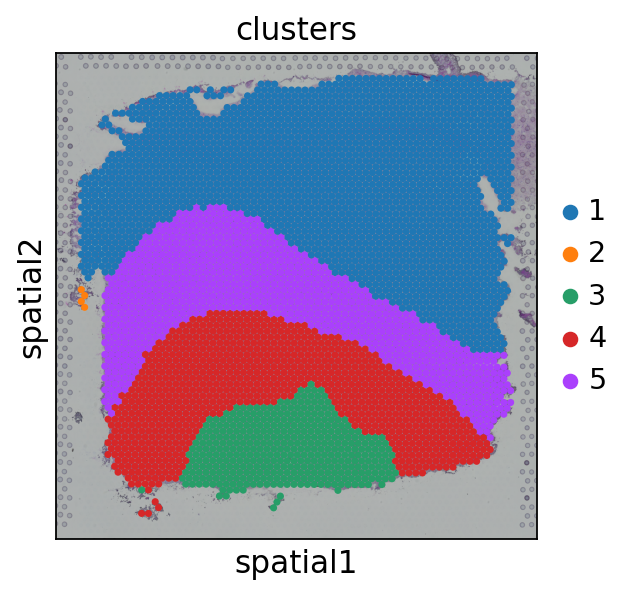

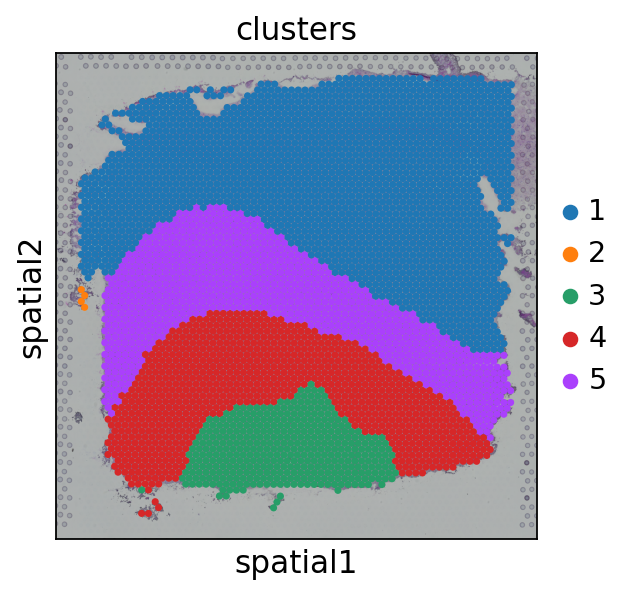

In [5]:
import matplotlib as mpl
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import visual
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"
warnings.filterwarnings('ignore')
file_fold = '/home/cuiyaxuan/spatialLIBD/151672/' # your path
adata = sc.read_visium(file_fold, count_file='151672_filtered_feature_bc_matrix.h5', load_images=True)
df_label=pd.read_csv('./label.csv', index_col=0) 
visual.visual(adata,df_label)


In [8]:
from DenoiseST import DenoiseST
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

def setup_seed(seed=41):
    import torch
    import os
    import numpy as np
    import random
    torch.manual_seed(seed)  
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    if torch.cuda.is_available():
        # torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed(seed)  
        torch.cuda.manual_seed_all(seed) 
        #os.environ['PYTHONHASHSEED'] = str(seed)

setup_seed(41)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


n_clusters = 30  ###### the number of spatial domains.
file_fold = '/home/cuiyaxuan/spatialLIBD/3.Human_Breast_Cancer' #### to your path
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True) #### project name
adata.var_names_make_unique()
model = DenoiseST(adata,device=device,n_top_genes=5000)
adata = model.train()
radius = 50
tool = 'mclust' # mclust, leiden, and louvain
from utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True)
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

adata.obs['domain']
adata.obs['domain'].to_csv("label.csv")

Begin to train ST data...


  0%|                                                   | 0/500 [00:00<?, ?it/s]

0


  0%|                                           | 1/500 [00:03<29:53,  3.59s/it]

0


  0%|▏                                          | 2/500 [00:07<30:10,  3.64s/it]

0


  1%|▎                                          | 3/500 [00:10<29:51,  3.61s/it]

0


  1%|▎                                          | 4/500 [00:14<29:26,  3.56s/it]

0


  1%|▍                                          | 5/500 [00:17<27:51,  3.38s/it]

0


  1%|▌                                          | 6/500 [00:20<28:20,  3.44s/it]

0


  1%|▌                                          | 7/500 [00:24<28:43,  3.50s/it]

0


  2%|▋                                          | 8/500 [00:28<28:52,  3.52s/it]

0


  2%|▊                                          | 9/500 [00:31<28:55,  3.54s/it]

0


  2%|▊                                         | 10/500 [00:35<29:12,  3.58s/it]

0


  2%|▉                                         | 11/500 [00:38<29:07,  3.57s/it]

0


  2%|█                                         | 12/500 [00:42<27:52,  3.43s/it]

0


  3%|█                                         | 13/500 [00:45<28:27,  3.51s/it]

0


  3%|█▏                                        | 14/500 [00:48<27:49,  3.44s/it]

0


  3%|█▎                                        | 15/500 [00:52<28:18,  3.50s/it]

0


  3%|█▎                                        | 16/500 [00:56<28:46,  3.57s/it]

0


  3%|█▍                                        | 17/500 [01:00<29:12,  3.63s/it]

0


  4%|█▌                                        | 18/500 [01:03<29:09,  3.63s/it]

0


  4%|█▌                                        | 19/500 [01:07<29:00,  3.62s/it]

0


  4%|█▋                                        | 20/500 [01:10<28:47,  3.60s/it]

0


  4%|█▊                                        | 21/500 [01:14<28:20,  3.55s/it]

0


  4%|█▊                                        | 22/500 [01:18<28:41,  3.60s/it]

0


  5%|█▉                                        | 23/500 [01:21<28:51,  3.63s/it]

0


  5%|██                                        | 24/500 [01:25<29:05,  3.67s/it]

0


  5%|██                                        | 25/500 [01:29<29:00,  3.66s/it]

0


  5%|██▏                                       | 26/500 [01:32<28:18,  3.58s/it]

0


  5%|██▎                                       | 27/500 [01:36<27:59,  3.55s/it]

0


  6%|██▎                                       | 28/500 [01:39<28:12,  3.59s/it]

0


  6%|██▍                                       | 29/500 [01:43<28:16,  3.60s/it]

0


  6%|██▌                                       | 30/500 [01:46<28:19,  3.62s/it]

0


  6%|██▌                                       | 31/500 [01:50<27:03,  3.46s/it]

0


  6%|██▋                                       | 32/500 [01:53<27:13,  3.49s/it]

0


  7%|██▊                                       | 33/500 [01:56<26:21,  3.39s/it]

0


  7%|██▊                                       | 34/500 [01:59<25:14,  3.25s/it]

0


  7%|██▉                                       | 35/500 [02:03<26:15,  3.39s/it]

0


  7%|███                                       | 36/500 [02:06<25:42,  3.32s/it]

0


  7%|███                                       | 37/500 [02:10<26:19,  3.41s/it]

0


  8%|███▏                                      | 38/500 [02:13<26:48,  3.48s/it]

0


  8%|███▎                                      | 39/500 [02:17<27:18,  3.55s/it]

0


  8%|███▎                                      | 40/500 [02:21<27:04,  3.53s/it]

0


  8%|███▍                                      | 41/500 [02:24<26:47,  3.50s/it]

0


  8%|███▌                                      | 42/500 [02:27<25:58,  3.40s/it]

0


  9%|███▌                                      | 43/500 [02:31<26:48,  3.52s/it]

0


  9%|███▋                                      | 44/500 [02:35<26:53,  3.54s/it]

0


  9%|███▊                                      | 45/500 [02:38<26:40,  3.52s/it]

0


  9%|███▊                                      | 46/500 [02:41<26:22,  3.48s/it]

0


  9%|███▉                                      | 47/500 [02:44<25:20,  3.36s/it]

0


 10%|████                                      | 48/500 [02:48<25:49,  3.43s/it]

0


 10%|████                                      | 49/500 [02:52<25:54,  3.45s/it]

0


 10%|████▏                                     | 50/500 [02:55<26:09,  3.49s/it]

0


 10%|████▎                                     | 51/500 [02:59<26:24,  3.53s/it]

0


 10%|████▎                                     | 52/500 [03:02<26:43,  3.58s/it]

0


 11%|████▍                                     | 53/500 [03:05<25:03,  3.36s/it]

0


 11%|████▌                                     | 54/500 [03:09<25:38,  3.45s/it]

0


 11%|████▌                                     | 55/500 [03:13<25:52,  3.49s/it]

0


 11%|████▋                                     | 56/500 [03:16<26:04,  3.52s/it]

0


 11%|████▊                                     | 57/500 [03:20<26:10,  3.55s/it]

0


 12%|████▊                                     | 58/500 [03:23<26:05,  3.54s/it]

0


 12%|████▉                                     | 59/500 [03:27<26:18,  3.58s/it]

0


 12%|█████                                     | 60/500 [03:30<25:08,  3.43s/it]

0


 12%|█████                                     | 61/500 [03:34<25:13,  3.45s/it]

0


 12%|█████▏                                    | 62/500 [03:37<25:03,  3.43s/it]

0


 13%|█████▎                                    | 63/500 [03:41<25:42,  3.53s/it]

0


 13%|█████▍                                    | 64/500 [03:44<25:48,  3.55s/it]

0


 13%|█████▍                                    | 65/500 [03:48<25:55,  3.57s/it]

0


 13%|█████▌                                    | 66/500 [03:51<24:42,  3.42s/it]

0


 13%|█████▋                                    | 67/500 [03:55<24:57,  3.46s/it]

0


 14%|█████▋                                    | 68/500 [03:58<24:50,  3.45s/it]

0


 14%|█████▊                                    | 69/500 [04:01<24:15,  3.38s/it]

0


 14%|█████▉                                    | 70/500 [04:04<23:48,  3.32s/it]

0


 14%|█████▉                                    | 71/500 [04:08<24:28,  3.42s/it]

0


 14%|██████                                    | 72/500 [04:12<25:11,  3.53s/it]

0


 15%|██████▏                                   | 73/500 [04:15<24:53,  3.50s/it]

0


 15%|██████▏                                   | 74/500 [04:18<24:02,  3.39s/it]

0


 15%|██████▎                                   | 75/500 [04:22<24:51,  3.51s/it]

0


 15%|██████▍                                   | 76/500 [04:26<24:44,  3.50s/it]

0


 15%|██████▍                                   | 77/500 [04:29<24:54,  3.53s/it]

0


 16%|██████▌                                   | 78/500 [04:33<24:54,  3.54s/it]

0


 16%|██████▋                                   | 79/500 [04:36<23:47,  3.39s/it]

0


 16%|██████▋                                   | 80/500 [04:39<24:01,  3.43s/it]

0


 16%|██████▊                                   | 81/500 [04:43<24:26,  3.50s/it]

0


 16%|██████▉                                   | 82/500 [04:47<24:48,  3.56s/it]

0


 17%|██████▉                                   | 83/500 [04:50<25:09,  3.62s/it]

0


 17%|███████                                   | 84/500 [04:54<24:59,  3.60s/it]

0


 17%|███████▏                                  | 85/500 [04:58<24:50,  3.59s/it]

0


 17%|███████▏                                  | 86/500 [05:01<23:46,  3.44s/it]

0


 17%|███████▎                                  | 87/500 [05:04<24:11,  3.52s/it]

0


 18%|███████▍                                  | 88/500 [05:08<24:26,  3.56s/it]

0


 18%|███████▍                                  | 89/500 [05:12<24:12,  3.53s/it]

0


 18%|███████▌                                  | 90/500 [05:15<24:14,  3.55s/it]

0


 18%|███████▋                                  | 91/500 [05:19<24:05,  3.53s/it]

0


 18%|███████▋                                  | 92/500 [05:22<24:11,  3.56s/it]

0


 19%|███████▊                                  | 93/500 [05:26<24:01,  3.54s/it]

0


 19%|███████▉                                  | 94/500 [05:29<22:58,  3.39s/it]

0


 19%|███████▉                                  | 95/500 [05:32<22:41,  3.36s/it]

0


 19%|████████                                  | 96/500 [05:36<23:06,  3.43s/it]

0


 19%|████████▏                                 | 97/500 [05:39<23:13,  3.46s/it]

0


 20%|████████▏                                 | 98/500 [05:42<22:19,  3.33s/it]

0


 20%|████████▎                                 | 99/500 [05:46<23:09,  3.47s/it]

0


 20%|████████▏                                | 100/500 [05:49<22:52,  3.43s/it]

0


 20%|████████▎                                | 101/500 [05:53<23:10,  3.48s/it]

0


 20%|████████▎                                | 102/500 [05:57<23:29,  3.54s/it]

0


 21%|████████▍                                | 103/500 [06:00<23:40,  3.58s/it]

0


 21%|████████▌                                | 104/500 [06:04<23:31,  3.56s/it]

0


 21%|████████▌                                | 105/500 [06:08<23:44,  3.61s/it]

0


 21%|████████▋                                | 106/500 [06:11<23:55,  3.64s/it]

0


 21%|████████▊                                | 107/500 [06:15<23:48,  3.64s/it]

0


 22%|████████▊                                | 108/500 [06:19<23:59,  3.67s/it]

0


 22%|████████▉                                | 109/500 [06:22<23:37,  3.63s/it]

0


 22%|█████████                                | 110/500 [06:26<23:23,  3.60s/it]

0


 22%|█████████                                | 111/500 [06:29<23:36,  3.64s/it]

0


 22%|█████████▏                               | 112/500 [06:33<22:56,  3.55s/it]

0


 23%|█████████▎                               | 113/500 [06:36<23:11,  3.59s/it]

0


 23%|█████████▎                               | 114/500 [06:40<22:43,  3.53s/it]

0


 23%|█████████▍                               | 115/500 [06:44<23:04,  3.60s/it]

0


 23%|█████████▌                               | 116/500 [06:47<23:01,  3.60s/it]

0


 23%|█████████▌                               | 117/500 [06:51<23:07,  3.62s/it]

0


 24%|█████████▋                               | 118/500 [06:54<22:37,  3.55s/it]

0


 24%|█████████▊                               | 119/500 [06:58<22:56,  3.61s/it]

0


 24%|█████████▊                               | 120/500 [07:01<21:37,  3.41s/it]

0


 24%|█████████▉                               | 121/500 [07:05<22:04,  3.49s/it]

0


 24%|██████████                               | 122/500 [07:08<22:20,  3.55s/it]

0


 25%|██████████                               | 123/500 [07:12<22:19,  3.55s/it]

0


 25%|██████████▏                              | 124/500 [07:16<22:36,  3.61s/it]

0


 25%|██████████▎                              | 125/500 [07:19<22:25,  3.59s/it]

0


 25%|██████████▎                              | 126/500 [07:23<22:44,  3.65s/it]

0


 25%|██████████▍                              | 127/500 [07:27<22:52,  3.68s/it]

0


 26%|██████████▍                              | 128/500 [07:30<22:48,  3.68s/it]

0


 26%|██████████▌                              | 129/500 [07:34<22:34,  3.65s/it]

0


 26%|██████████▋                              | 130/500 [07:38<22:32,  3.66s/it]

0


 26%|██████████▋                              | 131/500 [07:41<22:08,  3.60s/it]

0


 26%|██████████▊                              | 132/500 [07:45<22:14,  3.63s/it]

0


 27%|██████████▉                              | 133/500 [07:48<22:07,  3.62s/it]

0


 27%|██████████▉                              | 134/500 [07:52<22:10,  3.64s/it]

0


 27%|███████████                              | 135/500 [07:56<22:14,  3.66s/it]

0


 27%|███████████▏                             | 136/500 [07:59<22:04,  3.64s/it]

0


 27%|███████████▏                             | 137/500 [08:03<22:01,  3.64s/it]

0


 28%|███████████▎                             | 138/500 [08:07<21:40,  3.59s/it]

0


 28%|███████████▍                             | 139/500 [08:10<21:21,  3.55s/it]

0


 28%|███████████▍                             | 140/500 [08:14<21:24,  3.57s/it]

0


 28%|███████████▌                             | 141/500 [08:17<20:36,  3.44s/it]

0


 28%|███████████▋                             | 142/500 [08:20<20:51,  3.50s/it]

0


 29%|███████████▋                             | 143/500 [08:24<20:38,  3.47s/it]

0


 29%|███████████▊                             | 144/500 [08:27<20:55,  3.53s/it]

0


 29%|███████████▉                             | 145/500 [08:31<21:08,  3.57s/it]

0


 29%|███████████▉                             | 146/500 [08:35<21:15,  3.60s/it]

0


 29%|████████████                             | 147/500 [08:38<21:04,  3.58s/it]

0


 30%|████████████▏                            | 148/500 [08:42<21:03,  3.59s/it]

0


 30%|████████████▏                            | 149/500 [08:45<20:16,  3.47s/it]

0


 30%|████████████▎                            | 150/500 [08:49<20:30,  3.52s/it]

0


 30%|████████████▍                            | 151/500 [08:52<20:37,  3.54s/it]

0


 30%|████████████▍                            | 152/500 [08:56<20:49,  3.59s/it]

0


 31%|████████████▌                            | 153/500 [08:59<19:56,  3.45s/it]

0


 31%|████████████▋                            | 154/500 [09:03<19:52,  3.45s/it]

0


 31%|████████████▋                            | 155/500 [09:06<19:09,  3.33s/it]

0


 31%|████████████▊                            | 156/500 [09:09<18:53,  3.29s/it]

0


 31%|████████████▊                            | 157/500 [09:13<19:33,  3.42s/it]

0


 32%|████████████▉                            | 158/500 [09:16<19:20,  3.39s/it]

0


 32%|█████████████                            | 159/500 [09:20<19:52,  3.50s/it]

0


 32%|█████████████                            | 160/500 [09:23<19:57,  3.52s/it]

0


 32%|█████████████▏                           | 161/500 [09:27<20:17,  3.59s/it]

0


 32%|█████████████▎                           | 162/500 [09:30<20:02,  3.56s/it]

0


 33%|█████████████▎                           | 163/500 [09:34<20:17,  3.61s/it]

0


 33%|█████████████▍                           | 164/500 [09:38<20:00,  3.57s/it]

0


 33%|█████████████▌                           | 165/500 [09:41<20:03,  3.59s/it]

0


 33%|█████████████▌                           | 166/500 [09:45<20:12,  3.63s/it]

0


 33%|█████████████▋                           | 167/500 [09:48<19:52,  3.58s/it]

0


 34%|█████████████▊                           | 168/500 [09:52<19:46,  3.57s/it]

0


 34%|█████████████▊                           | 169/500 [09:55<18:51,  3.42s/it]

0


 34%|█████████████▉                           | 170/500 [09:59<19:07,  3.48s/it]

0


 34%|██████████████                           | 171/500 [10:02<18:56,  3.45s/it]

0


 34%|██████████████                           | 172/500 [10:06<19:15,  3.52s/it]

0


 35%|██████████████▏                          | 173/500 [10:09<19:18,  3.54s/it]

0


 35%|██████████████▎                          | 174/500 [10:13<19:26,  3.58s/it]

0


 35%|██████████████▎                          | 175/500 [10:17<19:34,  3.62s/it]

0


 35%|██████████████▍                          | 176/500 [10:20<19:42,  3.65s/it]

0


 35%|██████████████▌                          | 177/500 [10:24<19:14,  3.57s/it]

0


 36%|██████████████▌                          | 178/500 [10:27<19:04,  3.55s/it]

0


 36%|██████████████▋                          | 179/500 [10:31<18:55,  3.54s/it]

0


 36%|██████████████▊                          | 180/500 [10:34<18:48,  3.53s/it]

0


 36%|██████████████▊                          | 181/500 [10:38<18:12,  3.42s/it]

0


 36%|██████████████▉                          | 182/500 [10:41<18:24,  3.47s/it]

0


 37%|███████████████                          | 183/500 [10:45<18:38,  3.53s/it]

0


 37%|███████████████                          | 184/500 [10:48<18:22,  3.49s/it]

0


 37%|███████████████▏                         | 185/500 [10:52<18:26,  3.51s/it]

0


 37%|███████████████▎                         | 186/500 [10:55<18:18,  3.50s/it]

0


 37%|███████████████▎                         | 187/500 [10:59<18:31,  3.55s/it]

0


 38%|███████████████▍                         | 188/500 [11:03<18:38,  3.59s/it]

0


 38%|███████████████▍                         | 189/500 [11:06<18:38,  3.60s/it]

0


 38%|███████████████▌                         | 190/500 [11:10<18:26,  3.57s/it]

0


 38%|███████████████▋                         | 191/500 [11:13<18:17,  3.55s/it]

0


 38%|███████████████▋                         | 192/500 [11:17<18:27,  3.60s/it]

0


 39%|███████████████▊                         | 193/500 [11:21<18:25,  3.60s/it]

0


 39%|███████████████▉                         | 194/500 [11:24<18:27,  3.62s/it]

0


 39%|███████████████▉                         | 195/500 [11:28<18:09,  3.57s/it]

0


 39%|████████████████                         | 196/500 [11:31<18:06,  3.58s/it]

0


 39%|████████████████▏                        | 197/500 [11:35<17:34,  3.48s/it]

0


 40%|████████████████▏                        | 198/500 [11:38<17:36,  3.50s/it]

0


 40%|████████████████▎                        | 199/500 [11:42<17:38,  3.52s/it]

0


 40%|████████████████▍                        | 200/500 [11:45<17:14,  3.45s/it]

0


 40%|████████████████▍                        | 201/500 [11:49<17:38,  3.54s/it]

0


 40%|████████████████▌                        | 202/500 [11:52<17:26,  3.51s/it]

0


 41%|████████████████▋                        | 203/500 [11:56<17:35,  3.55s/it]

0


 41%|████████████████▋                        | 204/500 [11:59<16:44,  3.39s/it]

0


 41%|████████████████▊                        | 205/500 [12:02<16:49,  3.42s/it]

0


 41%|████████████████▉                        | 206/500 [12:06<17:05,  3.49s/it]

0


 41%|████████████████▉                        | 207/500 [12:09<16:20,  3.35s/it]

0


 42%|█████████████████                        | 208/500 [12:12<15:59,  3.29s/it]

0


 42%|█████████████████▏                       | 209/500 [12:15<16:04,  3.31s/it]

0


 42%|█████████████████▏                       | 210/500 [12:19<16:33,  3.43s/it]

0


 42%|█████████████████▎                       | 211/500 [12:23<16:54,  3.51s/it]

0


 42%|█████████████████▍                       | 212/500 [12:26<17:03,  3.55s/it]

0


 43%|█████████████████▍                       | 213/500 [12:30<17:16,  3.61s/it]

0


 43%|█████████████████▌                       | 214/500 [12:34<17:18,  3.63s/it]

0


 43%|█████████████████▋                       | 215/500 [12:38<17:16,  3.64s/it]

0


 43%|█████████████████▋                       | 216/500 [12:41<17:12,  3.64s/it]

0


 43%|█████████████████▊                       | 217/500 [12:45<17:00,  3.60s/it]

0


 44%|█████████████████▉                       | 218/500 [12:48<17:00,  3.62s/it]

0


 44%|█████████████████▉                       | 219/500 [12:52<16:33,  3.54s/it]

0


 44%|██████████████████                       | 220/500 [12:55<16:29,  3.53s/it]

0


 44%|██████████████████                       | 221/500 [12:58<16:01,  3.44s/it]

0


 44%|██████████████████▏                      | 222/500 [13:02<16:21,  3.53s/it]

0


 45%|██████████████████▎                      | 223/500 [13:06<16:14,  3.52s/it]

0


 45%|██████████████████▎                      | 224/500 [13:09<16:24,  3.57s/it]

0


 45%|██████████████████▍                      | 225/500 [13:13<16:23,  3.58s/it]

0


 45%|██████████████████▌                      | 226/500 [13:16<15:42,  3.44s/it]

0


 45%|██████████████████▌                      | 227/500 [13:20<15:58,  3.51s/it]

0


 46%|██████████████████▋                      | 228/500 [13:23<16:09,  3.56s/it]

0


 46%|██████████████████▊                      | 229/500 [13:27<15:57,  3.53s/it]

0


 46%|██████████████████▊                      | 230/500 [13:30<15:24,  3.42s/it]

0


 46%|██████████████████▉                      | 231/500 [13:34<15:38,  3.49s/it]

0


 46%|███████████████████                      | 232/500 [13:37<15:47,  3.54s/it]

0


 47%|███████████████████                      | 233/500 [13:41<15:58,  3.59s/it]

0


 47%|███████████████████▏                     | 234/500 [13:45<16:01,  3.62s/it]

0


 47%|███████████████████▎                     | 235/500 [13:48<15:42,  3.56s/it]

0


 47%|███████████████████▎                     | 236/500 [13:52<15:28,  3.52s/it]

0


 47%|███████████████████▍                     | 237/500 [13:55<15:18,  3.49s/it]

0


 48%|███████████████████▌                     | 238/500 [13:59<15:31,  3.56s/it]

0


 48%|███████████████████▌                     | 239/500 [14:02<15:40,  3.60s/it]

0


 48%|███████████████████▋                     | 240/500 [14:06<15:22,  3.55s/it]

0


 48%|███████████████████▊                     | 241/500 [14:09<15:19,  3.55s/it]

0


 48%|███████████████████▊                     | 242/500 [14:13<15:22,  3.58s/it]

0


 49%|███████████████████▉                     | 243/500 [14:16<14:49,  3.46s/it]

0


 49%|████████████████████                     | 244/500 [14:20<14:48,  3.47s/it]

0


 49%|████████████████████                     | 245/500 [14:23<14:41,  3.46s/it]

0


 49%|████████████████████▏                    | 246/500 [14:27<14:52,  3.51s/it]

0


 49%|████████████████████▎                    | 247/500 [14:30<14:26,  3.42s/it]

0


 50%|████████████████████▎                    | 248/500 [14:33<14:15,  3.39s/it]

0


 50%|████████████████████▍                    | 249/500 [14:37<14:34,  3.48s/it]

0


 50%|████████████████████▌                    | 250/500 [14:40<14:18,  3.43s/it]

0


 50%|████████████████████▌                    | 251/500 [14:44<14:26,  3.48s/it]

0


 50%|████████████████████▋                    | 252/500 [14:48<14:27,  3.50s/it]

0


 51%|████████████████████▋                    | 253/500 [14:51<14:41,  3.57s/it]

0


 51%|████████████████████▊                    | 254/500 [14:55<14:41,  3.58s/it]

0


 51%|████████████████████▉                    | 255/500 [14:59<14:51,  3.64s/it]

0


 51%|████████████████████▉                    | 256/500 [15:02<14:40,  3.61s/it]

0


 51%|█████████████████████                    | 257/500 [15:06<14:29,  3.58s/it]

0


 52%|█████████████████████▏                   | 258/500 [15:09<14:32,  3.60s/it]

0


 52%|█████████████████████▏                   | 259/500 [15:13<14:16,  3.56s/it]

0


 52%|█████████████████████▎                   | 260/500 [15:16<13:38,  3.41s/it]

0


 52%|█████████████████████▍                   | 261/500 [15:19<13:26,  3.38s/it]

0


 52%|█████████████████████▍                   | 262/500 [15:23<13:44,  3.46s/it]

0


 53%|█████████████████████▌                   | 263/500 [15:27<13:59,  3.54s/it]

0


 53%|█████████████████████▋                   | 264/500 [15:29<13:11,  3.35s/it]

0


 53%|█████████████████████▋                   | 265/500 [15:33<13:24,  3.42s/it]

0


 53%|█████████████████████▊                   | 266/500 [15:37<13:36,  3.49s/it]

0


 53%|█████████████████████▉                   | 267/500 [15:40<13:49,  3.56s/it]

0


 54%|█████████████████████▉                   | 268/500 [15:44<14:03,  3.64s/it]

0


 54%|██████████████████████                   | 269/500 [15:48<13:58,  3.63s/it]

0


 54%|██████████████████████▏                  | 270/500 [15:52<13:57,  3.64s/it]

0


 54%|██████████████████████▏                  | 271/500 [15:55<13:58,  3.66s/it]

0


 54%|██████████████████████▎                  | 272/500 [15:58<13:14,  3.49s/it]

0


 55%|██████████████████████▍                  | 273/500 [16:02<12:58,  3.43s/it]

0


 55%|██████████████████████▍                  | 274/500 [16:05<12:34,  3.34s/it]

0


 55%|██████████████████████▌                  | 275/500 [16:08<12:54,  3.44s/it]

0


 55%|██████████████████████▋                  | 276/500 [16:12<13:04,  3.50s/it]

0


 55%|██████████████████████▋                  | 277/500 [16:16<13:12,  3.55s/it]

0


 56%|██████████████████████▊                  | 278/500 [16:19<13:14,  3.58s/it]

0


 56%|██████████████████████▉                  | 279/500 [16:23<13:08,  3.57s/it]

0


 56%|██████████████████████▉                  | 280/500 [16:26<13:05,  3.57s/it]

0


 56%|███████████████████████                  | 281/500 [16:30<13:00,  3.57s/it]

0


 56%|███████████████████████                  | 282/500 [16:33<12:24,  3.42s/it]

0


 57%|███████████████████████▏                 | 283/500 [16:37<12:26,  3.44s/it]

0


 57%|███████████████████████▎                 | 284/500 [16:40<12:39,  3.52s/it]

0


 57%|███████████████████████▎                 | 285/500 [16:44<12:28,  3.48s/it]

0


 57%|███████████████████████▍                 | 286/500 [16:47<12:15,  3.44s/it]

0


 57%|███████████████████████▌                 | 287/500 [16:51<12:31,  3.53s/it]

0


 58%|███████████████████████▌                 | 288/500 [16:54<12:36,  3.57s/it]

0


 58%|███████████████████████▋                 | 289/500 [16:58<12:39,  3.60s/it]

0


 58%|███████████████████████▊                 | 290/500 [17:02<12:37,  3.61s/it]

0


 58%|███████████████████████▊                 | 291/500 [17:05<12:42,  3.65s/it]

0


 58%|███████████████████████▉                 | 292/500 [17:09<12:35,  3.63s/it]

0


 59%|████████████████████████                 | 293/500 [17:13<12:32,  3.64s/it]

0


 59%|████████████████████████                 | 294/500 [17:16<12:13,  3.56s/it]

0


 59%|████████████████████████▏                | 295/500 [17:20<12:17,  3.60s/it]

0


 59%|████████████████████████▎                | 296/500 [17:23<12:08,  3.57s/it]

0


 59%|████████████████████████▎                | 297/500 [17:27<12:10,  3.60s/it]

0


 60%|████████████████████████▍                | 298/500 [17:31<12:11,  3.62s/it]

0


 60%|████████████████████████▌                | 299/500 [17:34<12:07,  3.62s/it]

0


 60%|████████████████████████▌                | 300/500 [17:38<12:04,  3.62s/it]

0


 60%|████████████████████████▋                | 301/500 [17:41<11:54,  3.59s/it]

0


 60%|████████████████████████▊                | 302/500 [17:45<11:55,  3.61s/it]

0


 61%|████████████████████████▊                | 303/500 [17:49<11:54,  3.63s/it]

0


 61%|████████████████████████▉                | 304/500 [17:52<11:51,  3.63s/it]

0


 61%|█████████████████████████                | 305/500 [17:56<11:50,  3.64s/it]

0


 61%|█████████████████████████                | 306/500 [18:00<11:51,  3.67s/it]

0


 61%|█████████████████████████▏               | 307/500 [18:03<11:35,  3.60s/it]

0


 62%|█████████████████████████▎               | 308/500 [18:07<11:33,  3.61s/it]

0


 62%|█████████████████████████▎               | 309/500 [18:10<11:04,  3.48s/it]

0


 62%|█████████████████████████▍               | 310/500 [18:14<11:16,  3.56s/it]

0


 62%|█████████████████████████▌               | 311/500 [18:17<11:05,  3.52s/it]

0


 62%|█████████████████████████▌               | 312/500 [18:21<11:03,  3.53s/it]

0


 63%|█████████████████████████▋               | 313/500 [18:24<11:09,  3.58s/it]

0


 63%|█████████████████████████▋               | 314/500 [18:28<11:06,  3.58s/it]

0


 63%|█████████████████████████▊               | 315/500 [18:32<11:07,  3.61s/it]

0


 63%|█████████████████████████▉               | 316/500 [18:35<10:52,  3.55s/it]

0


 63%|█████████████████████████▉               | 317/500 [18:39<10:58,  3.60s/it]

0


 64%|██████████████████████████               | 318/500 [18:43<11:03,  3.65s/it]

0


 64%|██████████████████████████▏              | 319/500 [18:46<10:57,  3.63s/it]

0


 64%|██████████████████████████▏              | 320/500 [18:49<10:13,  3.41s/it]

0


 64%|██████████████████████████▎              | 321/500 [18:52<10:11,  3.41s/it]

0


 64%|██████████████████████████▍              | 322/500 [18:56<10:20,  3.48s/it]

0


 65%|██████████████████████████▍              | 323/500 [19:00<10:23,  3.52s/it]

0


 65%|██████████████████████████▌              | 324/500 [19:03<10:25,  3.55s/it]

0


 65%|██████████████████████████▋              | 325/500 [19:07<10:19,  3.54s/it]

0


 65%|██████████████████████████▋              | 326/500 [19:10<10:16,  3.54s/it]

0


 65%|██████████████████████████▊              | 327/500 [19:14<10:14,  3.55s/it]

0


 66%|██████████████████████████▉              | 328/500 [19:17<10:07,  3.53s/it]

0


 66%|██████████████████████████▉              | 329/500 [19:21<10:04,  3.53s/it]

0


 66%|███████████████████████████              | 330/500 [19:25<10:13,  3.61s/it]

0


 66%|███████████████████████████▏             | 331/500 [19:28<10:03,  3.57s/it]

0


 66%|███████████████████████████▏             | 332/500 [19:32<09:57,  3.55s/it]

0


 67%|███████████████████████████▎             | 333/500 [19:36<10:02,  3.61s/it]

0


 67%|███████████████████████████▍             | 334/500 [19:39<09:48,  3.55s/it]

0


 67%|███████████████████████████▍             | 335/500 [19:43<09:50,  3.58s/it]

0


 67%|███████████████████████████▌             | 336/500 [19:46<09:43,  3.56s/it]

0


 67%|███████████████████████████▋             | 337/500 [19:50<09:36,  3.54s/it]

0


 68%|███████████████████████████▋             | 338/500 [19:53<09:38,  3.57s/it]

0


 68%|███████████████████████████▊             | 339/500 [19:57<09:38,  3.59s/it]

0


 68%|███████████████████████████▉             | 340/500 [20:01<09:36,  3.61s/it]

0


 68%|███████████████████████████▉             | 341/500 [20:04<09:32,  3.60s/it]

0


 68%|████████████████████████████             | 342/500 [20:08<09:29,  3.60s/it]

0


 69%|████████████████████████████▏            | 343/500 [20:11<09:17,  3.55s/it]

0


 69%|████████████████████████████▏            | 344/500 [20:15<09:21,  3.60s/it]

0


 69%|████████████████████████████▎            | 345/500 [20:18<09:16,  3.59s/it]

0


 69%|████████████████████████████▎            | 346/500 [20:22<08:59,  3.50s/it]

0


 69%|████████████████████████████▍            | 347/500 [20:25<09:06,  3.57s/it]

0


 70%|████████████████████████████▌            | 348/500 [20:29<09:04,  3.58s/it]

0


 70%|████████████████████████████▌            | 349/500 [20:33<09:05,  3.61s/it]

0


 70%|████████████████████████████▋            | 350/500 [20:36<09:04,  3.63s/it]

0


 70%|████████████████████████████▊            | 351/500 [20:40<08:55,  3.59s/it]

0


 70%|████████████████████████████▊            | 352/500 [20:43<08:40,  3.52s/it]

0


 71%|████████████████████████████▉            | 353/500 [20:47<08:41,  3.55s/it]

0


 71%|█████████████████████████████            | 354/500 [20:50<08:12,  3.38s/it]

0


 71%|█████████████████████████████            | 355/500 [20:54<08:25,  3.48s/it]

0


 71%|█████████████████████████████▏           | 356/500 [20:57<08:19,  3.47s/it]

0


 71%|█████████████████████████████▎           | 357/500 [21:01<08:28,  3.56s/it]

0


 72%|█████████████████████████████▎           | 358/500 [21:04<07:58,  3.37s/it]

0


 72%|█████████████████████████████▍           | 359/500 [21:07<08:08,  3.47s/it]

0


 72%|█████████████████████████████▌           | 360/500 [21:11<08:15,  3.54s/it]

0


 72%|█████████████████████████████▌           | 361/500 [21:15<08:05,  3.49s/it]

0


 72%|█████████████████████████████▋           | 362/500 [21:18<08:12,  3.57s/it]

0


 73%|█████████████████████████████▊           | 363/500 [21:22<08:10,  3.58s/it]

0


 73%|█████████████████████████████▊           | 364/500 [21:26<08:11,  3.61s/it]

0


 73%|█████████████████████████████▉           | 365/500 [21:29<08:11,  3.64s/it]

0


 73%|██████████████████████████████           | 366/500 [21:33<08:09,  3.65s/it]

0


 73%|██████████████████████████████           | 367/500 [21:37<08:01,  3.62s/it]

0


 74%|██████████████████████████████▏          | 368/500 [21:40<08:01,  3.64s/it]

0


 74%|██████████████████████████████▎          | 369/500 [21:44<07:56,  3.64s/it]

0


 74%|██████████████████████████████▎          | 370/500 [21:47<07:51,  3.62s/it]

0


 74%|██████████████████████████████▍          | 371/500 [21:51<07:45,  3.60s/it]

0


 74%|██████████████████████████████▌          | 372/500 [21:54<07:35,  3.56s/it]

0


 75%|██████████████████████████████▌          | 373/500 [21:58<07:37,  3.60s/it]

0


 75%|██████████████████████████████▋          | 374/500 [22:02<07:35,  3.62s/it]

0


 75%|██████████████████████████████▊          | 375/500 [22:05<07:34,  3.63s/it]

0


 75%|██████████████████████████████▊          | 376/500 [22:09<07:26,  3.60s/it]

0


 75%|██████████████████████████████▉          | 377/500 [22:13<07:21,  3.59s/it]

0


 76%|██████████████████████████████▉          | 378/500 [22:16<07:19,  3.60s/it]

0


 76%|███████████████████████████████          | 379/500 [22:20<07:18,  3.62s/it]

0


 76%|███████████████████████████████▏         | 380/500 [22:23<07:15,  3.63s/it]

0


 76%|███████████████████████████████▏         | 381/500 [22:27<07:05,  3.57s/it]

0


 76%|███████████████████████████████▎         | 382/500 [22:31<07:05,  3.61s/it]

0


 77%|███████████████████████████████▍         | 383/500 [22:34<06:42,  3.44s/it]

0


 77%|███████████████████████████████▍         | 384/500 [22:37<06:36,  3.42s/it]

0


 77%|███████████████████████████████▌         | 385/500 [22:41<06:41,  3.49s/it]

0


 77%|███████████████████████████████▋         | 386/500 [22:44<06:47,  3.57s/it]

0


 77%|███████████████████████████████▋         | 387/500 [22:48<06:46,  3.60s/it]

0


 78%|███████████████████████████████▊         | 388/500 [22:52<06:45,  3.62s/it]

0


 78%|███████████████████████████████▉         | 389/500 [22:55<06:42,  3.63s/it]

0


 78%|███████████████████████████████▉         | 390/500 [22:59<06:29,  3.54s/it]

0


 78%|████████████████████████████████         | 391/500 [23:03<06:34,  3.62s/it]

0


 78%|████████████████████████████████▏        | 392/500 [23:06<06:25,  3.57s/it]

0


 79%|████████████████████████████████▏        | 393/500 [23:09<06:14,  3.50s/it]

0


 79%|████████████████████████████████▎        | 394/500 [23:13<06:14,  3.53s/it]

0


 79%|████████████████████████████████▍        | 395/500 [23:17<06:13,  3.56s/it]

0


 79%|████████████████████████████████▍        | 396/500 [23:20<06:14,  3.60s/it]

0


 79%|████████████████████████████████▌        | 397/500 [23:24<06:10,  3.60s/it]

0


 80%|████████████████████████████████▋        | 398/500 [23:28<06:10,  3.63s/it]

0


 80%|████████████████████████████████▋        | 399/500 [23:31<05:52,  3.49s/it]

0


 80%|████████████████████████████████▊        | 400/500 [23:34<05:36,  3.37s/it]

0


 80%|████████████████████████████████▉        | 401/500 [23:38<05:43,  3.47s/it]

0


 80%|████████████████████████████████▉        | 402/500 [23:41<05:48,  3.55s/it]

0


 81%|█████████████████████████████████        | 403/500 [23:45<05:44,  3.55s/it]

0


 81%|█████████████████████████████████▏       | 404/500 [23:49<05:44,  3.59s/it]

0


 81%|█████████████████████████████████▏       | 405/500 [23:52<05:40,  3.58s/it]

0


 81%|█████████████████████████████████▎       | 406/500 [23:56<05:35,  3.57s/it]

0


 81%|█████████████████████████████████▎       | 407/500 [23:59<05:23,  3.48s/it]

0


 82%|█████████████████████████████████▍       | 408/500 [24:03<05:25,  3.54s/it]

0


 82%|█████████████████████████████████▌       | 409/500 [24:06<05:21,  3.54s/it]

0


 82%|█████████████████████████████████▌       | 410/500 [24:10<05:18,  3.54s/it]

0


 82%|█████████████████████████████████▋       | 411/500 [24:13<05:20,  3.60s/it]

0


 82%|█████████████████████████████████▊       | 412/500 [24:17<05:21,  3.65s/it]

0


 83%|█████████████████████████████████▊       | 413/500 [24:21<05:14,  3.61s/it]

0


 83%|█████████████████████████████████▉       | 414/500 [24:24<05:09,  3.60s/it]

0


 83%|██████████████████████████████████       | 415/500 [24:28<05:02,  3.56s/it]

0


 83%|██████████████████████████████████       | 416/500 [24:31<05:01,  3.59s/it]

0


 83%|██████████████████████████████████▏      | 417/500 [24:35<05:01,  3.63s/it]

0


 84%|██████████████████████████████████▎      | 418/500 [24:38<04:46,  3.49s/it]

0


 84%|██████████████████████████████████▎      | 419/500 [24:42<04:44,  3.51s/it]

0


 84%|██████████████████████████████████▍      | 420/500 [24:46<04:45,  3.56s/it]

0


 84%|██████████████████████████████████▌      | 421/500 [24:49<04:41,  3.57s/it]

0


 84%|██████████████████████████████████▌      | 422/500 [24:52<04:32,  3.49s/it]

0


 85%|██████████████████████████████████▋      | 423/500 [24:56<04:25,  3.45s/it]

0


 85%|██████████████████████████████████▊      | 424/500 [24:59<04:28,  3.53s/it]

0


 85%|██████████████████████████████████▊      | 425/500 [25:03<04:22,  3.49s/it]

0


 85%|██████████████████████████████████▉      | 426/500 [25:07<04:23,  3.56s/it]

0


 85%|███████████████████████████████████      | 427/500 [25:10<04:21,  3.58s/it]

0


 86%|███████████████████████████████████      | 428/500 [25:14<04:18,  3.59s/it]

0


 86%|███████████████████████████████████▏     | 429/500 [25:18<04:17,  3.62s/it]

0


 86%|███████████████████████████████████▎     | 430/500 [25:21<04:09,  3.57s/it]

0


 86%|███████████████████████████████████▎     | 431/500 [25:24<04:03,  3.53s/it]

0


 86%|███████████████████████████████████▍     | 432/500 [25:28<04:03,  3.58s/it]

0


 87%|███████████████████████████████████▌     | 433/500 [25:31<03:54,  3.51s/it]

0


 87%|███████████████████████████████████▌     | 434/500 [25:35<03:48,  3.46s/it]

0


 87%|███████████████████████████████████▋     | 435/500 [25:38<03:44,  3.46s/it]

0


 87%|███████████████████████████████████▊     | 436/500 [25:42<03:41,  3.47s/it]

0


 87%|███████████████████████████████████▊     | 437/500 [25:45<03:30,  3.34s/it]

0


 88%|███████████████████████████████████▉     | 438/500 [25:48<03:27,  3.34s/it]

0


 88%|███████████████████████████████████▉     | 439/500 [25:52<03:31,  3.47s/it]

0


 88%|████████████████████████████████████     | 440/500 [25:55<03:27,  3.47s/it]

0


 88%|████████████████████████████████████▏    | 441/500 [25:59<03:28,  3.53s/it]

0


 88%|████████████████████████████████████▏    | 442/500 [26:03<03:28,  3.59s/it]

0


 89%|████████████████████████████████████▎    | 443/500 [26:06<03:26,  3.62s/it]

0


 89%|████████████████████████████████████▍    | 444/500 [26:10<03:19,  3.56s/it]

0


 89%|████████████████████████████████████▍    | 445/500 [26:13<03:07,  3.42s/it]

0


 89%|████████████████████████████████████▌    | 446/500 [26:17<03:09,  3.50s/it]

0


 89%|████████████████████████████████████▋    | 447/500 [26:20<03:07,  3.53s/it]

0


 90%|████████████████████████████████████▋    | 448/500 [26:24<03:05,  3.56s/it]

0


 90%|████████████████████████████████████▊    | 449/500 [26:27<03:01,  3.56s/it]

0


 90%|████████████████████████████████████▉    | 450/500 [26:31<02:55,  3.50s/it]

0


 90%|████████████████████████████████████▉    | 451/500 [26:35<02:54,  3.56s/it]

0


 90%|█████████████████████████████████████    | 452/500 [26:37<02:41,  3.37s/it]

0


 91%|█████████████████████████████████████▏   | 453/500 [26:41<02:37,  3.36s/it]

0


 91%|█████████████████████████████████████▏   | 454/500 [26:44<02:34,  3.36s/it]

0


 91%|█████████████████████████████████████▎   | 455/500 [26:48<02:33,  3.40s/it]

0


 91%|█████████████████████████████████████▍   | 456/500 [26:51<02:33,  3.49s/it]

0


 91%|█████████████████████████████████████▍   | 457/500 [26:55<02:31,  3.53s/it]

0


 92%|█████████████████████████████████████▌   | 458/500 [26:59<02:30,  3.58s/it]

0


 92%|█████████████████████████████████████▋   | 459/500 [27:02<02:26,  3.58s/it]

0


 92%|█████████████████████████████████████▋   | 460/500 [27:06<02:23,  3.58s/it]

0


 92%|█████████████████████████████████████▊   | 461/500 [27:09<02:19,  3.58s/it]

0


 92%|█████████████████████████████████████▉   | 462/500 [27:13<02:16,  3.60s/it]

0


 93%|█████████████████████████████████████▉   | 463/500 [27:17<02:13,  3.61s/it]

0


 93%|██████████████████████████████████████   | 464/500 [27:20<02:11,  3.65s/it]

0


 93%|██████████████████████████████████████▏  | 465/500 [27:24<02:06,  3.61s/it]

0


 93%|██████████████████████████████████████▏  | 466/500 [27:28<02:03,  3.64s/it]

0


 93%|██████████████████████████████████████▎  | 467/500 [27:31<01:59,  3.62s/it]

0


 94%|██████████████████████████████████████▍  | 468/500 [27:35<01:55,  3.60s/it]

0


 94%|██████████████████████████████████████▍  | 469/500 [27:38<01:51,  3.59s/it]

0


 94%|██████████████████████████████████████▌  | 470/500 [27:42<01:47,  3.58s/it]

0


 94%|██████████████████████████████████████▌  | 471/500 [27:46<01:44,  3.61s/it]

0


 94%|██████████████████████████████████████▋  | 472/500 [27:49<01:38,  3.51s/it]

0


 95%|██████████████████████████████████████▊  | 473/500 [27:53<01:36,  3.57s/it]

0


 95%|██████████████████████████████████████▊  | 474/500 [27:56<01:33,  3.58s/it]

0


 95%|██████████████████████████████████████▉  | 475/500 [28:00<01:30,  3.62s/it]

0


 95%|███████████████████████████████████████  | 476/500 [28:03<01:26,  3.59s/it]

0


 95%|███████████████████████████████████████  | 477/500 [28:07<01:23,  3.62s/it]

0


 96%|███████████████████████████████████████▏ | 478/500 [28:11<01:19,  3.63s/it]

0


 96%|███████████████████████████████████████▎ | 479/500 [28:14<01:16,  3.66s/it]

0


 96%|███████████████████████████████████████▎ | 480/500 [28:18<01:13,  3.66s/it]

0


 96%|███████████████████████████████████████▍ | 481/500 [28:21<01:06,  3.49s/it]

0


 96%|███████████████████████████████████████▌ | 482/500 [28:24<01:00,  3.36s/it]

0


 97%|███████████████████████████████████████▌ | 483/500 [28:28<00:58,  3.44s/it]

0


 97%|███████████████████████████████████████▋ | 484/500 [28:32<00:56,  3.53s/it]

0


 97%|███████████████████████████████████████▊ | 485/500 [28:35<00:51,  3.46s/it]

0


 97%|███████████████████████████████████████▊ | 486/500 [28:39<00:49,  3.51s/it]

0


 97%|███████████████████████████████████████▉ | 487/500 [28:42<00:46,  3.54s/it]

0


 98%|████████████████████████████████████████ | 488/500 [28:46<00:43,  3.59s/it]

0


 98%|████████████████████████████████████████ | 489/500 [28:50<00:39,  3.60s/it]

0


 98%|████████████████████████████████████████▏| 490/500 [28:53<00:36,  3.66s/it]

0


 98%|████████████████████████████████████████▎| 491/500 [28:57<00:32,  3.63s/it]

0


 98%|████████████████████████████████████████▎| 492/500 [29:01<00:29,  3.68s/it]

0


 99%|████████████████████████████████████████▍| 493/500 [29:04<00:25,  3.65s/it]

0


 99%|████████████████████████████████████████▌| 494/500 [29:08<00:21,  3.66s/it]

0


 99%|████████████████████████████████████████▌| 495/500 [29:12<00:18,  3.66s/it]

0


 99%|████████████████████████████████████████▋| 496/500 [29:15<00:14,  3.63s/it]

0


 99%|████████████████████████████████████████▊| 497/500 [29:19<00:10,  3.54s/it]

0


100%|████████████████████████████████████████▊| 498/500 [29:22<00:07,  3.61s/it]

0


100%|████████████████████████████████████████▉| 499/500 [29:26<00:03,  3.67s/it]

0


100%|█████████████████████████████████████████| 500/500 [29:30<00:00,  3.54s/it]


Optimization finished for ST data!
fitting ...
  |======================================================================| 100%


#cells after MT filter: 3798


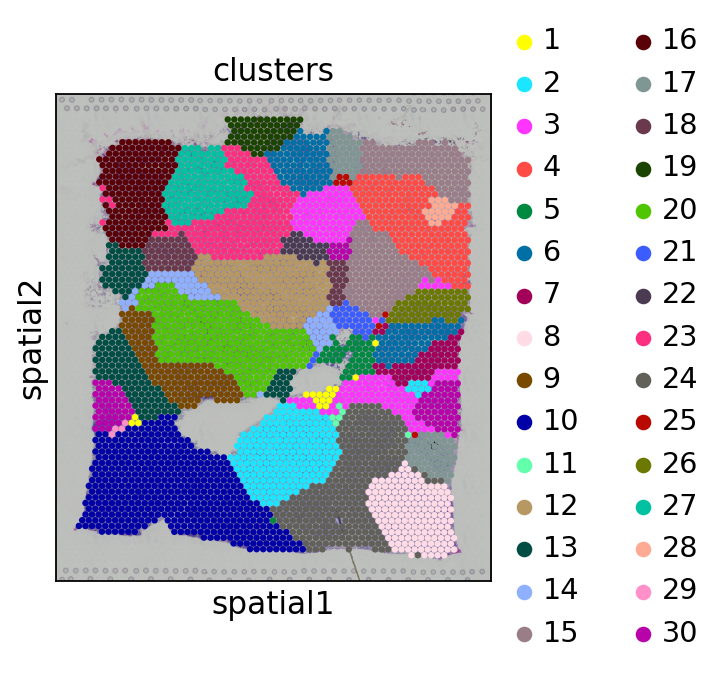

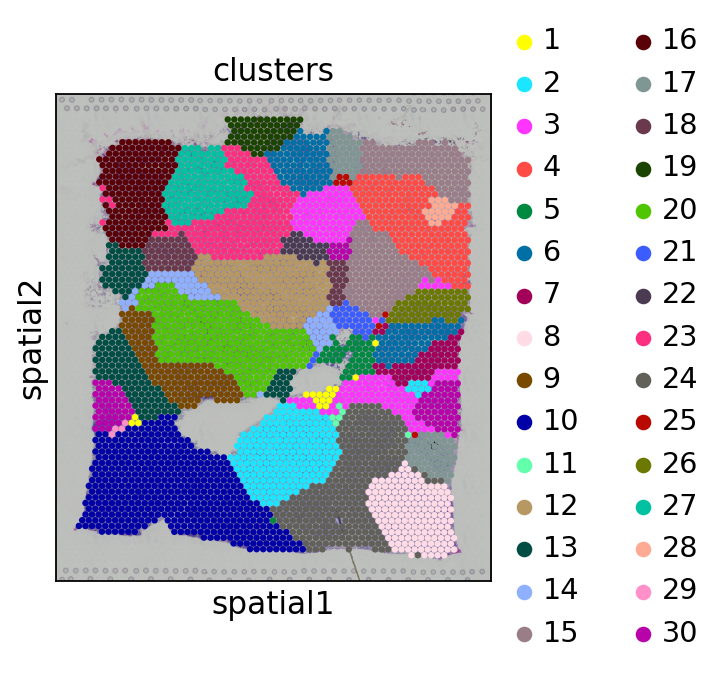

In [9]:
import matplotlib as mpl
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import visual
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"
warnings.filterwarnings('ignore')
file_fold = '/home/cuiyaxuan/spatialLIBD/3.Human_Breast_Cancer' #### to your path
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True) #### project name
df_label=pd.read_csv('./label.csv', index_col=0) 
visual.visual(adata,df_label)


In [13]:
from DenoiseST import DenoiseST
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

def setup_seed(seed=41):
    import torch
    import os
    import numpy as np
    import random
    torch.manual_seed(seed)  
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    if torch.cuda.is_available():
        # torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed(seed)  
        torch.cuda.manual_seed_all(seed) 
        #os.environ['PYTHONHASHSEED'] = str(seed)

setup_seed(41)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


n_clusters = 7  ###### the number of spatial domains.
file_path = '/home/cuiyaxuan/spatialLIBD/5.Mouse_Olfactory/' #please replace 'file_path' with the download path
adata = sc.read_h5ad(file_path + 'filtered_feature_bc_matrix.h5ad') #### project name
adata.var_names_make_unique()
model = DenoiseST(adata,device=device,n_top_genes=5000)
adata = model.train()
radius = 50
tool = 'mclust' # mclust, leiden, and louvain
from utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True)
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

adata.obs['domain']
adata.obs['domain'].to_csv("label.csv")


Begin to train ST data...


  0%|                                                   | 0/500 [00:00<?, ?it/s]

0


  0%|                                         | 1/500 [00:13<1:50:25, 13.28s/it]

0


  0%|▏                                        | 2/500 [00:26<1:50:26, 13.31s/it]

0


  1%|▏                                        | 3/500 [00:39<1:50:05, 13.29s/it]

0


  1%|▎                                        | 4/500 [00:53<1:50:12, 13.33s/it]

0


  1%|▍                                        | 5/500 [01:06<1:49:52, 13.32s/it]

0


  1%|▍                                        | 6/500 [01:19<1:49:39, 13.32s/it]

0


  1%|▌                                        | 7/500 [01:33<1:50:21, 13.43s/it]

0


  2%|▋                                        | 8/500 [01:46<1:50:11, 13.44s/it]

0


  2%|▋                                        | 9/500 [02:00<1:49:43, 13.41s/it]

0


  2%|▊                                       | 10/500 [02:13<1:48:59, 13.35s/it]

0


  2%|▉                                       | 11/500 [02:26<1:48:56, 13.37s/it]

0


  2%|▉                                       | 12/500 [02:40<1:48:33, 13.35s/it]

0


  3%|█                                       | 13/500 [02:53<1:48:15, 13.34s/it]

0


  3%|█                                       | 14/500 [03:07<1:48:20, 13.38s/it]

0


  3%|█▏                                      | 15/500 [03:20<1:47:52, 13.35s/it]

0


  3%|█▎                                      | 16/500 [03:33<1:47:48, 13.37s/it]

0


  3%|█▎                                      | 17/500 [03:47<1:47:32, 13.36s/it]

0


  4%|█▍                                      | 18/500 [04:00<1:46:48, 13.29s/it]

0


  4%|█▌                                      | 19/500 [04:13<1:46:37, 13.30s/it]

0


  4%|█▌                                      | 20/500 [04:26<1:46:08, 13.27s/it]

0


  4%|█▋                                      | 21/500 [04:40<1:46:03, 13.29s/it]

0


  4%|█▊                                      | 22/500 [04:53<1:46:13, 13.33s/it]

0


  5%|█▊                                      | 23/500 [05:07<1:46:27, 13.39s/it]

0


  5%|█▉                                      | 24/500 [05:20<1:46:13, 13.39s/it]

0


  5%|██                                      | 25/500 [05:33<1:46:04, 13.40s/it]

0


  5%|██                                      | 26/500 [05:47<1:45:39, 13.37s/it]

0


  5%|██▏                                     | 27/500 [06:00<1:45:05, 13.33s/it]

0


  6%|██▏                                     | 28/500 [06:13<1:45:03, 13.35s/it]

0


  6%|██▎                                     | 29/500 [06:27<1:44:47, 13.35s/it]

0


  6%|██▍                                     | 30/500 [06:40<1:44:42, 13.37s/it]

0


  6%|██▍                                     | 31/500 [06:53<1:44:17, 13.34s/it]

0


  6%|██▌                                     | 32/500 [07:06<1:43:26, 13.26s/it]

0


  7%|██▋                                     | 33/500 [07:20<1:43:43, 13.33s/it]

0


  7%|██▋                                     | 34/500 [07:33<1:43:35, 13.34s/it]

0


  7%|██▊                                     | 35/500 [07:47<1:43:14, 13.32s/it]

0


  7%|██▉                                     | 36/500 [08:00<1:42:18, 13.23s/it]

0


  7%|██▉                                     | 37/500 [08:13<1:42:25, 13.27s/it]

0


  8%|███                                     | 38/500 [08:26<1:42:27, 13.31s/it]

0


  8%|███                                     | 39/500 [08:39<1:41:47, 13.25s/it]

0


  8%|███▏                                    | 40/500 [08:53<1:41:20, 13.22s/it]

0


  8%|███▎                                    | 41/500 [09:06<1:41:37, 13.28s/it]

0


  8%|███▎                                    | 42/500 [09:19<1:41:32, 13.30s/it]

0


  9%|███▍                                    | 43/500 [09:33<1:41:00, 13.26s/it]

0


  9%|███▌                                    | 44/500 [09:46<1:40:52, 13.27s/it]

0


  9%|███▌                                    | 45/500 [09:59<1:40:42, 13.28s/it]

0


  9%|███▋                                    | 46/500 [10:12<1:40:27, 13.28s/it]

0


  9%|███▊                                    | 47/500 [10:26<1:40:22, 13.29s/it]

0


 10%|███▊                                    | 48/500 [10:39<1:39:51, 13.26s/it]

0


 10%|███▉                                    | 49/500 [10:52<1:39:40, 13.26s/it]

0


 10%|████                                    | 50/500 [11:06<1:39:45, 13.30s/it]

0


 10%|████                                    | 51/500 [11:19<1:39:33, 13.30s/it]

0


 10%|████▏                                   | 52/500 [11:32<1:39:37, 13.34s/it]

0


 11%|████▏                                   | 53/500 [11:46<1:39:57, 13.42s/it]

0


 11%|████▎                                   | 54/500 [11:59<1:39:34, 13.40s/it]

0


 11%|████▍                                   | 55/500 [12:12<1:38:32, 13.29s/it]

0


 11%|████▍                                   | 56/500 [12:25<1:37:50, 13.22s/it]

0


 11%|████▌                                   | 57/500 [12:39<1:37:48, 13.25s/it]

0


 12%|████▋                                   | 58/500 [12:52<1:37:19, 13.21s/it]

0


 12%|████▋                                   | 59/500 [13:05<1:37:49, 13.31s/it]

0


 12%|████▊                                   | 60/500 [13:18<1:36:35, 13.17s/it]

0


 12%|████▉                                   | 61/500 [13:31<1:36:13, 13.15s/it]

0


 12%|████▉                                   | 62/500 [13:44<1:35:58, 13.15s/it]

0


 13%|█████                                   | 63/500 [13:58<1:36:03, 13.19s/it]

0


 13%|█████                                   | 64/500 [14:11<1:36:15, 13.25s/it]

0


 13%|█████▏                                  | 65/500 [14:24<1:35:38, 13.19s/it]

0


 13%|█████▎                                  | 66/500 [14:38<1:35:55, 13.26s/it]

0


 13%|█████▎                                  | 67/500 [14:51<1:36:05, 13.31s/it]

0


 14%|█████▍                                  | 68/500 [15:05<1:36:25, 13.39s/it]

0


 14%|█████▌                                  | 69/500 [15:18<1:36:20, 13.41s/it]

0


 14%|█████▌                                  | 70/500 [15:31<1:36:07, 13.41s/it]

0


 14%|█████▋                                  | 71/500 [15:45<1:35:56, 13.42s/it]

0


 14%|█████▊                                  | 72/500 [15:58<1:35:13, 13.35s/it]

0


 15%|█████▊                                  | 73/500 [16:11<1:34:44, 13.31s/it]

0


 15%|█████▉                                  | 74/500 [16:25<1:34:41, 13.34s/it]

0


 15%|██████                                  | 75/500 [16:38<1:35:11, 13.44s/it]

0


 15%|██████                                  | 76/500 [16:51<1:34:11, 13.33s/it]

0


 15%|██████▏                                 | 77/500 [17:05<1:33:40, 13.29s/it]

0


 16%|██████▏                                 | 78/500 [17:18<1:33:35, 13.31s/it]

0


 16%|██████▎                                 | 79/500 [17:31<1:33:26, 13.32s/it]

0


 16%|██████▍                                 | 80/500 [17:45<1:33:20, 13.33s/it]

0


 16%|██████▍                                 | 81/500 [17:58<1:32:44, 13.28s/it]

0


 16%|██████▌                                 | 82/500 [18:11<1:33:17, 13.39s/it]

0


 17%|██████▋                                 | 83/500 [18:25<1:33:22, 13.44s/it]

0


 17%|██████▋                                 | 84/500 [18:38<1:32:56, 13.41s/it]

0


 17%|██████▊                                 | 85/500 [18:52<1:32:44, 13.41s/it]

0


 17%|██████▉                                 | 86/500 [19:05<1:32:56, 13.47s/it]

0


 17%|██████▉                                 | 87/500 [19:19<1:32:04, 13.38s/it]

0


 18%|███████                                 | 88/500 [19:32<1:31:04, 13.26s/it]

0


 18%|███████                                 | 89/500 [19:45<1:31:14, 13.32s/it]

0


 18%|███████▏                                | 90/500 [19:59<1:31:47, 13.43s/it]

0


 18%|███████▎                                | 91/500 [20:12<1:31:14, 13.38s/it]

0


 18%|███████▎                                | 92/500 [20:25<1:31:02, 13.39s/it]

0


 19%|███████▍                                | 93/500 [20:39<1:30:51, 13.39s/it]

0


 19%|███████▌                                | 94/500 [20:52<1:30:25, 13.36s/it]

0


 19%|███████▌                                | 95/500 [21:05<1:29:56, 13.33s/it]

0


 19%|███████▋                                | 96/500 [21:19<1:29:46, 13.33s/it]

0


 19%|███████▊                                | 97/500 [21:32<1:29:40, 13.35s/it]

0


 20%|███████▊                                | 98/500 [21:45<1:29:34, 13.37s/it]

0


 20%|███████▉                                | 99/500 [21:59<1:29:27, 13.38s/it]

0


 20%|███████▊                               | 100/500 [22:12<1:28:40, 13.30s/it]

0


 20%|███████▉                               | 101/500 [22:25<1:27:50, 13.21s/it]

0


 20%|███████▉                               | 102/500 [22:38<1:27:32, 13.20s/it]

0


 21%|████████                               | 103/500 [22:51<1:27:07, 13.17s/it]

0


 21%|████████                               | 104/500 [23:05<1:27:45, 13.30s/it]

0


 21%|████████▏                              | 105/500 [23:18<1:27:55, 13.36s/it]

0


 21%|████████▎                              | 106/500 [23:32<1:28:05, 13.42s/it]

0


 21%|████████▎                              | 107/500 [23:45<1:27:41, 13.39s/it]

0


 22%|████████▍                              | 108/500 [23:58<1:27:13, 13.35s/it]

0


 22%|████████▌                              | 109/500 [24:12<1:27:00, 13.35s/it]

0


 22%|████████▌                              | 110/500 [24:25<1:27:01, 13.39s/it]

0


 22%|████████▋                              | 111/500 [24:39<1:26:39, 13.37s/it]

0


 22%|████████▋                              | 112/500 [24:52<1:26:08, 13.32s/it]

0


 23%|████████▊                              | 113/500 [25:05<1:26:20, 13.39s/it]

0


 23%|████████▉                              | 114/500 [25:19<1:26:16, 13.41s/it]

0


 23%|████████▉                              | 115/500 [25:32<1:26:14, 13.44s/it]

0


 23%|█████████                              | 116/500 [25:46<1:25:57, 13.43s/it]

0


 23%|█████████▏                             | 117/500 [25:59<1:25:08, 13.34s/it]

0


 24%|█████████▏                             | 118/500 [26:12<1:24:48, 13.32s/it]

0


 24%|█████████▎                             | 119/500 [26:26<1:24:52, 13.37s/it]

0


 24%|█████████▎                             | 120/500 [26:39<1:24:44, 13.38s/it]

0


 24%|█████████▍                             | 121/500 [26:53<1:24:44, 13.41s/it]

0


 24%|█████████▌                             | 122/500 [27:06<1:24:49, 13.46s/it]

0


 25%|█████████▌                             | 123/500 [27:19<1:24:16, 13.41s/it]

0


 25%|█████████▋                             | 124/500 [27:33<1:23:53, 13.39s/it]

0


 25%|█████████▊                             | 125/500 [27:46<1:24:18, 13.49s/it]

0


 25%|█████████▊                             | 126/500 [28:00<1:23:59, 13.47s/it]

0


 25%|█████████▉                             | 127/500 [28:13<1:23:52, 13.49s/it]

0


 26%|█████████▉                             | 128/500 [28:27<1:23:51, 13.53s/it]

0


 26%|██████████                             | 129/500 [28:41<1:23:37, 13.52s/it]

0


 26%|██████████▏                            | 130/500 [28:54<1:23:11, 13.49s/it]

0


 26%|██████████▏                            | 131/500 [29:08<1:23:07, 13.52s/it]

0


 26%|██████████▎                            | 132/500 [29:21<1:22:46, 13.50s/it]

0


 27%|██████████▎                            | 133/500 [29:34<1:22:07, 13.43s/it]

0


 27%|██████████▍                            | 134/500 [29:48<1:21:55, 13.43s/it]

0


 27%|██████████▌                            | 135/500 [30:01<1:21:28, 13.39s/it]

0


 27%|██████████▌                            | 136/500 [30:14<1:20:32, 13.28s/it]

0


 27%|██████████▋                            | 137/500 [30:27<1:20:19, 13.28s/it]

0


 28%|██████████▊                            | 138/500 [30:41<1:20:33, 13.35s/it]

0


 28%|██████████▊                            | 139/500 [30:54<1:20:09, 13.32s/it]

0


 28%|██████████▉                            | 140/500 [31:08<1:20:23, 13.40s/it]

0


 28%|██████████▉                            | 141/500 [31:21<1:20:22, 13.43s/it]

0


 28%|███████████                            | 142/500 [31:35<1:20:18, 13.46s/it]

0


 29%|███████████▏                           | 143/500 [31:48<1:20:02, 13.45s/it]

0


 29%|███████████▏                           | 144/500 [32:02<1:19:49, 13.45s/it]

0


 29%|███████████▎                           | 145/500 [32:15<1:19:25, 13.42s/it]

0


 29%|███████████▍                           | 146/500 [32:29<1:19:27, 13.47s/it]

0


 29%|███████████▍                           | 147/500 [32:45<1:25:18, 14.50s/it]

0


 30%|███████████▌                           | 148/500 [32:59<1:23:15, 14.19s/it]

0


 30%|███████████▌                           | 149/500 [33:12<1:21:56, 14.01s/it]

0


 30%|███████████▋                           | 150/500 [33:26<1:21:01, 13.89s/it]

0


 30%|███████████▊                           | 151/500 [33:40<1:20:42, 13.88s/it]

0


 30%|███████████▊                           | 152/500 [33:53<1:19:46, 13.76s/it]

0


 31%|███████████▉                           | 153/500 [34:07<1:19:11, 13.69s/it]

0


 31%|████████████                           | 154/500 [34:21<1:18:49, 13.67s/it]

0


 31%|████████████                           | 155/500 [34:34<1:18:15, 13.61s/it]

0


 31%|████████████▏                          | 156/500 [34:48<1:18:05, 13.62s/it]

0


 31%|████████████▏                          | 157/500 [35:01<1:17:56, 13.64s/it]

0


 32%|████████████▎                          | 158/500 [35:15<1:17:34, 13.61s/it]

0


 32%|████████████▍                          | 159/500 [35:29<1:17:20, 13.61s/it]

0


 32%|████████████▍                          | 160/500 [35:42<1:16:34, 13.51s/it]

0


 32%|████████████▌                          | 161/500 [35:55<1:16:24, 13.52s/it]

0


 32%|████████████▋                          | 162/500 [36:09<1:16:30, 13.58s/it]

0


 33%|████████████▋                          | 163/500 [36:22<1:15:09, 13.38s/it]

0


 33%|████████████▊                          | 164/500 [36:36<1:15:19, 13.45s/it]

0


 33%|████████████▊                          | 165/500 [36:49<1:15:12, 13.47s/it]

0


 33%|████████████▉                          | 166/500 [37:03<1:15:03, 13.48s/it]

0


 33%|█████████████                          | 167/500 [37:16<1:15:04, 13.53s/it]

0


 34%|█████████████                          | 168/500 [37:30<1:14:36, 13.48s/it]

0


 34%|█████████████▏                         | 169/500 [37:43<1:13:55, 13.40s/it]

0


 34%|█████████████▎                         | 170/500 [37:56<1:13:51, 13.43s/it]

0


 34%|█████████████▎                         | 171/500 [38:13<1:18:55, 14.39s/it]

0


 34%|█████████████▍                         | 172/500 [38:27<1:17:28, 14.17s/it]

0


 35%|█████████████▍                         | 173/500 [38:40<1:15:53, 13.93s/it]

0


 35%|█████████████▌                         | 174/500 [38:54<1:15:09, 13.83s/it]

0


 35%|█████████████▋                         | 175/500 [39:07<1:14:31, 13.76s/it]

0


 35%|█████████████▋                         | 176/500 [39:21<1:14:09, 13.73s/it]

0


 35%|█████████████▊                         | 177/500 [39:34<1:13:25, 13.64s/it]

0


 36%|█████████████▉                         | 178/500 [39:47<1:12:00, 13.42s/it]

0


 36%|█████████████▉                         | 179/500 [40:00<1:11:17, 13.32s/it]

0


 36%|██████████████                         | 180/500 [40:14<1:11:22, 13.38s/it]

0


 36%|██████████████                         | 181/500 [40:28<1:11:46, 13.50s/it]

0


 36%|██████████████▏                        | 182/500 [40:41<1:11:45, 13.54s/it]

0


 37%|██████████████▎                        | 183/500 [40:55<1:11:33, 13.54s/it]

0


 37%|██████████████▎                        | 184/500 [41:08<1:11:33, 13.59s/it]

0


 37%|██████████████▍                        | 185/500 [41:22<1:11:10, 13.56s/it]

0


 37%|██████████████▌                        | 186/500 [41:41<1:19:21, 15.16s/it]

0


 37%|██████████████▌                        | 187/500 [42:03<1:30:42, 17.39s/it]

0


 38%|██████████████▋                        | 188/500 [42:22<1:32:18, 17.75s/it]

0


 38%|██████████████▋                        | 189/500 [42:36<1:25:33, 16.51s/it]

0


 38%|██████████████▊                        | 190/500 [42:53<1:27:11, 16.87s/it]

0


 38%|██████████████▉                        | 191/500 [43:16<1:35:41, 18.58s/it]

0


 38%|██████████████▉                        | 192/500 [43:38<1:40:47, 19.63s/it]

0


 39%|███████████████                        | 193/500 [44:00<1:44:41, 20.46s/it]

0


 39%|███████████████▏                       | 194/500 [44:23<1:47:45, 21.13s/it]

0


 39%|███████████████▏                       | 195/500 [44:46<1:50:15, 21.69s/it]

0


 39%|███████████████▎                       | 196/500 [45:08<1:49:58, 21.70s/it]

0


 39%|███████████████▎                       | 197/500 [45:30<1:50:47, 21.94s/it]

0


 40%|███████████████▍                       | 198/500 [45:52<1:50:35, 21.97s/it]

0


 40%|███████████████▌                       | 199/500 [46:14<1:50:11, 21.96s/it]

0


 40%|███████████████▌                       | 200/500 [46:33<1:44:13, 20.85s/it]

0


 40%|███████████████▋                       | 201/500 [46:46<1:33:04, 18.68s/it]

0


 40%|███████████████▊                       | 202/500 [47:00<1:24:58, 17.11s/it]

0


 41%|███████████████▊                       | 203/500 [47:13<1:19:32, 16.07s/it]

0


 41%|███████████████▉                       | 204/500 [47:27<1:15:39, 15.34s/it]

0


 41%|███████████████▉                       | 205/500 [47:41<1:12:53, 14.83s/it]

0


 41%|████████████████                       | 206/500 [47:54<1:10:37, 14.41s/it]

0


 41%|████████████████▏                      | 207/500 [48:07<1:08:49, 14.10s/it]

0


 42%|████████████████▏                      | 208/500 [48:21<1:07:52, 13.95s/it]

0


 42%|████████████████▎                      | 209/500 [48:34<1:07:03, 13.83s/it]

0


 42%|████████████████▍                      | 210/500 [48:48<1:06:12, 13.70s/it]

0


 42%|████████████████▍                      | 211/500 [49:01<1:05:51, 13.67s/it]

0


 42%|████████████████▌                      | 212/500 [49:15<1:06:02, 13.76s/it]

0


 43%|████████████████▌                      | 213/500 [49:29<1:05:39, 13.73s/it]

0


 43%|████████████████▋                      | 214/500 [49:43<1:05:02, 13.65s/it]

0


 43%|████████████████▊                      | 215/500 [49:59<1:09:28, 14.63s/it]

0


 43%|████████████████▊                      | 216/500 [50:13<1:07:50, 14.33s/it]

0


 43%|████████████████▉                      | 217/500 [50:27<1:06:26, 14.09s/it]

0


 44%|█████████████████                      | 218/500 [50:40<1:05:28, 13.93s/it]

0


 44%|█████████████████                      | 219/500 [50:54<1:04:45, 13.83s/it]

0


 44%|█████████████████▏                     | 220/500 [51:07<1:03:54, 13.70s/it]

0


 44%|█████████████████▏                     | 221/500 [51:21<1:04:23, 13.85s/it]

0


 44%|█████████████████▎                     | 222/500 [51:39<1:08:48, 14.85s/it]

0


 45%|█████████████████▍                     | 223/500 [51:52<1:06:33, 14.42s/it]

0


 45%|█████████████████▍                     | 224/500 [52:05<1:05:03, 14.14s/it]

0


 45%|█████████████████▌                     | 225/500 [52:19<1:04:07, 13.99s/it]

0


 45%|█████████████████▋                     | 226/500 [52:33<1:03:17, 13.86s/it]

0


 45%|█████████████████▋                     | 227/500 [52:46<1:02:38, 13.77s/it]

0


 46%|█████████████████▊                     | 228/500 [52:59<1:01:38, 13.60s/it]

0


 46%|█████████████████▊                     | 229/500 [53:13<1:01:34, 13.63s/it]

0


 46%|█████████████████▉                     | 230/500 [53:27<1:01:35, 13.69s/it]

0


 46%|██████████████████                     | 231/500 [53:40<1:01:06, 13.63s/it]

0


 46%|██████████████████                     | 232/500 [53:54<1:00:41, 13.59s/it]

0


 47%|██████████████████▏                    | 233/500 [54:07<1:00:20, 13.56s/it]

0


 47%|███████████████████▏                     | 234/500 [54:21<59:47, 13.49s/it]

0


 47%|███████████████████▎                     | 235/500 [54:34<59:42, 13.52s/it]

0


 47%|██████████████████▍                    | 236/500 [54:53<1:05:55, 14.98s/it]

0


 47%|██████████████████▍                    | 237/500 [55:15<1:15:06, 17.13s/it]

0


 48%|██████████████████▌                    | 238/500 [55:33<1:16:27, 17.51s/it]

0


 48%|██████████████████▋                    | 239/500 [55:46<1:10:34, 16.23s/it]

0


 48%|██████████████████▋                    | 240/500 [56:00<1:07:05, 15.48s/it]

0


 48%|██████████████████▊                    | 241/500 [56:14<1:04:25, 14.92s/it]

0


 48%|██████████████████▉                    | 242/500 [56:34<1:10:20, 16.36s/it]

0


 49%|██████████████████▉                    | 243/500 [56:56<1:17:47, 18.16s/it]

0


 49%|███████████████████                    | 244/500 [57:18<1:22:50, 19.41s/it]

0


 49%|███████████████████                    | 245/500 [57:40<1:25:50, 20.20s/it]

0


 49%|███████████████████▏                   | 246/500 [58:03<1:28:27, 20.90s/it]

0


 49%|███████████████████▎                   | 247/500 [58:25<1:30:13, 21.40s/it]

0


 50%|███████████████████▎                   | 248/500 [58:48<1:31:07, 21.69s/it]

0


 50%|███████████████████▍                   | 249/500 [59:11<1:32:09, 22.03s/it]

0


 50%|███████████████████▌                   | 250/500 [59:32<1:31:34, 21.98s/it]

0


 50%|███████████████████▌                   | 251/500 [59:55<1:31:41, 22.09s/it]

0


 50%|██████████████████▋                  | 252/500 [1:00:17<1:31:16, 22.08s/it]

0


 51%|██████████████████▋                  | 253/500 [1:00:39<1:31:23, 22.20s/it]

0


 51%|██████████████████▊                  | 254/500 [1:00:59<1:28:07, 21.49s/it]

0


 51%|██████████████████▊                  | 255/500 [1:01:21<1:28:36, 21.70s/it]

0


 51%|██████████████████▉                  | 256/500 [1:01:35<1:18:46, 19.37s/it]

0


 51%|███████████████████                  | 257/500 [1:01:49<1:11:31, 17.66s/it]

0


 52%|███████████████████                  | 258/500 [1:02:02<1:06:12, 16.41s/it]

0


 52%|███████████████████▏                 | 259/500 [1:02:16<1:02:29, 15.56s/it]

0


 52%|████████████████████▎                  | 260/500 [1:02:30<59:52, 14.97s/it]

0


 52%|████████████████████▎                  | 261/500 [1:02:43<57:53, 14.53s/it]

0


 52%|████████████████████▍                  | 262/500 [1:02:56<56:14, 14.18s/it]

0


 53%|████████████████████▌                  | 263/500 [1:03:10<55:26, 14.04s/it]

0


 53%|████████████████████▌                  | 264/500 [1:03:24<54:36, 13.88s/it]

0


 53%|████████████████████▋                  | 265/500 [1:03:37<54:06, 13.81s/it]

0


 53%|████████████████████▋                  | 266/500 [1:03:51<53:43, 13.78s/it]

0


 53%|████████████████████▊                  | 267/500 [1:04:05<53:25, 13.76s/it]

0


 54%|████████████████████▉                  | 268/500 [1:04:18<52:38, 13.61s/it]

0


 54%|████████████████████▉                  | 269/500 [1:04:32<52:32, 13.65s/it]

0


 54%|█████████████████████                  | 270/500 [1:04:45<52:15, 13.63s/it]

0


 54%|█████████████████████▏                 | 271/500 [1:04:59<51:48, 13.58s/it]

0


 54%|█████████████████████▏                 | 272/500 [1:05:12<51:33, 13.57s/it]

0


 55%|█████████████████████▎                 | 273/500 [1:05:26<51:20, 13.57s/it]

0


 55%|█████████████████████▎                 | 274/500 [1:05:44<55:37, 14.77s/it]

0


 55%|████████████████████▎                | 275/500 [1:06:06<1:03:36, 16.96s/it]

0


 55%|████████████████████▍                | 276/500 [1:06:28<1:09:37, 18.65s/it]

0


 55%|████████████████████▍                | 277/500 [1:06:51<1:13:49, 19.86s/it]

0


 56%|████████████████████▌                | 278/500 [1:07:13<1:16:31, 20.68s/it]

0


 56%|████████████████████▋                | 279/500 [1:07:36<1:18:34, 21.33s/it]

0


 56%|████████████████████▋                | 280/500 [1:07:59<1:19:46, 21.76s/it]

0


 56%|████████████████████▊                | 281/500 [1:08:22<1:20:33, 22.07s/it]

0


 56%|████████████████████▊                | 282/500 [1:08:44<1:20:25, 22.14s/it]

0


 57%|████████████████████▉                | 283/500 [1:09:07<1:20:18, 22.20s/it]

0


 57%|█████████████████████                | 284/500 [1:09:29<1:20:14, 22.29s/it]

0


 57%|█████████████████████                | 285/500 [1:09:51<1:19:41, 22.24s/it]

0


 57%|█████████████████████▏               | 286/500 [1:10:13<1:19:24, 22.27s/it]

0


 57%|█████████████████████▏               | 287/500 [1:10:37<1:20:08, 22.58s/it]

0


 58%|█████████████████████▎               | 288/500 [1:10:59<1:19:32, 22.51s/it]

0


 58%|█████████████████████▍               | 289/500 [1:11:22<1:19:18, 22.55s/it]

0


 58%|█████████████████████▍               | 290/500 [1:11:41<1:15:10, 21.48s/it]

0


 58%|█████████████████████▌               | 291/500 [1:11:54<1:06:20, 19.05s/it]

0


 58%|█████████████████████▌               | 292/500 [1:12:07<1:00:00, 17.31s/it]

0


 59%|██████████████████████▊                | 293/500 [1:12:21<55:55, 16.21s/it]

0


 59%|██████████████████████▉                | 294/500 [1:12:35<52:56, 15.42s/it]

0


 59%|███████████████████████                | 295/500 [1:12:48<50:45, 14.86s/it]

0


 59%|███████████████████████                | 296/500 [1:13:02<49:11, 14.47s/it]

0


 59%|███████████████████████▏               | 297/500 [1:13:15<48:14, 14.26s/it]

0


 60%|███████████████████████▏               | 298/500 [1:13:29<47:07, 14.00s/it]

0


 60%|███████████████████████▎               | 299/500 [1:13:42<46:10, 13.78s/it]

0


 60%|███████████████████████▍               | 300/500 [1:13:56<45:39, 13.70s/it]

0


 60%|███████████████████████▍               | 301/500 [1:14:09<45:12, 13.63s/it]

0


 60%|███████████████████████▌               | 302/500 [1:14:23<44:57, 13.62s/it]

0


 61%|███████████████████████▋               | 303/500 [1:14:37<44:56, 13.69s/it]

0


 61%|███████████████████████▋               | 304/500 [1:14:50<44:32, 13.63s/it]

0


 61%|███████████████████████▊               | 305/500 [1:15:04<44:11, 13.60s/it]

0


 61%|███████████████████████▊               | 306/500 [1:15:17<43:50, 13.56s/it]

0


 61%|███████████████████████▉               | 307/500 [1:15:31<43:34, 13.54s/it]

0


 62%|████████████████████████               | 308/500 [1:15:44<43:06, 13.47s/it]

0


 62%|████████████████████████               | 309/500 [1:15:57<42:59, 13.50s/it]

0


 62%|████████████████████████▏              | 310/500 [1:16:11<42:40, 13.48s/it]

0


 62%|████████████████████████▎              | 311/500 [1:16:24<42:31, 13.50s/it]

0


 62%|████████████████████████▎              | 312/500 [1:16:38<42:25, 13.54s/it]

0


 63%|████████████████████████▍              | 313/500 [1:16:52<42:12, 13.54s/it]

0


 63%|████████████████████████▍              | 314/500 [1:17:05<41:58, 13.54s/it]

0


 63%|████████████████████████▌              | 315/500 [1:17:21<43:54, 14.24s/it]

0


 63%|████████████████████████▋              | 316/500 [1:17:41<48:42, 15.88s/it]

0


 63%|████████████████████████▋              | 317/500 [1:17:54<46:14, 15.16s/it]

0


 64%|████████████████████████▊              | 318/500 [1:18:08<44:25, 14.64s/it]

0


 64%|████████████████████████▉              | 319/500 [1:18:21<43:12, 14.33s/it]

0


 64%|████████████████████████▉              | 320/500 [1:18:35<42:18, 14.10s/it]

0


 64%|█████████████████████████              | 321/500 [1:18:48<41:23, 13.87s/it]

0


 64%|█████████████████████████              | 322/500 [1:19:01<40:39, 13.71s/it]

0


 65%|█████████████████████████▏             | 323/500 [1:19:15<40:16, 13.65s/it]

0


 65%|█████████████████████████▎             | 324/500 [1:19:28<39:38, 13.51s/it]

0


 65%|█████████████████████████▎             | 325/500 [1:19:41<39:12, 13.44s/it]

0


 65%|█████████████████████████▍             | 326/500 [1:20:00<43:37, 15.05s/it]

0


 65%|█████████████████████████▌             | 327/500 [1:20:22<49:13, 17.07s/it]

0


 66%|█████████████████████████▌             | 328/500 [1:20:44<53:25, 18.64s/it]

0


 66%|█████████████████████████▋             | 329/500 [1:21:07<56:39, 19.88s/it]

0


 66%|█████████████████████████▋             | 330/500 [1:21:29<58:18, 20.58s/it]

0


 66%|█████████████████████████▊             | 331/500 [1:21:51<59:09, 21.00s/it]

0


 66%|████████████████████████▌            | 332/500 [1:22:14<1:00:19, 21.55s/it]

0


 67%|████████████████████████▋            | 333/500 [1:22:37<1:00:41, 21.81s/it]

0


 67%|████████████████████████▋            | 334/500 [1:22:59<1:00:36, 21.91s/it]

0


 67%|██████████████████████████▏            | 335/500 [1:23:12<53:32, 19.47s/it]

0


 67%|██████████████████████████▏            | 336/500 [1:23:26<48:28, 17.73s/it]

0


 67%|██████████████████████████▎            | 337/500 [1:23:40<45:05, 16.60s/it]

0


 68%|██████████████████████████▎            | 338/500 [1:24:01<48:11, 17.85s/it]

0


 68%|██████████████████████████▍            | 339/500 [1:24:15<44:35, 16.62s/it]

0


 68%|██████████████████████████▌            | 340/500 [1:24:28<41:54, 15.72s/it]

0


 68%|██████████████████████████▌            | 341/500 [1:24:41<39:40, 14.97s/it]

0


 68%|██████████████████████████▋            | 342/500 [1:24:54<37:28, 14.23s/it]

0


 69%|██████████████████████████▊            | 343/500 [1:25:07<36:34, 13.98s/it]

0


 69%|██████████████████████████▊            | 344/500 [1:25:21<36:05, 13.88s/it]

0


 69%|██████████████████████████▉            | 345/500 [1:25:35<35:41, 13.82s/it]

0


 69%|██████████████████████████▉            | 346/500 [1:25:48<35:19, 13.76s/it]

0


 69%|███████████████████████████            | 347/500 [1:26:02<34:56, 13.70s/it]

0


 70%|███████████████████████████▏           | 348/500 [1:26:16<34:41, 13.70s/it]

0


 70%|███████████████████████████▏           | 349/500 [1:26:29<34:24, 13.67s/it]

0


 70%|███████████████████████████▎           | 350/500 [1:26:42<33:48, 13.52s/it]

0


 70%|███████████████████████████▍           | 351/500 [1:26:56<33:34, 13.52s/it]

0


 70%|███████████████████████████▍           | 352/500 [1:27:09<33:18, 13.50s/it]

0


 71%|███████████████████████████▌           | 353/500 [1:27:23<33:02, 13.49s/it]

0


 71%|███████████████████████████▌           | 354/500 [1:27:36<32:52, 13.51s/it]

0


 71%|███████████████████████████▋           | 355/500 [1:27:50<32:45, 13.56s/it]

0


 71%|███████████████████████████▊           | 356/500 [1:28:03<32:27, 13.52s/it]

0


 71%|███████████████████████████▊           | 357/500 [1:28:17<32:08, 13.48s/it]

0


 72%|███████████████████████████▉           | 358/500 [1:28:31<32:05, 13.56s/it]

0


 72%|████████████████████████████           | 359/500 [1:28:51<36:24, 15.49s/it]

0


 72%|████████████████████████████           | 360/500 [1:29:10<38:54, 16.68s/it]

0


 72%|████████████████████████████▏          | 361/500 [1:29:24<36:30, 15.76s/it]

0


 72%|████████████████████████████▏          | 362/500 [1:29:37<34:45, 15.11s/it]

0


 73%|████████████████████████████▎          | 363/500 [1:29:50<33:12, 14.55s/it]

0


 73%|████████████████████████████▍          | 364/500 [1:30:04<32:06, 14.17s/it]

0


 73%|████████████████████████████▍          | 365/500 [1:30:17<31:29, 13.99s/it]

0


 73%|████████████████████████████▌          | 366/500 [1:30:31<31:01, 13.89s/it]

0


 73%|████████████████████████████▋          | 367/500 [1:30:44<30:32, 13.78s/it]

0


 74%|████████████████████████████▋          | 368/500 [1:30:58<30:05, 13.68s/it]

0


 74%|████████████████████████████▊          | 369/500 [1:31:11<29:42, 13.61s/it]

0


 74%|████████████████████████████▊          | 370/500 [1:31:25<29:25, 13.58s/it]

0


 74%|████████████████████████████▉          | 371/500 [1:31:38<29:07, 13.55s/it]

0


 74%|█████████████████████████████          | 372/500 [1:31:52<28:50, 13.52s/it]

0


 75%|█████████████████████████████          | 373/500 [1:32:05<28:29, 13.46s/it]

0


 75%|█████████████████████████████▏         | 374/500 [1:32:19<28:19, 13.49s/it]

0


 75%|█████████████████████████████▎         | 375/500 [1:32:32<28:10, 13.53s/it]

0


 75%|█████████████████████████████▎         | 376/500 [1:32:46<27:50, 13.47s/it]

0


 75%|█████████████████████████████▍         | 377/500 [1:32:59<27:42, 13.51s/it]

0


 76%|█████████████████████████████▍         | 378/500 [1:33:13<27:32, 13.55s/it]

0


 76%|█████████████████████████████▌         | 379/500 [1:33:27<27:26, 13.60s/it]

0


 76%|█████████████████████████████▋         | 380/500 [1:33:40<27:06, 13.55s/it]

0


 76%|█████████████████████████████▋         | 381/500 [1:33:53<26:46, 13.50s/it]

0


 76%|█████████████████████████████▊         | 382/500 [1:34:07<26:35, 13.52s/it]

0


 77%|█████████████████████████████▊         | 383/500 [1:34:20<26:18, 13.49s/it]

0


 77%|█████████████████████████████▉         | 384/500 [1:34:34<26:08, 13.52s/it]

0


 77%|██████████████████████████████         | 385/500 [1:34:47<25:54, 13.52s/it]

0


 77%|██████████████████████████████         | 386/500 [1:35:01<25:32, 13.44s/it]

0


 77%|██████████████████████████████▏        | 387/500 [1:35:15<25:31, 13.55s/it]

0


 78%|██████████████████████████████▎        | 388/500 [1:35:28<25:18, 13.56s/it]

0


 78%|██████████████████████████████▎        | 389/500 [1:35:42<25:08, 13.59s/it]

0


 78%|██████████████████████████████▍        | 390/500 [1:35:55<24:53, 13.58s/it]

0


 78%|██████████████████████████████▍        | 391/500 [1:36:09<24:34, 13.53s/it]

0


 78%|██████████████████████████████▌        | 392/500 [1:36:22<24:24, 13.56s/it]

0


 79%|██████████████████████████████▋        | 393/500 [1:36:36<24:09, 13.54s/it]

0


 79%|██████████████████████████████▋        | 394/500 [1:36:49<23:54, 13.54s/it]

0


 79%|██████████████████████████████▊        | 395/500 [1:37:03<23:35, 13.48s/it]

0


 79%|██████████████████████████████▉        | 396/500 [1:37:16<23:23, 13.49s/it]

0


 79%|██████████████████████████████▉        | 397/500 [1:37:30<23:15, 13.55s/it]

0


 80%|███████████████████████████████        | 398/500 [1:37:43<22:59, 13.53s/it]

0


 80%|███████████████████████████████        | 399/500 [1:37:57<22:42, 13.49s/it]

0


 80%|███████████████████████████████▏       | 400/500 [1:38:10<22:29, 13.50s/it]

0


 80%|███████████████████████████████▎       | 401/500 [1:38:29<24:41, 14.97s/it]

0


 80%|███████████████████████████████▎       | 402/500 [1:38:51<28:05, 17.20s/it]

0


 81%|███████████████████████████████▍       | 403/500 [1:39:13<29:59, 18.55s/it]

0


 81%|███████████████████████████████▌       | 404/500 [1:39:35<31:36, 19.76s/it]

0


 81%|███████████████████████████████▌       | 405/500 [1:39:58<32:45, 20.69s/it]

0


 81%|███████████████████████████████▋       | 406/500 [1:40:21<33:20, 21.28s/it]

0


 81%|███████████████████████████████▋       | 407/500 [1:40:44<33:35, 21.67s/it]

0


 82%|███████████████████████████████▊       | 408/500 [1:41:07<33:49, 22.06s/it]

0


 82%|███████████████████████████████▉       | 409/500 [1:41:29<33:27, 22.06s/it]

0


 82%|███████████████████████████████▉       | 410/500 [1:41:51<33:21, 22.24s/it]

0


 82%|████████████████████████████████       | 411/500 [1:42:14<33:00, 22.25s/it]

0


 82%|████████████████████████████████▏      | 412/500 [1:42:36<32:46, 22.34s/it]

0


 83%|████████████████████████████████▏      | 413/500 [1:42:58<32:20, 22.30s/it]

0


 83%|████████████████████████████████▎      | 414/500 [1:43:21<32:11, 22.46s/it]

0


 83%|████████████████████████████████▎      | 415/500 [1:43:43<31:37, 22.32s/it]

0


 83%|████████████████████████████████▍      | 416/500 [1:44:06<31:33, 22.54s/it]

0


 83%|████████████████████████████████▌      | 417/500 [1:44:29<31:11, 22.54s/it]

0


 84%|████████████████████████████████▌      | 418/500 [1:44:51<30:38, 22.42s/it]

0


 84%|████████████████████████████████▋      | 419/500 [1:45:13<30:20, 22.48s/it]

0


 84%|████████████████████████████████▊      | 420/500 [1:45:36<29:47, 22.35s/it]

0


 84%|████████████████████████████████▊      | 421/500 [1:45:58<29:28, 22.39s/it]

0


 84%|████████████████████████████████▉      | 422/500 [1:46:20<29:00, 22.32s/it]

0


 85%|████████████████████████████████▉      | 423/500 [1:46:42<28:32, 22.24s/it]

0


 85%|█████████████████████████████████      | 424/500 [1:47:01<26:43, 21.10s/it]

0


 85%|█████████████████████████████████▏     | 425/500 [1:47:15<23:40, 18.94s/it]

0


 85%|█████████████████████████████████▏     | 426/500 [1:47:28<21:25, 17.37s/it]

0


 85%|█████████████████████████████████▎     | 427/500 [1:47:42<19:46, 16.25s/it]

0


 86%|█████████████████████████████████▍     | 428/500 [1:47:56<18:34, 15.48s/it]

0


 86%|█████████████████████████████████▍     | 429/500 [1:48:09<17:35, 14.87s/it]

0


 86%|█████████████████████████████████▌     | 430/500 [1:48:23<16:53, 14.47s/it]

0


 86%|█████████████████████████████████▌     | 431/500 [1:48:36<16:13, 14.11s/it]

0


 86%|█████████████████████████████████▋     | 432/500 [1:48:49<15:48, 13.95s/it]

0


 87%|█████████████████████████████████▊     | 433/500 [1:49:03<15:22, 13.76s/it]

0


 87%|█████████████████████████████████▊     | 434/500 [1:49:16<15:03, 13.69s/it]

0


 87%|█████████████████████████████████▉     | 435/500 [1:49:30<14:48, 13.66s/it]

0


 87%|██████████████████████████████████     | 436/500 [1:49:43<14:29, 13.59s/it]

0


 87%|██████████████████████████████████     | 437/500 [1:49:57<14:15, 13.58s/it]

0


 88%|██████████████████████████████████▏    | 438/500 [1:50:10<14:02, 13.60s/it]

0


 88%|██████████████████████████████████▏    | 439/500 [1:50:24<13:47, 13.57s/it]

0


 88%|██████████████████████████████████▎    | 440/500 [1:50:37<13:31, 13.53s/it]

0


 88%|██████████████████████████████████▍    | 441/500 [1:50:51<13:19, 13.56s/it]

0


 88%|██████████████████████████████████▍    | 442/500 [1:51:05<13:10, 13.62s/it]

0


 89%|██████████████████████████████████▌    | 443/500 [1:51:19<12:58, 13.65s/it]

0


 89%|██████████████████████████████████▋    | 444/500 [1:51:32<12:42, 13.62s/it]

0


 89%|██████████████████████████████████▋    | 445/500 [1:51:46<12:27, 13.60s/it]

0


 89%|██████████████████████████████████▊    | 446/500 [1:51:59<12:13, 13.58s/it]

0


 89%|██████████████████████████████████▊    | 447/500 [1:52:13<12:01, 13.62s/it]

0


 90%|██████████████████████████████████▉    | 448/500 [1:52:27<11:48, 13.63s/it]

0


 90%|███████████████████████████████████    | 449/500 [1:52:40<11:36, 13.66s/it]

0


 90%|███████████████████████████████████    | 450/500 [1:52:54<11:21, 13.63s/it]

0


 90%|███████████████████████████████████▏   | 451/500 [1:53:08<11:09, 13.66s/it]

0


 90%|███████████████████████████████████▎   | 452/500 [1:53:21<10:56, 13.68s/it]

0


 91%|███████████████████████████████████▎   | 453/500 [1:53:35<10:42, 13.66s/it]

0


 91%|███████████████████████████████████▍   | 454/500 [1:53:48<10:24, 13.58s/it]

0


 91%|███████████████████████████████████▍   | 455/500 [1:54:02<10:13, 13.63s/it]

0


 91%|███████████████████████████████████▌   | 456/500 [1:54:16<09:58, 13.61s/it]

0


 91%|███████████████████████████████████▋   | 457/500 [1:54:29<09:47, 13.66s/it]

0


 92%|███████████████████████████████████▋   | 458/500 [1:54:43<09:32, 13.64s/it]

0


 92%|███████████████████████████████████▊   | 459/500 [1:54:57<09:19, 13.65s/it]

0


 92%|███████████████████████████████████▉   | 460/500 [1:55:11<09:08, 13.71s/it]

0


 92%|███████████████████████████████████▉   | 461/500 [1:55:24<08:53, 13.67s/it]

0


 92%|████████████████████████████████████   | 462/500 [1:55:38<08:40, 13.69s/it]

0


 93%|████████████████████████████████████   | 463/500 [1:55:51<08:23, 13.61s/it]

0


 93%|████████████████████████████████████▏  | 464/500 [1:56:04<08:04, 13.46s/it]

0


 93%|████████████████████████████████████▎  | 465/500 [1:56:18<07:53, 13.52s/it]

0


 93%|████████████████████████████████████▎  | 466/500 [1:56:32<07:40, 13.55s/it]

0


 93%|████████████████████████████████████▍  | 467/500 [1:56:45<07:24, 13.47s/it]

0


 94%|████████████████████████████████████▌  | 468/500 [1:56:58<07:11, 13.50s/it]

0


 94%|████████████████████████████████████▌  | 469/500 [1:57:12<06:56, 13.42s/it]

0


 94%|████████████████████████████████████▋  | 470/500 [1:57:25<06:41, 13.37s/it]

0


 94%|████████████████████████████████████▋  | 471/500 [1:57:39<06:29, 13.43s/it]

0


 94%|████████████████████████████████████▊  | 472/500 [1:57:52<06:17, 13.48s/it]

0


 95%|████████████████████████████████████▉  | 473/500 [1:58:06<06:03, 13.46s/it]

0


 95%|████████████████████████████████████▉  | 474/500 [1:58:19<05:51, 13.51s/it]

0


 95%|█████████████████████████████████████  | 475/500 [1:58:33<05:38, 13.55s/it]

0


 95%|█████████████████████████████████████▏ | 476/500 [1:58:46<05:24, 13.51s/it]

0


 95%|█████████████████████████████████████▏ | 477/500 [1:59:00<05:10, 13.50s/it]

0


 96%|█████████████████████████████████████▎ | 478/500 [1:59:13<04:57, 13.52s/it]

0


 96%|█████████████████████████████████████▎ | 479/500 [1:59:27<04:43, 13.49s/it]

0


 96%|█████████████████████████████████████▍ | 480/500 [1:59:40<04:29, 13.47s/it]

0


 96%|█████████████████████████████████████▌ | 481/500 [1:59:54<04:16, 13.48s/it]

0


 96%|█████████████████████████████████████▌ | 482/500 [2:00:07<04:02, 13.46s/it]

0


 97%|█████████████████████████████████████▋ | 483/500 [2:00:21<03:49, 13.48s/it]

0


 97%|█████████████████████████████████████▊ | 484/500 [2:00:34<03:35, 13.49s/it]

0


 97%|█████████████████████████████████████▊ | 485/500 [2:00:47<03:21, 13.46s/it]

0


 97%|█████████████████████████████████████▉ | 486/500 [2:01:01<03:09, 13.54s/it]

0


 97%|█████████████████████████████████████▉ | 487/500 [2:01:15<02:56, 13.61s/it]

0


 98%|██████████████████████████████████████ | 488/500 [2:01:28<02:42, 13.53s/it]

0


 98%|██████████████████████████████████████▏| 489/500 [2:01:42<02:28, 13.52s/it]

0


 98%|██████████████████████████████████████▏| 490/500 [2:01:55<02:15, 13.57s/it]

0


 98%|██████████████████████████████████████▎| 491/500 [2:02:09<02:02, 13.56s/it]

0


 98%|██████████████████████████████████████▍| 492/500 [2:02:22<01:47, 13.45s/it]

0


 99%|██████████████████████████████████████▍| 493/500 [2:02:36<01:34, 13.49s/it]

0


 99%|██████████████████████████████████████▌| 494/500 [2:02:49<01:20, 13.43s/it]

0


 99%|██████████████████████████████████████▌| 495/500 [2:03:02<01:07, 13.42s/it]

0


 99%|██████████████████████████████████████▋| 496/500 [2:03:16<00:54, 13.53s/it]

0


 99%|██████████████████████████████████████▊| 497/500 [2:03:30<00:40, 13.52s/it]

0


100%|██████████████████████████████████████▊| 498/500 [2:03:43<00:27, 13.57s/it]

0


100%|██████████████████████████████████████▉| 499/500 [2:03:57<00:13, 13.57s/it]

0


100%|███████████████████████████████████████| 500/500 [2:04:11<00:00, 14.90s/it]


Optimization finished for ST data!
fitting ...
  |======================================================================| 100%


#cells after MT filter: 19109


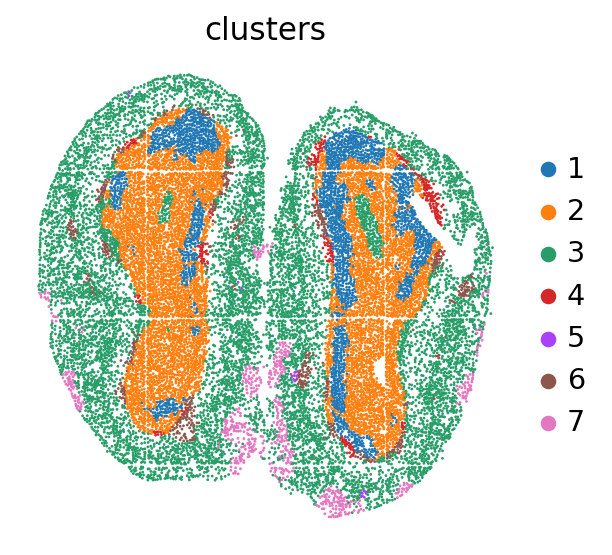

In [14]:
import matplotlib as mpl
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import visual_high
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"
warnings.filterwarnings('ignore')
file_path = '/home/cuiyaxuan/spatialLIBD/5.Mouse_Olfactory/' #please replace 'file_path' with the download path
adata = sc.read_h5ad(file_path + 'filtered_feature_bc_matrix.h5ad') #### project name
df_label=pd.read_csv('./label.csv', index_col=0) 
visual_high.visual(adata,df_label)